# Data Collection

For this part, you can view another textbook, which includes the detail of how to scrap the data from nba website.

# Preprocessing

## Outliers
For outliers, we cannot image any possible outliers in All NBA Team. It is selected by coaches based on their performance in this season. None of them can be selected with low attendance of games or bad performance.

But for not All NBA Team players, we need to notice there are lots of players who didn't play much in a season because of injury or ability. Since the number of All NBA Team players is much larger than the number of not All NBA Team players, we can drop these players out to avoid extreme value in game statistics and reduce the imbalance of target label.

## Adjust the traditional statistics

For traditional statistics, we need to notice that the trend of NBA is changing by time and hence the traditional statistics should not be compared without adjusting them. 

To understand this, the background of current NBA offense trend is essential. Previously, teams were inclined to slow down their pace and play half-court offense and defense.  However, this trend was destroyed by Coach Mike D'Antoni in 2004-2005 season. Under the lead of 2-times MVP player Steve Nash, Phoenix Suns started to squeeze their offensive time into 7 seconds or less and accelerate the offensive pace. From that on, teams tried to play quicker and shoot more 3 point balls. After 2010-2011 season, this new trend was gradually expanded. As a result, the current traditional statistics tend to look much better than the previous statistics, due to the increase of pace and possessions.

**In terms of generalization, we preprocess the traditional statistics by dividing them by the average pace of the season.**

In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('ALL_NBA_TEAM_train.csv')
test_data = pd.read_csv('ALL_NBA_TEAM_test.csv')
test_data.iloc[91, -2] = 1
test_data.iloc[391, -2] = 1
test_data.iloc[391, -1] = 1
train_data.iloc[11033, -2] = 1

def pace_adjust(row):
    pts = row['PTS'] / row['Avg Pace']
    reb = row['REB'] / row['Avg Pace']
    ast = row['AST'] / row['Avg Pace']
    tov = row['TOV'] / row['Avg Pace']
    stl = row['STL'] / row['Avg Pace']
    blk = row['BLK'] / row['Avg Pace']
    fgm = row['FGM'] / row['Avg Pace']
    
    return pts, reb, ast, tov, stl, blk, fgm

# Adjust some statistics with the pace
train_data['PTS'], train_data['REB'], train_data['AST'], train_data['TOV'], \
train_data['STL'], train_data['BLK'], train_data['FGM'] = zip(*train_data.apply(pace_adjust, axis = 1))

test_data['PTS'], test_data['REB'], test_data['AST'], test_data['TOV'], \
test_data['STL'], test_data['BLK'], test_data['FGM'] = zip(*test_data.apply(pace_adjust, axis = 1))

train_data.drop(train_data[train_data.GP < 30].index, inplace = True)

# Feature Selection

To eliminate the number of features (over 30), we select several features for model construction. Some of these features may not appear in our final model, but we keep it here now for completeness and they will be attempted in initial model construction.

These are the features selected to construct the model:

- Adjusted PTS (points)
- Adjusted REB (rebounds)
- Adjusted AST (assists)
- Adjusted TOV (turnover)
- Adjusted STL (steal)
- Adjusted BLK (block)
- Rank 
- **(delete)** Min (minutes played)
- FGM (Field goals made)
- DD2 (Double Double in the season)
- NETRTG (net rating)
- USG% (usage rate)
- PIE (player impact estimator)
- +/- (plus minus stats)
- Selected Last Year? 

In [2]:
selected_features = ['PTS', 'REB', 'AST', 'TOV', 'STL', 'BLK', 
                     'Rank', 'FGM', 'DD2',
                     'NETRTG', 'USG%', 'PIE', '+/-', 'Selected Last Year?']

features_full = ['PTS', 'REB', 'AST', 'TOV', 'STL', 'BLK', 
                     'Rank', 'TS%', 'USG%', 'PIE', 'Selected Last Year?']

X_train = train_data[selected_features]
y_train = train_data['Selected?']
X_test = test_data[selected_features]
y_test = test_data['Selected?']

# Exploratory Data Analysis 

Before we apply machine learning algorithm, it is important to understand features in our data and the relationship between these features.

First, I want to see the difference between distributions of different features for All NBA Team players and not All NBA Team Players. The tool I use is *violinplot* in *seaborn*, which plots the kernel density distribution.

After ignoring some features that are definitely having different distribution between two groups, we draw 7 violinplots.

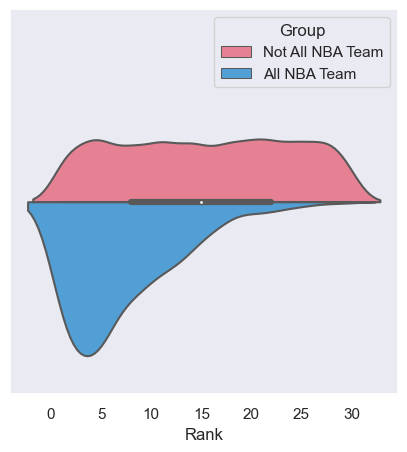

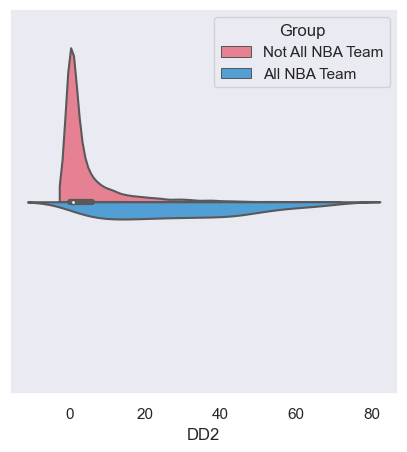

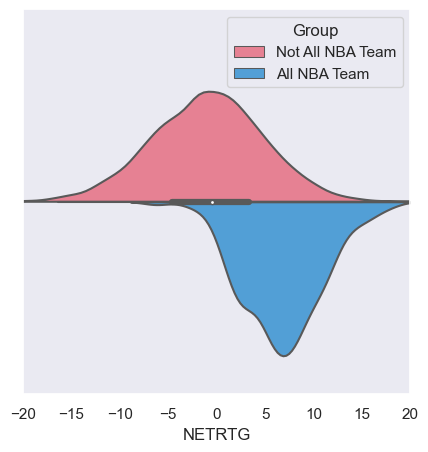

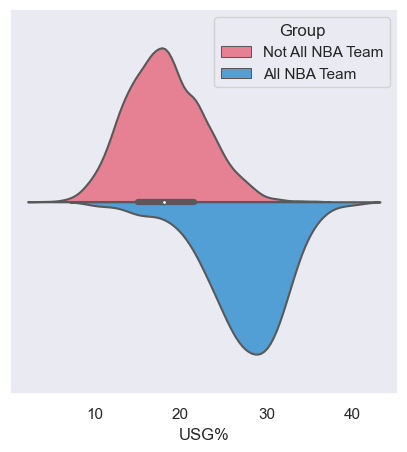

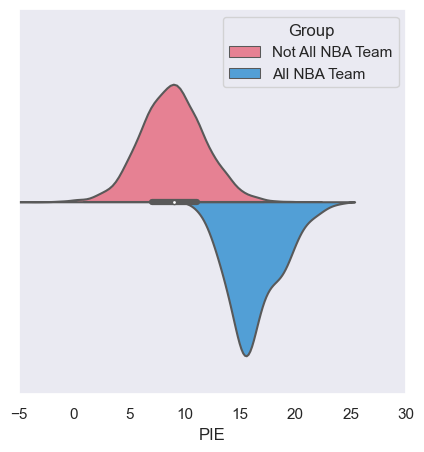

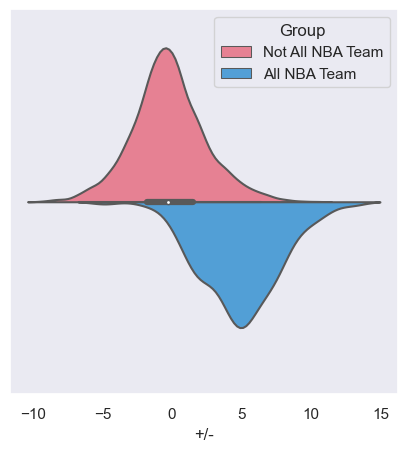

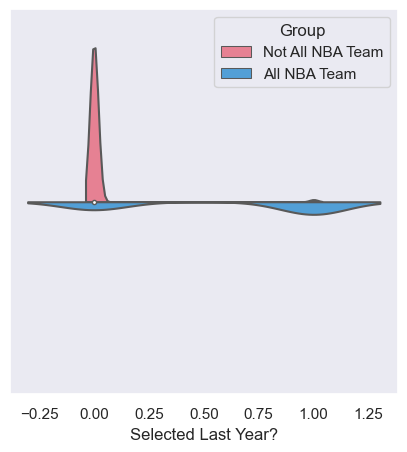

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

husl = sns.color_palette('husl')
# 0 = non all-star: red
# 1 = all-star: green
palette = {
    0 : husl[0],
    1 : husl[4]
}

plt.style.use('default')
sns.set(style = 'dark')
plt.rcParams['legend.title_fontsize'] = 'medium'


size = train_data.shape[0]
features = ['Rank', 'DD2', 'NETRTG', 'USG%', 'PIE', '+/-', 'Selected Last Year?']
for feat in features:
    fig, ax = plt.subplots(figsize = (5, 5))
    
    if feat == 'PIE':
        ax.set_xlim([-5, 30])
        
    if feat == 'NETRTG':
        ax.set_xlim([-20, 20])
        
    sns.violinplot(ax = ax, data = train_data, x = feat, y = [''] * size, hue = 'Selected?', split = True, palette = palette)
    ax.legend_.set_title('Group')
    new_legend = ['Not All NBA Team', 'All NBA Team']
    for t, l in zip(ax.legend_.texts, new_legend):
        t.set_text(l)
    plt.show()

Then we can use *pairplot* in *seaborn* to observe the interaction between features.

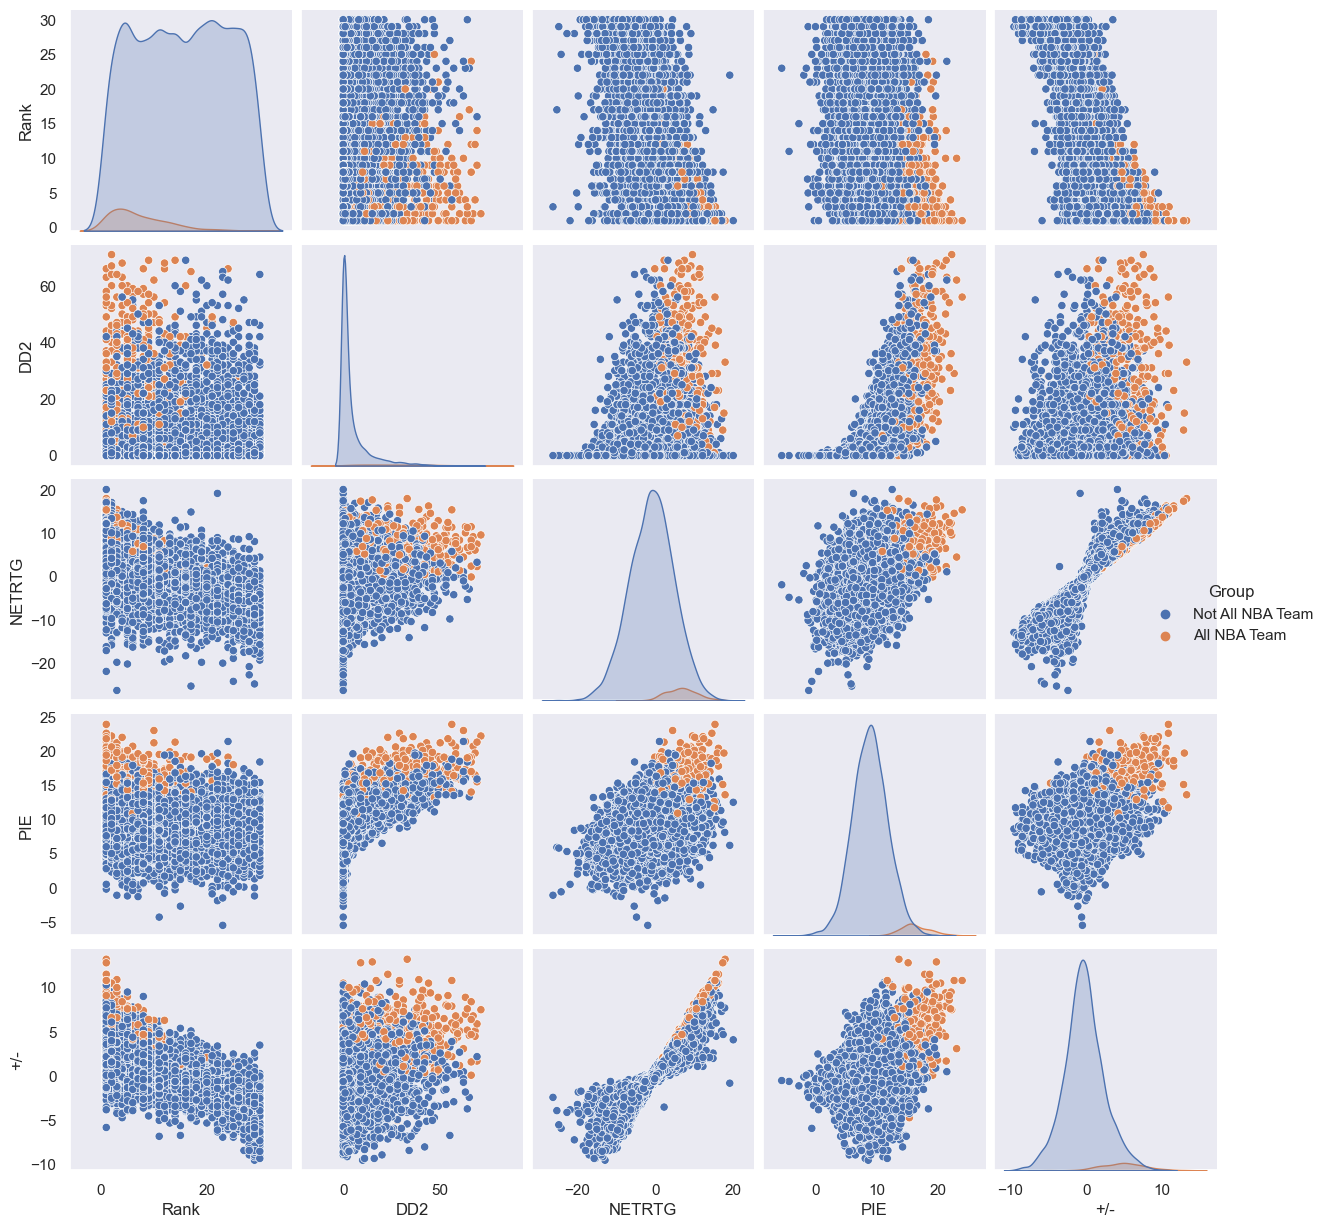

In [67]:
features = ['Rank', 'DD2', 'NETRTG', 'PIE', '+/-', 'Selected?']
ax = sns.pairplot(train_data[features], hue = 'Selected?')

ax._legend.set_title('Group')
new_legend = ['Not All NBA Team', 'All NBA Team']
for t, l in zip(ax._legend.texts, new_legend):
    t.set_text(l)
plt.show()

Unfortunately, it is hard to observe any obvious decision boundary between two groups. 

Finally, we can try **PCA** to observe whether it is possible to classify these two groups.

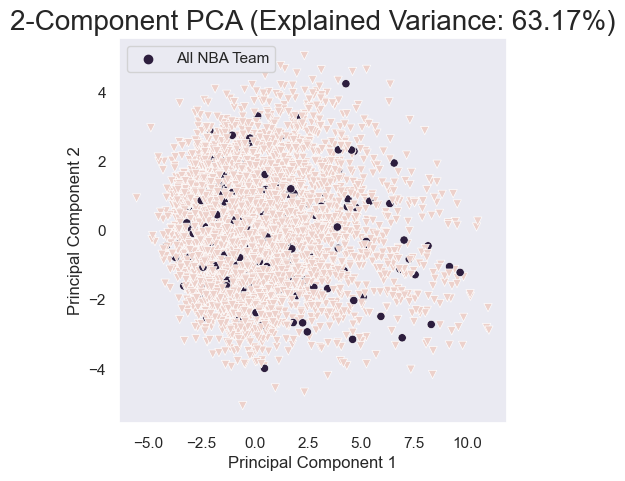

In [90]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(train_data[selected_features])

pca = PCA(n_components = 2)
components = pca.fit_transform(X_train_scaled)

df_pca = pd.DataFrame(data = components, columns = ['Principal Component 1', 'Principal Component 2'])
df_pca['Group'] = y_train

fig, ax = plt.subplots(figsize=(5,5))

sns.scatterplot(data = df_pca, x = 'Principal Component 1', y = 'Principal Component 2', hue = 'Group',
                markers = ['v', 'o'], style = 'Group')

explained_variance = 100 * sum(pca.explained_variance_ratio_)
ax.set_title('2-Component PCA (Explained Variance: {:.2f}%)'.format(explained_variance),
             size=20)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['All NBA Team', 'Not All NBA Team'])
plt.show()

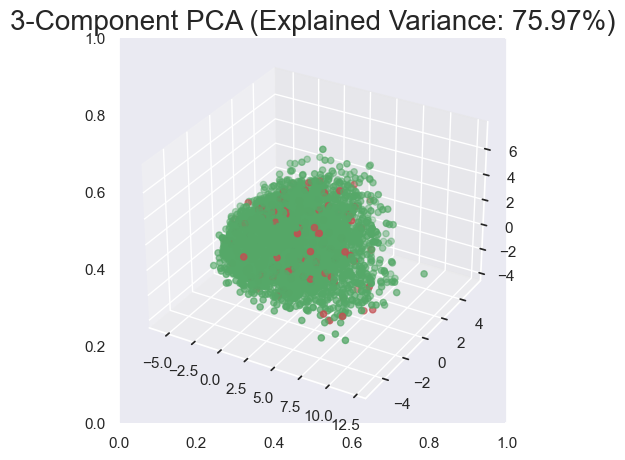

In [69]:
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(train_data[selected_features])

pca = PCA(n_components = 3)
components = pca.fit_transform(X_train_scaled)

df_pca = pd.DataFrame(data = components, columns = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
df_pca['Group'] = y_train

fig, ax = plt.subplots(figsize=(5,5))
ax = fig.add_subplot(111, projection = '3d')

colors = np.where(df_pca["Group"]==1,'r','g')

ax.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'], df_pca['Principal Component 3'], 
          c = colors)

explained_variance = 100 * sum(pca.explained_variance_ratio_)
ax.set_title('3-Component PCA (Explained Variance: {:.2f}%)'.format(explained_variance),
             size=20)
plt.show()

It is hard to observe pattern between groups. These may be caused by the existence of inessential features or other reasons. 

As a reminder, the result of PCA only represents that the dataset is not suitable for using PCA, it doesn't mean that these two groups are unable to be classified.

# Modeling

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_data[selected_features], 
                                                      train_data['Selected?'], 
                                                      test_size = 0.3,
                                                      random_state = 2)

## Problem: Imbalanced dataset

In [71]:
num_minor_class = y_train.sum()
num_major_class = y_train.count() - y_train.sum()
num_train = y_train.count()

num_major_class, num_minor_class, num_major_class / num_train * 100

(5760, 258, 95.71286141575274)

When dealing with classification problem, one problem is **the balance of classes**. If the classes are imbalanced, the model will develop an inherent bias towards the majority class, which we definitely want to avoid.

In our training set, we have 257 All NBA Team players and 5761 non All NBA Team players. Even if we label every player as an All NBA Team player, we still achieve 95.73% accuracy. Therefore, we need to balance these two classes in order to train a unbiased model.

We have three options:
1. undersample the majority class (drop data points)
2. oversample the minority class 
3. combination of option 1 and 2.

Option 2 is the one we choose. For option 2, we can simply random sampling the attributes from instances in the minority class.  However, the non-linear relationships between the attributes may not be preserved.

There is another choice, **SMOTE** (Synthetic Monority Over-sampling Technique), generating new minority class data by creating synthetic data points.

The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances. 

I select ***BorderlineSMOTE*** from ***imblearn*** library to oversample the class. This method samples near of the border of the optimal decision function to synthesize new data points.

In [72]:
from imblearn.over_sampling import BorderlineSMOTE

X_train_oversampled, y_train_oversampled = BorderlineSMOTE(random_state=0).fit_sample(X_train, y_train)

y_train_oversampled.sum(), y_train_oversampled.count()

(5760, 11520)

In general, decision tree based algorithm are more suitable for tabular/unstructured data, while neural networks are more suitable for unstructured data. 

Since this dataset is tabular and doesn't require complicated probability calculations, we will experiment several popular decision tree based algorithms and select one model among them.

## Model: LightGBM

The decision tree based algorithm that we will call is LightGBM, a popular implementation of gradeint boosted decision tree. There are several hyperparameters that will control the learning process, such as learning rate and maximum tree depth. We will apply a grid search to find the optimal setup, and use early stopping with patience parameter 10 for the sake of avoid overfitting. 

As for evaluation metric, we use **AUC score**. AUC is an evaluation  metric for binary classification problem. It means area under curve, specifically the ROC curve. The ROC compares TPR (true positive rate) and FPR (false positive rate) at different threshold, illustrating a classifier's diagnostic ability at different levels of discrimination. AUC has a value between 0 and 1, which we will expect to achieve an AUC as close to 1 as possible.

**In conclusion, our training process is following:**
1. Select one learning rate without replacement.
2. Train LightGBM using this learning rate.
3. Stop when validation AUC score doesn't improve after 10 epochs. 
4. Record the learning rate with its highest AUC in this round.
5. Return to Step 1.

In [73]:
# Parameters for model
learning_rates = np.arange(10**(-2), 1, 10**(-2)).tolist()
n_estimators_list = np.arange(500, 2100, 100).tolist()
max_depth = 2

# Parameters for training the model
eval_metric = ['error', 'auc']
eval_set = [(X_valid, y_valid)]
early_stopping_rounds = 10

best_learning_rate, best_n_estimator = learning_rates[0], n_estimators_list[0]
highest_auc = -float('inf')

In [74]:
import lightgbm as lgbm

for learning_rate in learning_rates:
    for n_estimator in n_estimators_list:
        model = lgbm.LGBMClassifier(max_depth = max_depth, learning_rate = learning_rate, 
                                    n_estimators = n_estimator, random_state = 0)
        model.fit(X = X_train_oversampled, y = y_train_oversampled, eval_metric = eval_metric, 
                  eval_set = eval_set, early_stopping_rounds = early_stopping_rounds, verbose = True)
        
        curr_auc = max(model.evals_result_['valid_0']['auc'])
        if curr_auc > highest_auc:
            highest_auc, best_learning_rate, best_n_estimator = curr_auc, learning_rate, n_estimator

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.685022
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.677067
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.669277
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.661647
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.654172
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.646849
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.639673
[8]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.632641
[9]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.625747
[10]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	val

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.685022
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.677067
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.669277
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.661647
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.654172
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.646849
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.639673
[8]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.632641
[9]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.625747
[10]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	val

[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.618677
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.605512
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.592781
[8]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.580529
[9]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.568784
[10]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.96543	valid_0's binary_logloss: 0.557416
[11]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.96543	valid_0's binary_logloss: 0.546512
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.676988
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.676988
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.676988
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.661498
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.646639
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.632376
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.618677
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.605512
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.592781
[8]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.580529
[9]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.568784
[10]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.96543	vali

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.669044
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.646425
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.625164
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.605152
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.586182
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.568357
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.96543	valid_0's binary_logloss: 0.551421
[8]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.96543	valid_0's binary_logloss: 0.535399
[9]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965445	valid_0's binary_logloss: 0.520701
[10]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965445	valid

[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.646425
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.625164
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.605152
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.586182
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.568357
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.96543	valid_0's binary_logloss: 0.551421
[8]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.96543	valid_0's binary_logloss: 0.535399
[9]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965445	valid_0's binary_logloss: 0.520701
[10]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965445	valid_0's binary_logloss: 0.506265
[11]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965373	valid_0's binary_logloss: 0.493053
Early stopping, best iteration

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.661191
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.631833
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.604786
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.579662
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.556503
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.96543	valid_0's binary_logloss: 0.534896
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965378	valid_0's binary_logloss: 0.515458
[8]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965441	valid_0's binary_logloss: 0.496665
[9]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965441	valid_0's binary_logloss: 0.479153
[10]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.967046	vali

[23]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.98266	valid_0's binary_logloss: 0.321809
[24]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983668	valid_0's binary_logloss: 0.313948
[25]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983656	valid_0's binary_logloss: 0.307561
[26]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983899	valid_0's binary_logloss: 0.300424
[27]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.984141	valid_0's binary_logloss: 0.294374
[28]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.984185	valid_0's binary_logloss: 0.288263
[29]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.98395	valid_0's binary_logloss: 0.283109
[30]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983895	valid_0's binary_logloss: 0.277559
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.98204	valid_0's binary_logloss: 0.345738
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss

[30]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983895	valid_0's binary_logloss: 0.277559
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.98204	valid_0's binary_logloss: 0.345738
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.661191
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.631833
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.604786
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.579662
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.556503
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.96543	valid_0's binary_logloss: 0.534896
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965378	valid_0's binary_logloss: 0.515458
[8]	valid_0's binary_error: 0.0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.661191
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.631833
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.604786
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.579662
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.556503
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.96543	valid_0's binary_logloss: 0.534896
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965378	valid_0's binary_logloss: 0.515458
[8]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965441	valid_0's binary_logloss: 0.496665
[9]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965441	valid_0's binary_logloss: 0.479153
[10]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.967046	vali

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.661191
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.631833
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.604786
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.579662
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.556503
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.96543	valid_0's binary_logloss: 0.534896
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965378	valid_0's binary_logloss: 0.515458
[8]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965441	valid_0's binary_logloss: 0.496665
[9]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965441	valid_0's binary_logloss: 0.479153
[10]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.967046	vali

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.653429
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.617708
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.585445
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.555989
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.529185
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965378	valid_0's binary_logloss: 0.505486
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965441	valid_0's binary_logloss: 0.482969
[8]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.966725	valid_0's binary_logloss: 0.463218
[9]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.966746	valid_0's binary_logloss: 0.444182
[10]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.967072	val

[26]	valid_0's binary_error: 0.072093	valid_0's auc: 0.983958	valid_0's binary_logloss: 0.265078
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.982188	valid_0's binary_logloss: 0.345492
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.653429
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.617708
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.585445
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.555989
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.529185
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965378	valid_0's binary_logloss: 0.505486
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965441	valid_0's binary_logloss: 0.482969
[8]	valid_0's binary_error: 0.

[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.585445
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.555989
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.529185
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965378	valid_0's binary_logloss: 0.505486
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965441	valid_0's binary_logloss: 0.482969
[8]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.966725	valid_0's binary_logloss: 0.463218
[9]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.966746	valid_0's binary_logloss: 0.444182
[10]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.967072	valid_0's binary_logloss: 0.427517
[11]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.966928	valid_0's binary_logloss: 0.411276
[12]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.971198	valid_0's binary_logloss: 0.39578
[13]	valid_0's binary_error:

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.653429
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.617708
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.585445
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965358	valid_0's binary_logloss: 0.555989
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.529185
[6]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965378	valid_0's binary_logloss: 0.505486
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965441	valid_0's binary_logloss: 0.482969
[8]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.966725	valid_0's binary_logloss: 0.463218
[9]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.966746	valid_0's binary_logloss: 0.444182
[10]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.967072	val

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.645757
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.604036
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.566856
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.533877
[5]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.505196
[6]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965373	valid_0's binary_logloss: 0.478328
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965407	valid_0's binary_logloss: 0.454204
[8]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.966686	valid_0's binary_logloss: 0.433265
[9]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.967072	valid_0's binary_logloss: 0.413523
[10]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.967017	val

[20]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983798	valid_0's binary_logloss: 0.276527
[21]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.984119	valid_0's binary_logloss: 0.269205
[22]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984414	valid_0's binary_logloss: 0.261824
[23]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.984323	valid_0's binary_logloss: 0.255508
[24]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984126	valid_0's binary_logloss: 0.250084
[25]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984007	valid_0's binary_logloss: 0.244168
[26]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984151	valid_0's binary_logloss: 0.238041
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983634	valid_0's binary_logloss: 0.312977
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.645757
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error:

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.645757
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.604036
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.566856
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.533877
[5]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.505196
[6]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965373	valid_0's binary_logloss: 0.478328
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965407	valid_0's binary_logloss: 0.454204
[8]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.966686	valid_0's binary_logloss: 0.433265
[9]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.967072	valid_0's binary_logloss: 0.413523
[10]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.967017	val

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.645757
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.604036
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.566856
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.533877
[5]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.505196
[6]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965373	valid_0's binary_logloss: 0.478328
[7]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965407	valid_0's binary_logloss: 0.454204
[8]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.966686	valid_0's binary_logloss: 0.433265
[9]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.967072	valid_0's binary_logloss: 0.413523
[10]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.967017	val

[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.549356
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.51326
[5]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.482313
[6]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965022	valid_0's binary_logloss: 0.453852
[7]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.966767	valid_0's binary_logloss: 0.42968
[8]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.966686	valid_0's binary_logloss: 0.406882
[9]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.971138	valid_0's binary_logloss: 0.385866
[10]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.971206	valid_0's binary_logloss: 0.368491
[11]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.981694	valid_0's binary_logloss: 0.350873
[12]	valid_0's binary_error: 0.075969	valid_0's auc: 0.981957	valid_0's binary_logloss: 0.336196
[13]	valid_0's binary_error: 0

[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.590804
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.549356
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.51326
[5]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.482313
[6]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965022	valid_0's binary_logloss: 0.453852
[7]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.966767	valid_0's binary_logloss: 0.42968
[8]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.966686	valid_0's binary_logloss: 0.406882
[9]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.971138	valid_0's binary_logloss: 0.385866
[10]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.971206	valid_0's binary_logloss: 0.368491
[11]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.981694	valid_0's binary_logloss: 0.350873
[12]	valid_0's binary_error: 0

[20]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.983855	valid_0's binary_logloss: 0.253658
[21]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.983876	valid_0's binary_logloss: 0.246596
[22]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.9842	valid_0's binary_logloss: 0.239283
[23]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.985719	valid_0's binary_logloss: 0.23344
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.982527	valid_0's binary_logloss: 0.321715
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.638176
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.590804
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.549356
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965363	valid_0's binary_logloss: 0.51326
[5]	valid_0's binary_error: 0.

[6]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965022	valid_0's binary_logloss: 0.453852
[7]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.966767	valid_0's binary_logloss: 0.42968
[8]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.966686	valid_0's binary_logloss: 0.406882
[9]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.971138	valid_0's binary_logloss: 0.385866
[10]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.971206	valid_0's binary_logloss: 0.368491
[11]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.981694	valid_0's binary_logloss: 0.350873
[12]	valid_0's binary_error: 0.075969	valid_0's auc: 0.981957	valid_0's binary_logloss: 0.336196
[13]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.982527	valid_0's binary_logloss: 0.321715
[14]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.982328	valid_0's binary_logloss: 0.31005
[15]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983719	valid_0's binary_logloss: 0.297497
[16]	valid_0's binary_error

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.630685
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.577998
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.532726
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.495075
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965123	valid_0's binary_logloss: 0.460978
[6]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.967046	valid_0's binary_logloss: 0.431532
[7]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.967114	valid_0's binary_logloss: 0.406718
[8]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.971331	valid_0's binary_logloss: 0.382743
[9]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.981322	valid_0's binary_logloss: 0.362789
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.98191	vali

[11]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.981745	valid_0's binary_logloss: 0.328163
[12]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.982201	valid_0's binary_logloss: 0.31262
[13]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983715	valid_0's binary_logloss: 0.298171
[14]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983465	valid_0's binary_logloss: 0.287123
[15]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.984045	valid_0's binary_logloss: 0.275739
[16]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.984219	valid_0's binary_logloss: 0.266081
[17]	valid_0's binary_error: 0.072093	valid_0's auc: 0.98581	valid_0's binary_logloss: 0.257214
[18]	valid_0's binary_error: 0.072093	valid_0's auc: 0.985585	valid_0's binary_logloss: 0.248635
[19]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.985541	valid_0's binary_logloss: 0.242219
[20]	valid_0's binary_error: 0.072093	valid_0's auc: 0.985611	valid_0's binary_logloss: 0.234569
[21]	valid_0's binary_err

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.630685
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.577998
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.532726
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.495075
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965123	valid_0's binary_logloss: 0.460978
[6]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.967046	valid_0's binary_logloss: 0.431532
[7]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.967114	valid_0's binary_logloss: 0.406718
[8]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.971331	valid_0's binary_logloss: 0.382743
[9]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.981322	valid_0's binary_logloss: 0.362789
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.98191	vali

[12]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.982201	valid_0's binary_logloss: 0.31262
[13]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983715	valid_0's binary_logloss: 0.298171
[14]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983465	valid_0's binary_logloss: 0.287123
[15]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.984045	valid_0's binary_logloss: 0.275739
[16]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.984219	valid_0's binary_logloss: 0.266081
[17]	valid_0's binary_error: 0.072093	valid_0's auc: 0.98581	valid_0's binary_logloss: 0.257214
[18]	valid_0's binary_error: 0.072093	valid_0's auc: 0.985585	valid_0's binary_logloss: 0.248635
[19]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.985541	valid_0's binary_logloss: 0.242219
[20]	valid_0's binary_error: 0.072093	valid_0's auc: 0.985611	valid_0's binary_logloss: 0.234569
[21]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.986693	valid_0's binary_logloss: 0.227898
[22]	valid_0's binary_err

[37]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.990744	valid_0's binary_logloss: 0.149397
[38]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.990778	valid_0's binary_logloss: 0.148168
[39]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.990802	valid_0's binary_logloss: 0.145728
[40]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.990639	valid_0's binary_logloss: 0.143886
[41]	valid_0's binary_error: 0.0569767	valid_0's auc: 0.990736	valid_0's binary_logloss: 0.141738
[42]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.990584	valid_0's binary_logloss: 0.140493
[43]	valid_0's binary_error: 0.0569767	valid_0's auc: 0.99113	valid_0's binary_logloss: 0.138138
[44]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.99116	valid_0's binary_logloss: 0.136528
[45]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990969	valid_0's binary_logloss: 0.135305
[46]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.990744	valid_0's binary_logloss: 0.134581
[47]	valid_0's binary_

[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.565606
[3]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.516919
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.477075
[5]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965089	valid_0's binary_logloss: 0.441645
[6]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.96678	valid_0's binary_logloss: 0.412568
[7]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.97135	valid_0's binary_logloss: 0.385059
[8]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.980983	valid_0's binary_logloss: 0.361489
[9]	valid_0's binary_error: 0.075969	valid_0's auc: 0.981089	valid_0's binary_logloss: 0.342214
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.982167	valid_0's binary_logloss: 0.323096
[11]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.982298	valid_0's binary_logloss: 0.307516
[12]	valid_0's binary_error: 0.

[50]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.99124	valid_0's binary_logloss: 0.129945
[51]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.991121	valid_0's binary_logloss: 0.128848
[52]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990948	valid_0's binary_logloss: 0.127797
[53]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.991024	valid_0's binary_logloss: 0.126592
[54]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.991047	valid_0's binary_logloss: 0.125697
[55]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.9912	valid_0's binary_logloss: 0.124473
[56]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.991204	valid_0's binary_logloss: 0.123968
[57]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990971	valid_0's binary_logloss: 0.123227
[58]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990812	valid_0's binary_logloss: 0.122739
[59]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990982	valid_0's binary_logloss: 0.121719
[60]	valid_0's binary_er

[46]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.990744	valid_0's binary_logloss: 0.134581
[47]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990812	valid_0's binary_logloss: 0.133641
[48]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.990977	valid_0's binary_logloss: 0.132071
[49]	valid_0's binary_error: 0.053876	valid_0's auc: 0.991066	valid_0's binary_logloss: 0.131408
[50]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.99124	valid_0's binary_logloss: 0.129945
[51]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.991121	valid_0's binary_logloss: 0.128848
[52]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990948	valid_0's binary_logloss: 0.127797
[53]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.991024	valid_0's binary_logloss: 0.126592
[54]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.991047	valid_0's binary_logloss: 0.125697
[55]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.9912	valid_0's binary_logloss: 0.124473
[56]	valid_0's binary_er

[54]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.991047	valid_0's binary_logloss: 0.125697
[55]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.9912	valid_0's binary_logloss: 0.124473
[56]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.991204	valid_0's binary_logloss: 0.123968
[57]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990971	valid_0's binary_logloss: 0.123227
[58]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990812	valid_0's binary_logloss: 0.122739
[59]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990982	valid_0's binary_logloss: 0.121719
[60]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.991007	valid_0's binary_logloss: 0.121013
Early stopping, best iteration is:
[50]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.99124	valid_0's binary_logloss: 0.129945
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.623284
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error:

[42]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.990584	valid_0's binary_logloss: 0.140493
[43]	valid_0's binary_error: 0.0569767	valid_0's auc: 0.99113	valid_0's binary_logloss: 0.138138
[44]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.99116	valid_0's binary_logloss: 0.136528
[45]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990969	valid_0's binary_logloss: 0.135305
[46]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.990744	valid_0's binary_logloss: 0.134581
[47]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990812	valid_0's binary_logloss: 0.133641
[48]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.990977	valid_0's binary_logloss: 0.132071
[49]	valid_0's binary_error: 0.053876	valid_0's auc: 0.991066	valid_0's binary_logloss: 0.131408
[50]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.99124	valid_0's binary_logloss: 0.129945
[51]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.991121	valid_0's binary_logloss: 0.128848
[52]	valid_0's binary_er

[53]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.991024	valid_0's binary_logloss: 0.126592
[54]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.991047	valid_0's binary_logloss: 0.125697
[55]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.9912	valid_0's binary_logloss: 0.124473
[56]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.991204	valid_0's binary_logloss: 0.123968
[57]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990971	valid_0's binary_logloss: 0.123227
[58]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990812	valid_0's binary_logloss: 0.122739
[59]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990982	valid_0's binary_logloss: 0.121719
[60]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.991007	valid_0's binary_logloss: 0.121013
Early stopping, best iteration is:
[50]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.99124	valid_0's binary_logloss: 0.129945
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss:

[34]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.990361	valid_0's binary_logloss: 0.157145
[35]	valid_0's binary_error: 0.0612403	valid_0's auc: 0.990321	valid_0's binary_logloss: 0.154608
[36]	valid_0's binary_error: 0.0600775	valid_0's auc: 0.990647	valid_0's binary_logloss: 0.151946
[37]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.990744	valid_0's binary_logloss: 0.149397
[38]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.990778	valid_0's binary_logloss: 0.148168
[39]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.990802	valid_0's binary_logloss: 0.145728
[40]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.990639	valid_0's binary_logloss: 0.143886
[41]	valid_0's binary_error: 0.0569767	valid_0's auc: 0.990736	valid_0's binary_logloss: 0.141738
[42]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.990584	valid_0's binary_logloss: 0.140493
[43]	valid_0's binary_error: 0.0569767	valid_0's auc: 0.99113	valid_0's binary_logloss: 0.138138
[44]	valid_0's binary

[34]	valid_0's binary_error: 0.0600775	valid_0's auc: 0.99106	valid_0's binary_logloss: 0.147252
[35]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.990785	valid_0's binary_logloss: 0.145536
[36]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.99092	valid_0's binary_logloss: 0.142943
[37]	valid_0's binary_error: 0.0569767	valid_0's auc: 0.990672	valid_0's binary_logloss: 0.141255
[38]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.99127	valid_0's binary_logloss: 0.138402
[39]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.991191	valid_0's binary_logloss: 0.136838
[40]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.991187	valid_0's binary_logloss: 0.135158
[41]	valid_0's binary_error: 0.053876	valid_0's auc: 0.991365	valid_0's binary_logloss: 0.133227
[42]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.991251	valid_0's binary_logloss: 0.131812
[43]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.991462	valid_0's binary_logloss: 0.129906
[44]	valid_0's binary_er

[6]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.967072	valid_0's binary_logloss: 0.394406
[7]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.971581	valid_0's binary_logloss: 0.366476
[8]	valid_0's binary_error: 0.077907	valid_0's auc: 0.982021	valid_0's binary_logloss: 0.342067
[9]	valid_0's binary_error: 0.075969	valid_0's auc: 0.9818	valid_0's binary_logloss: 0.323249
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983128	valid_0's binary_logloss: 0.304045
[11]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983573	valid_0's binary_logloss: 0.288881
[12]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983762	valid_0's binary_logloss: 0.274767
[13]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984168	valid_0's binary_logloss: 0.262917
[14]	valid_0's binary_error: 0.074031	valid_0's auc: 0.985532	valid_0's binary_logloss: 0.252475
[15]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.98546	valid_0's binary_logloss: 0.242409
[16]	valid_0's binary_error: 0

[9]	valid_0's binary_error: 0.075969	valid_0's auc: 0.9818	valid_0's binary_logloss: 0.323249
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983128	valid_0's binary_logloss: 0.304045
[11]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983573	valid_0's binary_logloss: 0.288881
[12]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983762	valid_0's binary_logloss: 0.274767
[13]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984168	valid_0's binary_logloss: 0.262917
[14]	valid_0's binary_error: 0.074031	valid_0's auc: 0.985532	valid_0's binary_logloss: 0.252475
[15]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.98546	valid_0's binary_logloss: 0.242409
[16]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.985369	valid_0's binary_logloss: 0.234998
[17]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.985473	valid_0's binary_logloss: 0.226298
[18]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.985653	valid_0's binary_logloss: 0.218684
[19]	valid_0's binary_erro

[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983128	valid_0's binary_logloss: 0.304045
[11]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983573	valid_0's binary_logloss: 0.288881
[12]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983762	valid_0's binary_logloss: 0.274767
[13]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984168	valid_0's binary_logloss: 0.262917
[14]	valid_0's binary_error: 0.074031	valid_0's auc: 0.985532	valid_0's binary_logloss: 0.252475
[15]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.98546	valid_0's binary_logloss: 0.242409
[16]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.985369	valid_0's binary_logloss: 0.234998
[17]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.985473	valid_0's binary_logloss: 0.226298
[18]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.985653	valid_0's binary_logloss: 0.218684
[19]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.98582	valid_0's binary_logloss: 0.2109
[20]	valid_0's binary_err

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.615974
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.553249
[3]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.96543	valid_0's binary_logloss: 0.501837
[4]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.460156
[5]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.967046	valid_0's binary_logloss: 0.423829
[6]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.967072	valid_0's binary_logloss: 0.394406
[7]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.971581	valid_0's binary_logloss: 0.366476
[8]	valid_0's binary_error: 0.077907	valid_0's auc: 0.982021	valid_0's binary_logloss: 0.342067
[9]	valid_0's binary_error: 0.075969	valid_0's auc: 0.9818	valid_0's binary_logloss: 0.323249
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983128	valid_0'

[7]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.971581	valid_0's binary_logloss: 0.366476
[8]	valid_0's binary_error: 0.077907	valid_0's auc: 0.982021	valid_0's binary_logloss: 0.342067
[9]	valid_0's binary_error: 0.075969	valid_0's auc: 0.9818	valid_0's binary_logloss: 0.323249
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983128	valid_0's binary_logloss: 0.304045
[11]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983573	valid_0's binary_logloss: 0.288881
[12]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983762	valid_0's binary_logloss: 0.274767
[13]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984168	valid_0's binary_logloss: 0.262917
[14]	valid_0's binary_error: 0.074031	valid_0's auc: 0.985532	valid_0's binary_logloss: 0.252475
[15]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.98546	valid_0's binary_logloss: 0.242409
[16]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.985369	valid_0's binary_logloss: 0.234998
[17]	valid_0's binary_error: 

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.615974
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.553249
[3]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.96543	valid_0's binary_logloss: 0.501837
[4]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.460156
[5]	valid_0's binary_error: 0.0841085	valid_0's auc: 0.967046	valid_0's binary_logloss: 0.423829
[6]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.967072	valid_0's binary_logloss: 0.394406
[7]	valid_0's binary_error: 0.0829457	valid_0's auc: 0.971581	valid_0's binary_logloss: 0.366476
[8]	valid_0's binary_error: 0.077907	valid_0's auc: 0.982021	valid_0's binary_logloss: 0.342067
[9]	valid_0's binary_error: 0.075969	valid_0's auc: 0.9818	valid_0's binary_logloss: 0.323249
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983128	valid_0'

[14]	valid_0's binary_error: 0.074031	valid_0's auc: 0.985532	valid_0's binary_logloss: 0.252475
[15]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.98546	valid_0's binary_logloss: 0.242409
[16]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.985369	valid_0's binary_logloss: 0.234998
[17]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.985473	valid_0's binary_logloss: 0.226298
[18]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.985653	valid_0's binary_logloss: 0.218684
[19]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.98582	valid_0's binary_logloss: 0.2109
[20]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.985994	valid_0's binary_logloss: 0.204416
[21]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.986953	valid_0's binary_logloss: 0.198756
[22]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.987157	valid_0's binary_logloss: 0.192764
[23]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987038	valid_0's binary_logloss: 0.187797
[24]	valid_0's binary_err

[20]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.988288	valid_0's binary_logloss: 0.193315
[21]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.988843	valid_0's binary_logloss: 0.188077
[22]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.989135	valid_0's binary_logloss: 0.182478
[23]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.989472	valid_0's binary_logloss: 0.177518
[24]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.988927	valid_0's binary_logloss: 0.173851
[25]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.989493	valid_0's binary_logloss: 0.168716
[26]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.990304	valid_0's binary_logloss: 0.164572
[27]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.990067	valid_0's binary_logloss: 0.161186
[28]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.989959	valid_0's binary_logloss: 0.158008
[29]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.990226	valid_0's binary_logloss: 0.154538
[30]	valid_0's binar

[19]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.987737	valid_0's binary_logloss: 0.20032
[20]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.988288	valid_0's binary_logloss: 0.193315
[21]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.988843	valid_0's binary_logloss: 0.188077
[22]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.989135	valid_0's binary_logloss: 0.182478
[23]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.989472	valid_0's binary_logloss: 0.177518
[24]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.988927	valid_0's binary_logloss: 0.173851
[25]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.989493	valid_0's binary_logloss: 0.168716
[26]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.990304	valid_0's binary_logloss: 0.164572
[27]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.990067	valid_0's binary_logloss: 0.161186
[28]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.989959	valid_0's binary_logloss: 0.158008
[29]	valid_0's binary

[10]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.983978	valid_0's binary_logloss: 0.287906
[11]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983867	valid_0's binary_logloss: 0.274277
[12]	valid_0's binary_error: 0.072093	valid_0's auc: 0.983956	valid_0's binary_logloss: 0.260538
[13]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.984054	valid_0's binary_logloss: 0.249556
[14]	valid_0's binary_error: 0.072093	valid_0's auc: 0.983829	valid_0's binary_logloss: 0.239024
[15]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984242	valid_0's binary_logloss: 0.228718
[16]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.984448	valid_0's binary_logloss: 0.219091
[17]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.986636	valid_0's binary_logloss: 0.212197
[18]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.986557	valid_0's binary_logloss: 0.205383
[19]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.987737	valid_0's binary_logloss: 0.20032
[20]	valid_0's binary_er

[48]	valid_0's binary_error: 0.05	valid_0's auc: 0.991081	valid_0's binary_logloss: 0.120971
[49]	valid_0's binary_error: 0.05	valid_0's auc: 0.991035	valid_0's binary_logloss: 0.119978
[50]	valid_0's binary_error: 0.05	valid_0's auc: 0.990958	valid_0's binary_logloss: 0.119193
[51]	valid_0's binary_error: 0.05	valid_0's auc: 0.991094	valid_0's binary_logloss: 0.118062
[52]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991225	valid_0's binary_logloss: 0.11698
[53]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991138	valid_0's binary_logloss: 0.116066
[54]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.991164	valid_0's binary_logloss: 0.115203
[55]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.991196	valid_0's binary_logloss: 0.114482
[56]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.991141	valid_0's binary_logloss: 0.11419
Early stopping, best iteration is:
[46]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991359	valid_0's binary_logloss: 0.122667
[1]	val

[52]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991225	valid_0's binary_logloss: 0.11698
[53]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991138	valid_0's binary_logloss: 0.116066
[54]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.991164	valid_0's binary_logloss: 0.115203
[55]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.991196	valid_0's binary_logloss: 0.114482
[56]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.991141	valid_0's binary_logloss: 0.11419
Early stopping, best iteration is:
[46]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991359	valid_0's binary_logloss: 0.122667
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.608753
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.541584
[3]	valid_0's binary_error: 0.0794574	valid_0's auc: 0.965198	valid_0's binary_logloss: 0.4882
[4]	valid_0's binary_error: 0

[8]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981845	valid_0's binary_logloss: 0.325864
[9]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.982035	valid_0's binary_logloss: 0.306697
[10]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.983978	valid_0's binary_logloss: 0.287906
[11]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983867	valid_0's binary_logloss: 0.274277
[12]	valid_0's binary_error: 0.072093	valid_0's auc: 0.983956	valid_0's binary_logloss: 0.260538
[13]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.984054	valid_0's binary_logloss: 0.249556
[14]	valid_0's binary_error: 0.072093	valid_0's auc: 0.983829	valid_0's binary_logloss: 0.239024
[15]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984242	valid_0's binary_logloss: 0.228718
[16]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.984448	valid_0's binary_logloss: 0.219091
[17]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.986636	valid_0's binary_logloss: 0.212197
[18]	valid_0's binary_erro

[11]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983867	valid_0's binary_logloss: 0.274277
[12]	valid_0's binary_error: 0.072093	valid_0's auc: 0.983956	valid_0's binary_logloss: 0.260538
[13]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.984054	valid_0's binary_logloss: 0.249556
[14]	valid_0's binary_error: 0.072093	valid_0's auc: 0.983829	valid_0's binary_logloss: 0.239024
[15]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984242	valid_0's binary_logloss: 0.228718
[16]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.984448	valid_0's binary_logloss: 0.219091
[17]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.986636	valid_0's binary_logloss: 0.212197
[18]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.986557	valid_0's binary_logloss: 0.205383
[19]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.987737	valid_0's binary_logloss: 0.20032
[20]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.988288	valid_0's binary_logloss: 0.193315
[21]	valid_0's binary_er

[20]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.988288	valid_0's binary_logloss: 0.193315
[21]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.988843	valid_0's binary_logloss: 0.188077
[22]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.989135	valid_0's binary_logloss: 0.182478
[23]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.989472	valid_0's binary_logloss: 0.177518
[24]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.988927	valid_0's binary_logloss: 0.173851
[25]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.989493	valid_0's binary_logloss: 0.168716
[26]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.990304	valid_0's binary_logloss: 0.164572
[27]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.990067	valid_0's binary_logloss: 0.161186
[28]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.989959	valid_0's binary_logloss: 0.158008
[29]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.990226	valid_0's binary_logloss: 0.154538
[30]	valid_0's binar

[14]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.986468	valid_0's binary_logloss: 0.226622
[15]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.986053	valid_0's binary_logloss: 0.216861
[16]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.986356	valid_0's binary_logloss: 0.208299
[17]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.986168	valid_0's binary_logloss: 0.201294
[18]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.986729	valid_0's binary_logloss: 0.193498
[19]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.98729	valid_0's binary_logloss: 0.188412
[20]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.988279	valid_0's binary_logloss: 0.182447
[21]	valid_0's binary_error: 0.0655039	valid_0's auc: 0.988815	valid_0's binary_logloss: 0.177069
[22]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.989455	valid_0's binary_logloss: 0.171817
[23]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989577	valid_0's binary_logloss: 0.167355
[24]	valid_0's binary

[41]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.990963	valid_0's binary_logloss: 0.123574
[42]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.990954	valid_0's binary_logloss: 0.123044
[43]	valid_0's binary_error: 0.05	valid_0's auc: 0.991132	valid_0's binary_logloss: 0.121723
[44]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.991037	valid_0's binary_logloss: 0.120699
[45]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.991236	valid_0's binary_logloss: 0.11936
Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.991327	valid_0's binary_logloss: 0.132349
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.601622
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.530293
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.475563
[4]	valid_0's binary_error: 0.07

[20]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.988279	valid_0's binary_logloss: 0.182447
[21]	valid_0's binary_error: 0.0655039	valid_0's auc: 0.988815	valid_0's binary_logloss: 0.177069
[22]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.989455	valid_0's binary_logloss: 0.171817
[23]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989577	valid_0's binary_logloss: 0.167355
[24]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.990139	valid_0's binary_logloss: 0.163047
[25]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989952	valid_0's binary_logloss: 0.159485
[26]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.990353	valid_0's binary_logloss: 0.155369
[27]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.990539	valid_0's binary_logloss: 0.153422
[28]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.990403	valid_0's binary_logloss: 0.150582
[29]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.990645	valid_0's binary_logloss: 0.1467
[30]	valid_0's binary_

[43]	valid_0's binary_error: 0.05	valid_0's auc: 0.991132	valid_0's binary_logloss: 0.121723
[44]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.991037	valid_0's binary_logloss: 0.120699
[45]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.991236	valid_0's binary_logloss: 0.11936
Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.991327	valid_0's binary_logloss: 0.132349
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.601622
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.530293
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.475563
[4]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.965089	valid_0's binary_logloss: 0.429396
[5]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.966928	valid_0's binary_logloss: 0.393551
[6]	valid_0's binary_error: 0.0709

[19]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.98729	valid_0's binary_logloss: 0.188412
[20]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.988279	valid_0's binary_logloss: 0.182447
[21]	valid_0's binary_error: 0.0655039	valid_0's auc: 0.988815	valid_0's binary_logloss: 0.177069
[22]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.989455	valid_0's binary_logloss: 0.171817
[23]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989577	valid_0's binary_logloss: 0.167355
[24]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.990139	valid_0's binary_logloss: 0.163047
[25]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989952	valid_0's binary_logloss: 0.159485
[26]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.990353	valid_0's binary_logloss: 0.155369
[27]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.990539	valid_0's binary_logloss: 0.153422
[28]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.990403	valid_0's binary_logloss: 0.150582
[29]	valid_0's binary

[18]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.986729	valid_0's binary_logloss: 0.193498
[19]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.98729	valid_0's binary_logloss: 0.188412
[20]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.988279	valid_0's binary_logloss: 0.182447
[21]	valid_0's binary_error: 0.0655039	valid_0's auc: 0.988815	valid_0's binary_logloss: 0.177069
[22]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.989455	valid_0's binary_logloss: 0.171817
[23]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989577	valid_0's binary_logloss: 0.167355
[24]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.990139	valid_0's binary_logloss: 0.163047
[25]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989952	valid_0's binary_logloss: 0.159485
[26]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.990353	valid_0's binary_logloss: 0.155369
[27]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.990539	valid_0's binary_logloss: 0.153422
[28]	valid_0's binary

[37]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991119	valid_0's binary_logloss: 0.129155
[38]	valid_0's binary_error: 0.051938	valid_0's auc: 0.991208	valid_0's binary_logloss: 0.127248
[39]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.991026	valid_0's binary_logloss: 0.126249
[40]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.991069	valid_0's binary_logloss: 0.12491
[41]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.990963	valid_0's binary_logloss: 0.123574
[42]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.990954	valid_0's binary_logloss: 0.123044
[43]	valid_0's binary_error: 0.05	valid_0's auc: 0.991132	valid_0's binary_logloss: 0.121723
[44]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.991037	valid_0's binary_logloss: 0.120699
[45]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.991236	valid_0's binary_logloss: 0.11936
Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.991327	valid_0's binary_logloss: 0.

[16]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.98639	valid_0's binary_logloss: 0.201185
[17]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.986941	valid_0's binary_logloss: 0.192366
[18]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.986801	valid_0's binary_logloss: 0.185928
[19]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.987157	valid_0's binary_logloss: 0.179601
[20]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.987656	valid_0's binary_logloss: 0.174187
[21]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.988967	valid_0's binary_logloss: 0.168851
[22]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.989114	valid_0's binary_logloss: 0.16408
[23]	valid_0's binary_error: 0.0612403	valid_0's auc: 0.98977	valid_0's binary_logloss: 0.159056
[24]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989717	valid_0's binary_logloss: 0.15546
[25]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.990293	valid_0's binary_logloss: 0.151705
[26]	valid_0's binary_er

[35]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.991075	valid_0's binary_logloss: 0.128924
[36]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.990842	valid_0's binary_logloss: 0.127471
[37]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.991126	valid_0's binary_logloss: 0.125528
[38]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990857	valid_0's binary_logloss: 0.124791
[39]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.990761	valid_0's binary_logloss: 0.123597
[40]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.990956	valid_0's binary_logloss: 0.122032
[41]	valid_0's binary_error: 0.05	valid_0's auc: 0.990846	valid_0's binary_logloss: 0.12085
[42]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990664	valid_0's binary_logloss: 0.119709
[43]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.990634	valid_0's binary_logloss: 0.118769
[44]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990715	valid_0's binary_logloss: 0.117776
[45]	valid_0's binary_error

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.59458
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.519364
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.462633
[4]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.966729	valid_0's binary_logloss: 0.415706
[5]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.96697	valid_0's binary_logloss: 0.379772
[6]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.973038	valid_0's binary_logloss: 0.346177
[7]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.982139	valid_0's binary_logloss: 0.318652
[8]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.98216	valid_0's binary_logloss: 0.297343
[9]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.983768	valid_0's binary_logloss: 0.277933
[10]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983539	valid_0

[15]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.986445	valid_0's binary_logloss: 0.20854
[16]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.98639	valid_0's binary_logloss: 0.201185
[17]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.986941	valid_0's binary_logloss: 0.192366
[18]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.986801	valid_0's binary_logloss: 0.185928
[19]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.987157	valid_0's binary_logloss: 0.179601
[20]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.987656	valid_0's binary_logloss: 0.174187
[21]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.988967	valid_0's binary_logloss: 0.168851
[22]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.989114	valid_0's binary_logloss: 0.16408
[23]	valid_0's binary_error: 0.0612403	valid_0's auc: 0.98977	valid_0's binary_logloss: 0.159056
[24]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989717	valid_0's binary_logloss: 0.15546
[25]	valid_0's binary_err

[38]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990857	valid_0's binary_logloss: 0.124791
[39]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.990761	valid_0's binary_logloss: 0.123597
[40]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.990956	valid_0's binary_logloss: 0.122032
[41]	valid_0's binary_error: 0.05	valid_0's auc: 0.990846	valid_0's binary_logloss: 0.12085
[42]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990664	valid_0's binary_logloss: 0.119709
[43]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.990634	valid_0's binary_logloss: 0.118769
[44]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990715	valid_0's binary_logloss: 0.117776
[45]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990526	valid_0's binary_logloss: 0.11677
[46]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990575	valid_0's binary_logloss: 0.115656
[47]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990656	valid_0's binary_logloss: 0.114238
Early stopping, best iteratio

[16]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.98639	valid_0's binary_logloss: 0.201185
[17]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.986941	valid_0's binary_logloss: 0.192366
[18]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.986801	valid_0's binary_logloss: 0.185928
[19]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.987157	valid_0's binary_logloss: 0.179601
[20]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.987656	valid_0's binary_logloss: 0.174187
[21]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.988967	valid_0's binary_logloss: 0.168851
[22]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.989114	valid_0's binary_logloss: 0.16408
[23]	valid_0's binary_error: 0.0612403	valid_0's auc: 0.98977	valid_0's binary_logloss: 0.159056
[24]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989717	valid_0's binary_logloss: 0.15546
[25]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.990293	valid_0's binary_logloss: 0.151705
[26]	valid_0's binary_er

[25]	valid_0's binary_error: 0.0573643	valid_0's auc: 0.990041	valid_0's binary_logloss: 0.146816
[26]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.990018	valid_0's binary_logloss: 0.143873
[27]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990939	valid_0's binary_logloss: 0.139722
[28]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.99085	valid_0's binary_logloss: 0.138387
[29]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.991071	valid_0's binary_logloss: 0.135729
[30]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.991187	valid_0's binary_logloss: 0.133187
[31]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.991162	valid_0's binary_logloss: 0.130992
[32]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.991166	valid_0's binary_logloss: 0.129398
[33]	valid_0's binary_error: 0.053876	valid_0's auc: 0.991085	valid_0's binary_logloss: 0.128312
[34]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990891	valid_0's binary_logloss: 0.126721
[35]	valid_0's binary_

[21]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.989726	valid_0's binary_logloss: 0.162071
[22]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.989577	valid_0's binary_logloss: 0.157693
[23]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989205	valid_0's binary_logloss: 0.154805
[24]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.989726	valid_0's binary_logloss: 0.151297
[25]	valid_0's binary_error: 0.0573643	valid_0's auc: 0.990041	valid_0's binary_logloss: 0.146816
[26]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.990018	valid_0's binary_logloss: 0.143873
[27]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990939	valid_0's binary_logloss: 0.139722
[28]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.99085	valid_0's binary_logloss: 0.138387
[29]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.991071	valid_0's binary_logloss: 0.135729
[30]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.991187	valid_0's binary_logloss: 0.133187
[31]	valid_0's binary

[27]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990939	valid_0's binary_logloss: 0.139722
[28]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.99085	valid_0's binary_logloss: 0.138387
[29]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.991071	valid_0's binary_logloss: 0.135729
[30]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.991187	valid_0's binary_logloss: 0.133187
[31]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.991162	valid_0's binary_logloss: 0.130992
[32]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.991166	valid_0's binary_logloss: 0.129398
[33]	valid_0's binary_error: 0.053876	valid_0's auc: 0.991085	valid_0's binary_logloss: 0.128312
[34]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990891	valid_0's binary_logloss: 0.126721
[35]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.991018	valid_0's binary_logloss: 0.124875
[36]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990736	valid_0's binary_logloss: 0.123902
[37]	valid_0's binary_

[31]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.991162	valid_0's binary_logloss: 0.130992
[32]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.991166	valid_0's binary_logloss: 0.129398
[33]	valid_0's binary_error: 0.053876	valid_0's auc: 0.991085	valid_0's binary_logloss: 0.128312
[34]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990891	valid_0's binary_logloss: 0.126721
[35]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.991018	valid_0's binary_logloss: 0.124875
[36]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990736	valid_0's binary_logloss: 0.123902
[37]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.990973	valid_0's binary_logloss: 0.122889
[38]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990825	valid_0's binary_logloss: 0.121247
[39]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.990719	valid_0's binary_logloss: 0.120188
[40]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.990757	valid_0's binary_logloss: 0.119043
Early stopping, best i

[25]	valid_0's binary_error: 0.0573643	valid_0's auc: 0.990041	valid_0's binary_logloss: 0.146816
[26]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.990018	valid_0's binary_logloss: 0.143873
[27]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990939	valid_0's binary_logloss: 0.139722
[28]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.99085	valid_0's binary_logloss: 0.138387
[29]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.991071	valid_0's binary_logloss: 0.135729
[30]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.991187	valid_0's binary_logloss: 0.133187
[31]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.991162	valid_0's binary_logloss: 0.130992
[32]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.991166	valid_0's binary_logloss: 0.129398
[33]	valid_0's binary_error: 0.053876	valid_0's auc: 0.991085	valid_0's binary_logloss: 0.128312
[34]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990891	valid_0's binary_logloss: 0.126721
[35]	valid_0's binary_

[23]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989205	valid_0's binary_logloss: 0.154805
[24]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.989726	valid_0's binary_logloss: 0.151297
[25]	valid_0's binary_error: 0.0573643	valid_0's auc: 0.990041	valid_0's binary_logloss: 0.146816
[26]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.990018	valid_0's binary_logloss: 0.143873
[27]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990939	valid_0's binary_logloss: 0.139722
[28]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.99085	valid_0's binary_logloss: 0.138387
[29]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.991071	valid_0's binary_logloss: 0.135729
[30]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.991187	valid_0's binary_logloss: 0.133187
[31]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.991162	valid_0's binary_logloss: 0.130992
[32]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.991166	valid_0's binary_logloss: 0.129398
[33]	valid_0's binary

[17]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.988656	valid_0's binary_logloss: 0.175889
[18]	valid_0's binary_error: 0.0655039	valid_0's auc: 0.988936	valid_0's binary_logloss: 0.170098
[19]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.988474	valid_0's binary_logloss: 0.16573
[20]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.989306	valid_0's binary_logloss: 0.159935
[21]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.989298	valid_0's binary_logloss: 0.155645
[22]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989628	valid_0's binary_logloss: 0.151159
[23]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989899	valid_0's binary_logloss: 0.147522
[24]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.990088	valid_0's binary_logloss: 0.145741
[25]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.990935	valid_0's binary_logloss: 0.141534
[26]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.990495	valid_0's binary_logloss: 0.140134
[27]	valid_0's binary

[14]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.986566	valid_0's binary_logloss: 0.198891
[15]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.987127	valid_0's binary_logloss: 0.190062
[16]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.988203	valid_0's binary_logloss: 0.182492
[17]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.988656	valid_0's binary_logloss: 0.175889
[18]	valid_0's binary_error: 0.0655039	valid_0's auc: 0.988936	valid_0's binary_logloss: 0.170098
[19]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.988474	valid_0's binary_logloss: 0.16573
[20]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.989306	valid_0's binary_logloss: 0.159935
[21]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.989298	valid_0's binary_logloss: 0.155645
[22]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989628	valid_0's binary_logloss: 0.151159
[23]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989899	valid_0's binary_logloss: 0.147522
[24]	valid_0's binary

[42]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.990787	valid_0's binary_logloss: 0.113614
[43]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.990935	valid_0's binary_logloss: 0.112859
[44]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.990897	valid_0's binary_logloss: 0.112117
[45]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990944	valid_0's binary_logloss: 0.111234
[46]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990774	valid_0's binary_logloss: 0.110492
[47]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.990812	valid_0's binary_logloss: 0.109598
Early stopping, best iteration is:
[37]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991276	valid_0's binary_logloss: 0.119368
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.580765
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.498549
[3]	valid_0's binary_err

[18]	valid_0's binary_error: 0.0655039	valid_0's auc: 0.988936	valid_0's binary_logloss: 0.170098
[19]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.988474	valid_0's binary_logloss: 0.16573
[20]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.989306	valid_0's binary_logloss: 0.159935
[21]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.989298	valid_0's binary_logloss: 0.155645
[22]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989628	valid_0's binary_logloss: 0.151159
[23]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989899	valid_0's binary_logloss: 0.147522
[24]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.990088	valid_0's binary_logloss: 0.145741
[25]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.990935	valid_0's binary_logloss: 0.141534
[26]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.990495	valid_0's binary_logloss: 0.140134
[27]	valid_0's binary_error: 0.0573643	valid_0's auc: 0.990632	valid_0's binary_logloss: 0.136591
[28]	valid_0's binary

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.580765
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.498549
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.438596
[4]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.966729	valid_0's binary_logloss: 0.390404
[5]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.978744	valid_0's binary_logloss: 0.353261
[6]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.981982	valid_0's binary_logloss: 0.320089
[7]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.984073	valid_0's binary_logloss: 0.292695
[8]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.98381	valid_0's binary_logloss: 0.273238
[9]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.983994	valid_0's binary_logloss: 0.255109
[10]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.983715	valid

[29]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990812	valid_0's binary_logloss: 0.132952
[30]	valid_0's binary_error: 0.053876	valid_0's auc: 0.99099	valid_0's binary_logloss: 0.130794
[31]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.990956	valid_0's binary_logloss: 0.129204
[32]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990876	valid_0's binary_logloss: 0.128486
[33]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990694	valid_0's binary_logloss: 0.126587
[34]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.991016	valid_0's binary_logloss: 0.124577
[35]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.991041	valid_0's binary_logloss: 0.123047
[36]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.991242	valid_0's binary_logloss: 0.12083
[37]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991276	valid_0's binary_logloss: 0.119368
[38]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.99103	valid_0's binary_logloss: 0.118178
[39]	valid_0's binary_er

[15]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.987127	valid_0's binary_logloss: 0.190062
[16]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.988203	valid_0's binary_logloss: 0.182492
[17]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.988656	valid_0's binary_logloss: 0.175889
[18]	valid_0's binary_error: 0.0655039	valid_0's auc: 0.988936	valid_0's binary_logloss: 0.170098
[19]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.988474	valid_0's binary_logloss: 0.16573
[20]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.989306	valid_0's binary_logloss: 0.159935
[21]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.989298	valid_0's binary_logloss: 0.155645
[22]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989628	valid_0's binary_logloss: 0.151159
[23]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.989899	valid_0's binary_logloss: 0.147522
[24]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.990088	valid_0's binary_logloss: 0.145741
[25]	valid_0's binary

[40]	valid_0's binary_error: 0.048062	valid_0's auc: 0.991198	valid_0's binary_logloss: 0.112262
[41]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.991198	valid_0's binary_logloss: 0.111571
[42]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.991321	valid_0's binary_logloss: 0.110364
[43]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.991549	valid_0's binary_logloss: 0.109417
[44]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.991363	valid_0's binary_logloss: 0.109151
[45]	valid_0's binary_error: 0.046124	valid_0's auc: 0.991431	valid_0's binary_logloss: 0.108344
[46]	valid_0's binary_error: 0.046124	valid_0's auc: 0.991168	valid_0's binary_logloss: 0.107614
[47]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.991219	valid_0's binary_logloss: 0.10712
[48]	valid_0's binary_error: 0.046124	valid_0's auc: 0.991249	valid_0's binary_logloss: 0.106576
[49]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.991287	valid_0's binary_logloss: 0.105507
[50]	valid_0's binary_err

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.573991
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.488642
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.427429
[4]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.967237	valid_0's binary_logloss: 0.378979
[5]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.978856	valid_0's binary_logloss: 0.341872
[6]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.982025	valid_0's binary_logloss: 0.309095
[7]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.984073	valid_0's binary_logloss: 0.282219
[8]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983823	valid_0's binary_logloss: 0.263565
[9]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.983982	valid_0's binary_logloss: 0.246014
[10]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.983706	vali

[18]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.990143	valid_0's binary_logloss: 0.162836
[19]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.98962	valid_0's binary_logloss: 0.158877
[20]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.990219	valid_0's binary_logloss: 0.153407
[21]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.990128	valid_0's binary_logloss: 0.149291
[22]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.990236	valid_0's binary_logloss: 0.144907
[23]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.990482	valid_0's binary_logloss: 0.140873
[24]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990179	valid_0's binary_logloss: 0.139472
[25]	valid_0's binary_error: 0.0569767	valid_0's auc: 0.990007	valid_0's binary_logloss: 0.136958
[26]	valid_0's binary_error: 0.055814	valid_0's auc: 0.990789	valid_0's binary_logloss: 0.133108
[27]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.990403	valid_0's binary_logloss: 0.131583
[28]	valid_0's binary_

[27]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.990403	valid_0's binary_logloss: 0.131583
[28]	valid_0's binary_error: 0.053876	valid_0's auc: 0.990598	valid_0's binary_logloss: 0.129529
[29]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.99078	valid_0's binary_logloss: 0.127177
[30]	valid_0's binary_error: 0.053876	valid_0's auc: 0.990916	valid_0's binary_logloss: 0.126216
[31]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.991069	valid_0's binary_logloss: 0.124757
[32]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991011	valid_0's binary_logloss: 0.123088
[33]	valid_0's binary_error: 0.051938	valid_0's auc: 0.991376	valid_0's binary_logloss: 0.120847
[34]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991107	valid_0's binary_logloss: 0.119553
[35]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.991234	valid_0's binary_logloss: 0.118034
[36]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.991255	valid_0's binary_logloss: 0.116627
[37]	valid_0's binary_er

[32]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991011	valid_0's binary_logloss: 0.123088
[33]	valid_0's binary_error: 0.051938	valid_0's auc: 0.991376	valid_0's binary_logloss: 0.120847
[34]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991107	valid_0's binary_logloss: 0.119553
[35]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.991234	valid_0's binary_logloss: 0.118034
[36]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.991255	valid_0's binary_logloss: 0.116627
[37]	valid_0's binary_error: 0.05	valid_0's auc: 0.991121	valid_0's binary_logloss: 0.115957
[38]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990965	valid_0's binary_logloss: 0.114877
[39]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991062	valid_0's binary_logloss: 0.114094
[40]	valid_0's binary_error: 0.048062	valid_0's auc: 0.991198	valid_0's binary_logloss: 0.112262
[41]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.991198	valid_0's binary_logloss: 0.111571
[42]	valid_0's binary_error

[44]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.991363	valid_0's binary_logloss: 0.109151
[45]	valid_0's binary_error: 0.046124	valid_0's auc: 0.991431	valid_0's binary_logloss: 0.108344
[46]	valid_0's binary_error: 0.046124	valid_0's auc: 0.991168	valid_0's binary_logloss: 0.107614
[47]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.991219	valid_0's binary_logloss: 0.10712
[48]	valid_0's binary_error: 0.046124	valid_0's auc: 0.991249	valid_0's binary_logloss: 0.106576
[49]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.991287	valid_0's binary_logloss: 0.105507
[50]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.991299	valid_0's binary_logloss: 0.10495
[51]	valid_0's binary_error: 0.044186	valid_0's auc: 0.991177	valid_0's binary_logloss: 0.104295
[52]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.991185	valid_0's binary_logloss: 0.10418
[53]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.991143	valid_0's binary_logloss: 0.10374
Early stopping, best iterati

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.573991
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.488642
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.965056	valid_0's binary_logloss: 0.427429
[4]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.967237	valid_0's binary_logloss: 0.378979
[5]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.978856	valid_0's binary_logloss: 0.341872
[6]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.982025	valid_0's binary_logloss: 0.309095
[7]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.984073	valid_0's binary_logloss: 0.282219
[8]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983823	valid_0's binary_logloss: 0.263565
[9]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.983982	valid_0's binary_logloss: 0.246014
[10]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.983706	vali

[20]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.990183	valid_0's binary_logloss: 0.148694
[21]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.990304	valid_0's binary_logloss: 0.144538
[22]	valid_0's binary_error: 0.0569767	valid_0's auc: 0.989891	valid_0's binary_logloss: 0.142635
[23]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.98991	valid_0's binary_logloss: 0.138782
[24]	valid_0's binary_error: 0.053876	valid_0's auc: 0.990219	valid_0's binary_logloss: 0.136299
[25]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990586	valid_0's binary_logloss: 0.133361
[26]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990647	valid_0's binary_logloss: 0.130672
[27]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990622	valid_0's binary_logloss: 0.129649
[28]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.990715	valid_0's binary_logloss: 0.127371
[29]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.990562	valid_0's binary_logloss: 0.125153
[30]	valid_0's binary_

[25]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990586	valid_0's binary_logloss: 0.133361
[26]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990647	valid_0's binary_logloss: 0.130672
[27]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990622	valid_0's binary_logloss: 0.129649
[28]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.990715	valid_0's binary_logloss: 0.127371
[29]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.990562	valid_0's binary_logloss: 0.125153
[30]	valid_0's binary_error: 0.05	valid_0's auc: 0.990598	valid_0's binary_logloss: 0.12366
[31]	valid_0's binary_error: 0.05	valid_0's auc: 0.991119	valid_0's binary_logloss: 0.121138
[32]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990867	valid_0's binary_logloss: 0.119732
[33]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.99056	valid_0's binary_logloss: 0.118327
[34]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990759	valid_0's binary_logloss: 0.117357
[35]	valid_0's binary_error: 0.0

[39]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990692	valid_0's binary_logloss: 0.111953
[40]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990878	valid_0's binary_logloss: 0.110651
[41]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.991183	valid_0's binary_logloss: 0.110061
[42]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.991162	valid_0's binary_logloss: 0.10889
[43]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.991301	valid_0's binary_logloss: 0.107824
[44]	valid_0's binary_error: 0.046124	valid_0's auc: 0.991204	valid_0's binary_logloss: 0.107612
[45]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990776	valid_0's binary_logloss: 0.107063
[46]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990725	valid_0's binary_logloss: 0.105662
[47]	valid_0's binary_error: 0.046124	valid_0's auc: 0.99081	valid_0's binary_logloss: 0.105043
[48]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990844	valid_0's binary_logloss: 0.104071
[49]	valid_0's binary_error

[49]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.9907	valid_0's binary_logloss: 0.103684
[50]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990827	valid_0's binary_logloss: 0.102716
[51]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990916	valid_0's binary_logloss: 0.102366
[52]	valid_0's binary_error: 0.044186	valid_0's auc: 0.990852	valid_0's binary_logloss: 0.101728
[53]	valid_0's binary_error: 0.044186	valid_0's auc: 0.990789	valid_0's binary_logloss: 0.101611
Early stopping, best iteration is:
[43]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.991301	valid_0's binary_logloss: 0.107824
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.567306
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.479054
[3]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.966828	valid_0's binary_logloss: 0.417119
[4]	valid_0's binary_error: 0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.567306
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.479054
[3]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.966828	valid_0's binary_logloss: 0.417119
[4]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.971494	valid_0's binary_logloss: 0.366259
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981379	valid_0's binary_logloss: 0.329317
[6]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.982584	valid_0's binary_logloss: 0.297602
[7]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982321	valid_0's binary_logloss: 0.275357
[8]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.983713	valid_0's binary_logloss: 0.254622
[9]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.983204	valid_0's binary_logloss: 0.239318
[10]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.985702	vali

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.567306
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.479054
[3]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.966828	valid_0's binary_logloss: 0.417119
[4]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.971494	valid_0's binary_logloss: 0.366259
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981379	valid_0's binary_logloss: 0.329317
[6]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.982584	valid_0's binary_logloss: 0.297602
[7]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982321	valid_0's binary_logloss: 0.275357
[8]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.983713	valid_0's binary_logloss: 0.254622
[9]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.983204	valid_0's binary_logloss: 0.239318
[10]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.985702	vali

[8]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.983713	valid_0's binary_logloss: 0.254622
[9]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.983204	valid_0's binary_logloss: 0.239318
[10]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.985702	valid_0's binary_logloss: 0.225249
[11]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.986231	valid_0's binary_logloss: 0.212241
[12]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.985816	valid_0's binary_logloss: 0.205049
[13]	valid_0's binary_error: 0.070155	valid_0's auc: 0.986653	valid_0's binary_logloss: 0.19347
[14]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.98768	valid_0's binary_logloss: 0.184632
[15]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.988158	valid_0's binary_logloss: 0.17666
[16]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.988523	valid_0's binary_logloss: 0.169889
[17]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.989472	valid_0's binary_logloss: 0.162604
[18]	valid_0's binary_erro

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.560708
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.469778
[3]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.966828	valid_0's binary_logloss: 0.406944
[4]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.971494	valid_0's binary_logloss: 0.355947
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981379	valid_0's binary_logloss: 0.31926
[6]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.984247	valid_0's binary_logloss: 0.287005
[7]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983886	valid_0's binary_logloss: 0.265461
[8]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984039	valid_0's binary_logloss: 0.245565
[9]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.986246	valid_0's binary_logloss: 0.230506
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.985793	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.560708
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.469778
[3]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.966828	valid_0's binary_logloss: 0.406944
[4]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.971494	valid_0's binary_logloss: 0.355947
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981379	valid_0's binary_logloss: 0.31926
[6]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.984247	valid_0's binary_logloss: 0.287005
[7]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983886	valid_0's binary_logloss: 0.265461
[8]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984039	valid_0's binary_logloss: 0.245565
[9]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.986246	valid_0's binary_logloss: 0.230506
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.985793	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.560708
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.469778
[3]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.966828	valid_0's binary_logloss: 0.406944
[4]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.971494	valid_0's binary_logloss: 0.355947
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981379	valid_0's binary_logloss: 0.31926
[6]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.984247	valid_0's binary_logloss: 0.287005
[7]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983886	valid_0's binary_logloss: 0.265461
[8]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984039	valid_0's binary_logloss: 0.245565
[9]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.986246	valid_0's binary_logloss: 0.230506
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.985793	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.560708
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.469778
[3]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.966828	valid_0's binary_logloss: 0.406944
[4]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.971494	valid_0's binary_logloss: 0.355947
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981379	valid_0's binary_logloss: 0.31926
[6]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.984247	valid_0's binary_logloss: 0.287005
[7]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983886	valid_0's binary_logloss: 0.265461
[8]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984039	valid_0's binary_logloss: 0.245565
[9]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.986246	valid_0's binary_logloss: 0.230506
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.985793	valid_

[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.469778
[3]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.966828	valid_0's binary_logloss: 0.406944
[4]	valid_0's binary_error: 0.0782946	valid_0's auc: 0.971494	valid_0's binary_logloss: 0.355947
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981379	valid_0's binary_logloss: 0.31926
[6]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.984247	valid_0's binary_logloss: 0.287005
[7]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983886	valid_0's binary_logloss: 0.265461
[8]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984039	valid_0's binary_logloss: 0.245565
[9]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.986246	valid_0's binary_logloss: 0.230506
[10]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.985793	valid_0's binary_logloss: 0.21758
[11]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.985591	valid_0's binary_logloss: 0.204878
[12]	valid_0's binary_error: 0.0

[29]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.990656	valid_0's binary_logloss: 0.121707
[30]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990448	valid_0's binary_logloss: 0.121196
[31]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.99055	valid_0's binary_logloss: 0.119196
[32]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990819	valid_0's binary_logloss: 0.116767
[33]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.991056	valid_0's binary_logloss: 0.115628
[34]	valid_0's binary_error: 0.048062	valid_0's auc: 0.991094	valid_0's binary_logloss: 0.114317
[35]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990793	valid_0's binary_logloss: 0.113163
[36]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990687	valid_0's binary_logloss: 0.111924
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.051938	valid_0's auc: 0.991374	valid_0's binary_logloss: 0.12637
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss:

[30]	valid_0's binary_error: 0.05	valid_0's auc: 0.990988	valid_0's binary_logloss: 0.11684
[31]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991357	valid_0's binary_logloss: 0.114986
[32]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.991363	valid_0's binary_logloss: 0.11327
[33]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.99145	valid_0's binary_logloss: 0.111572
[34]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.991598	valid_0's binary_logloss: 0.110639
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.99207	valid_0's binary_logloss: 0.126342
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.554199
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.460802
[3]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.966828	valid_0's binary_logloss: 0.397246
[4]	valid_0's binary_error: 0.0833

[27]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.991782	valid_0's binary_logloss: 0.121151
[28]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991456	valid_0's binary_logloss: 0.119277
[29]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.991249	valid_0's binary_logloss: 0.117725
[30]	valid_0's binary_error: 0.05	valid_0's auc: 0.990988	valid_0's binary_logloss: 0.11684
[31]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991357	valid_0's binary_logloss: 0.114986
[32]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.991363	valid_0's binary_logloss: 0.11327
[33]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.99145	valid_0's binary_logloss: 0.111572
[34]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.991598	valid_0's binary_logloss: 0.110639
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.99207	valid_0's binary_logloss: 0.126342
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.55

[25]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.991882	valid_0's binary_logloss: 0.125603
[26]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991761	valid_0's binary_logloss: 0.123225
[27]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.991782	valid_0's binary_logloss: 0.121151
[28]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991456	valid_0's binary_logloss: 0.119277
[29]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.991249	valid_0's binary_logloss: 0.117725
[30]	valid_0's binary_error: 0.05	valid_0's auc: 0.990988	valid_0's binary_logloss: 0.11684
[31]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991357	valid_0's binary_logloss: 0.114986
[32]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.991363	valid_0's binary_logloss: 0.11327
[33]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.99145	valid_0's binary_logloss: 0.111572
[34]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.991598	valid_0's binary_logloss: 0.110639
Early stopping, best iterati

[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981379	valid_0's binary_logloss: 0.309902
[6]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.984255	valid_0's binary_logloss: 0.278191
[7]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983823	valid_0's binary_logloss: 0.257474
[8]	valid_0's binary_error: 0.072093	valid_0's auc: 0.98403	valid_0's binary_logloss: 0.238185
[9]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.984374	valid_0's binary_logloss: 0.222109
[10]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.986475	valid_0's binary_logloss: 0.210367
[11]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.986568	valid_0's binary_logloss: 0.199308
[12]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.986074	valid_0's binary_logloss: 0.189344
[13]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.987678	valid_0's binary_logloss: 0.178247
[14]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.988006	valid_0's binary_logloss: 0.170918
[15]	valid_0's binary_error:

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.554199
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.460802
[3]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.966828	valid_0's binary_logloss: 0.397246
[4]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.971494	valid_0's binary_logloss: 0.346255
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981379	valid_0's binary_logloss: 0.309902
[6]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.984255	valid_0's binary_logloss: 0.278191
[7]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983823	valid_0's binary_logloss: 0.257474
[8]	valid_0's binary_error: 0.072093	valid_0's auc: 0.98403	valid_0's binary_logloss: 0.238185
[9]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.984374	valid_0's binary_logloss: 0.222109
[10]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.986475	valid_

[26]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991761	valid_0's binary_logloss: 0.123225
[27]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.991782	valid_0's binary_logloss: 0.121151
[28]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.991456	valid_0's binary_logloss: 0.119277
[29]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.991249	valid_0's binary_logloss: 0.117725
[30]	valid_0's binary_error: 0.05	valid_0's auc: 0.990988	valid_0's binary_logloss: 0.11684
[31]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991357	valid_0's binary_logloss: 0.114986
[32]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.991363	valid_0's binary_logloss: 0.11327
[33]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.99145	valid_0's binary_logloss: 0.111572
[34]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.991598	valid_0's binary_logloss: 0.110639
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.99207	valid_0's binary_logloss: 0.1

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.547778
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.452118
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.966771	valid_0's binary_logloss: 0.388197
[4]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.971439	valid_0's binary_logloss: 0.337356
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981396	valid_0's binary_logloss: 0.301048
[6]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984263	valid_0's binary_logloss: 0.269898
[7]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983844	valid_0's binary_logloss: 0.250104
[8]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.984022	valid_0's binary_logloss: 0.231438
[9]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.984424	valid_0's binary_logloss: 0.215516
[10]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.984261	vali

[30]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991287	valid_0's binary_logloss: 0.11504
[31]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.991354	valid_0's binary_logloss: 0.114031
[32]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.991363	valid_0's binary_logloss: 0.113237
[33]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.991083	valid_0's binary_logloss: 0.112089
[34]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.991022	valid_0's binary_logloss: 0.110368
[35]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990874	valid_0's binary_logloss: 0.109166
[36]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990806	valid_0's binary_logloss: 0.108613
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.991454	valid_0's binary_logloss: 0.120317
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.547778
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_err

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.547778
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.452118
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.966771	valid_0's binary_logloss: 0.388197
[4]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.971439	valid_0's binary_logloss: 0.337356
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981396	valid_0's binary_logloss: 0.301048
[6]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984263	valid_0's binary_logloss: 0.269898
[7]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983844	valid_0's binary_logloss: 0.250104
[8]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.984022	valid_0's binary_logloss: 0.231438
[9]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.984424	valid_0's binary_logloss: 0.215516
[10]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.984261	vali

[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965426	valid_0's binary_logloss: 0.452118
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.966771	valid_0's binary_logloss: 0.388197
[4]	valid_0's binary_error: 0.0833333	valid_0's auc: 0.971439	valid_0's binary_logloss: 0.337356
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.981396	valid_0's binary_logloss: 0.301048
[6]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984263	valid_0's binary_logloss: 0.269898
[7]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.983844	valid_0's binary_logloss: 0.250104
[8]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.984022	valid_0's binary_logloss: 0.231438
[9]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.984424	valid_0's binary_logloss: 0.215516
[10]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.984261	valid_0's binary_logloss: 0.202432
[11]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.986424	valid_0's binary_logloss: 0.190019
[12]	valid_0's binary_error: 

[27]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.991132	valid_0's binary_logloss: 0.118797
[28]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.99085	valid_0's binary_logloss: 0.117896
[29]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991003	valid_0's binary_logloss: 0.116079
[30]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991287	valid_0's binary_logloss: 0.11504
[31]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.991354	valid_0's binary_logloss: 0.114031
[32]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.991363	valid_0's binary_logloss: 0.113237
[33]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.991083	valid_0's binary_logloss: 0.112089
[34]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.991022	valid_0's binary_logloss: 0.110368
[35]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990874	valid_0's binary_logloss: 0.109166
[36]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990806	valid_0's binary_logloss: 0.108613
Early stopping, best i

[26]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991069	valid_0's binary_logloss: 0.118304
[27]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991081	valid_0's binary_logloss: 0.117096
[28]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990723	valid_0's binary_logloss: 0.115502
[29]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.990876	valid_0's binary_logloss: 0.114132
[30]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990672	valid_0's binary_logloss: 0.11343
[31]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.990486	valid_0's binary_logloss: 0.111971
[32]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990592	valid_0's binary_logloss: 0.110561
[33]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.99041	valid_0's binary_logloss: 0.109651
[34]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990376	valid_0's binary_logloss: 0.108417
[35]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990605	valid_0's binary_logloss: 0.107383
[36]	valid_0's binary_e

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.541444
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.443654
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.966771	valid_0's binary_logloss: 0.379335
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.973013	valid_0's binary_logloss: 0.327902
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982086	valid_0's binary_logloss: 0.29208
[6]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983647	valid_0's binary_logloss: 0.26334
[7]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983228	valid_0's binary_logloss: 0.242441
[8]	valid_0's binary_error: 0.074031	valid_0's auc: 0.983444	valid_0's binary_logloss: 0.225197
[9]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.98441	valid_0's binary_logloss: 0.2088
[10]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.984257	valid_0's

[31]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.990486	valid_0's binary_logloss: 0.111971
[32]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990592	valid_0's binary_logloss: 0.110561
[33]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.99041	valid_0's binary_logloss: 0.109651
[34]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990376	valid_0's binary_logloss: 0.108417
[35]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990605	valid_0's binary_logloss: 0.107383
[36]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990774	valid_0's binary_logloss: 0.106478
[37]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990643	valid_0's binary_logloss: 0.105954
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991081	valid_0's binary_logloss: 0.117096
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.541444
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error

[18]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.988442	valid_0's binary_logloss: 0.142383
[19]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.989874	valid_0's binary_logloss: 0.136606
[20]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.990179	valid_0's binary_logloss: 0.132195
[21]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.990488	valid_0's binary_logloss: 0.129677
[22]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990554	valid_0's binary_logloss: 0.127293
[23]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990905	valid_0's binary_logloss: 0.12455
[24]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990507	valid_0's binary_logloss: 0.122673
[25]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990683	valid_0's binary_logloss: 0.120787
[26]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991069	valid_0's binary_logloss: 0.118304
[27]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.991081	valid_0's binary_logloss: 0.117096
[28]	valid_0's binary_

[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.443654
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.966771	valid_0's binary_logloss: 0.379335
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.973013	valid_0's binary_logloss: 0.327902
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982086	valid_0's binary_logloss: 0.29208
[6]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983647	valid_0's binary_logloss: 0.26334
[7]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983228	valid_0's binary_logloss: 0.242441
[8]	valid_0's binary_error: 0.074031	valid_0's auc: 0.983444	valid_0's binary_logloss: 0.225197
[9]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.98441	valid_0's binary_logloss: 0.2088
[10]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.984257	valid_0's binary_logloss: 0.20054
[11]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.986017	valid_0's binary_logloss: 0.188051
[12]	valid_0's binary_error: 0.0655

[28]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990723	valid_0's binary_logloss: 0.115502
[29]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.990876	valid_0's binary_logloss: 0.114132
[30]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990672	valid_0's binary_logloss: 0.11343
[31]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.990486	valid_0's binary_logloss: 0.111971
[32]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990592	valid_0's binary_logloss: 0.110561
[33]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.99041	valid_0's binary_logloss: 0.109651
[34]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990376	valid_0's binary_logloss: 0.108417
[35]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990605	valid_0's binary_logloss: 0.107383
[36]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990774	valid_0's binary_logloss: 0.106478
[37]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990643	valid_0's binary_logloss: 0.105954
Early stopping, best ite

[14]	valid_0's binary_error: 0.0620155	valid_0's auc: 0.989721	valid_0's binary_logloss: 0.157382
[15]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.989906	valid_0's binary_logloss: 0.151554
[16]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.990408	valid_0's binary_logloss: 0.145789
[17]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.990217	valid_0's binary_logloss: 0.141439
[18]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.990569	valid_0's binary_logloss: 0.135849
[19]	valid_0's binary_error: 0.053876	valid_0's auc: 0.990416	valid_0's binary_logloss: 0.135013
[20]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.990827	valid_0's binary_logloss: 0.131041
[21]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990467	valid_0's binary_logloss: 0.128845
[22]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.99017	valid_0's binary_logloss: 0.126625
[23]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990467	valid_0's binary_logloss: 0.124553
[24]	valid_0's binary_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.535198
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.435525
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.966771	valid_0's binary_logloss: 0.370921
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.973013	valid_0's binary_logloss: 0.319778
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982086	valid_0's binary_logloss: 0.284463
[6]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983647	valid_0's binary_logloss: 0.256349
[7]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.98319	valid_0's binary_logloss: 0.236207
[8]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983448	valid_0's binary_logloss: 0.219616
[9]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.984422	valid_0's binary_logloss: 0.203807
[10]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.986225	vali

[29]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990499	valid_0's binary_logloss: 0.11325
[30]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990596	valid_0's binary_logloss: 0.11237
[31]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990732	valid_0's binary_logloss: 0.110675
[32]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.990886	valid_0's binary_logloss: 0.10955
[33]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990774	valid_0's binary_logloss: 0.107492
[34]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.990927	valid_0's binary_logloss: 0.105654
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.99095	valid_0's binary_logloss: 0.121435
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.535198
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.435525
[3]	valid_0's binary_error: 

[34]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.990927	valid_0's binary_logloss: 0.105654
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.99095	valid_0's binary_logloss: 0.121435
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.535198
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.435525
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.966771	valid_0's binary_logloss: 0.370921
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.973013	valid_0's binary_logloss: 0.319778
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982086	valid_0's binary_logloss: 0.284463
[6]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983647	valid_0's binary_logloss: 0.256349
[7]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.98319	valid_0's binary_logloss: 0.236207
[8]	valid_0's binary_error: 0.0

[32]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.990886	valid_0's binary_logloss: 0.10955
[33]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990774	valid_0's binary_logloss: 0.107492
[34]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.990927	valid_0's binary_logloss: 0.105654
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.99095	valid_0's binary_logloss: 0.121435
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.535198
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.435525
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.966771	valid_0's binary_logloss: 0.370921
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.973013	valid_0's binary_logloss: 0.319778
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982086	valid_0's binary_logloss: 0.284463
[6]	valid_0's binary_error: 0

[21]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990467	valid_0's binary_logloss: 0.128845
[22]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.99017	valid_0's binary_logloss: 0.126625
[23]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990467	valid_0's binary_logloss: 0.124553
[24]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.99095	valid_0's binary_logloss: 0.121435
[25]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.99056	valid_0's binary_logloss: 0.11961
[26]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990372	valid_0's binary_logloss: 0.117735
[27]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.990329	valid_0's binary_logloss: 0.115994
[28]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.990516	valid_0's binary_logloss: 0.114335
[29]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990499	valid_0's binary_logloss: 0.11325
[30]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990596	valid_0's binary_logloss: 0.11237
[31]	valid_0's binary_erro

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.529038
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.427662
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.966771	valid_0's binary_logloss: 0.3629
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982273	valid_0's binary_logloss: 0.311447
[5]	valid_0's binary_error: 0.0755814	valid_0's auc: 0.981985	valid_0's binary_logloss: 0.279747
[6]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.984045	valid_0's binary_logloss: 0.250116
[7]	valid_0's binary_error: 0.075969	valid_0's auc: 0.984723	valid_0's binary_logloss: 0.227858
[8]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.987404	valid_0's binary_logloss: 0.211097
[9]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.986553	valid_0's binary_logloss: 0.197075
[10]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.986839	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.529038
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.427662
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.966771	valid_0's binary_logloss: 0.3629
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982273	valid_0's binary_logloss: 0.311447
[5]	valid_0's binary_error: 0.0755814	valid_0's auc: 0.981985	valid_0's binary_logloss: 0.279747
[6]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.984045	valid_0's binary_logloss: 0.250116
[7]	valid_0's binary_error: 0.075969	valid_0's auc: 0.984723	valid_0's binary_logloss: 0.227858
[8]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.987404	valid_0's binary_logloss: 0.211097
[9]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.986553	valid_0's binary_logloss: 0.197075
[10]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.986839	valid_

[16]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.989899	valid_0's binary_logloss: 0.142144
[17]	valid_0's binary_error: 0.0573643	valid_0's auc: 0.990975	valid_0's binary_logloss: 0.135977
[18]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990764	valid_0's binary_logloss: 0.132545
[19]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.990982	valid_0's binary_logloss: 0.128234
[20]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.991666	valid_0's binary_logloss: 0.123609
[21]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.991329	valid_0's binary_logloss: 0.121788
[22]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.991098	valid_0's binary_logloss: 0.119414
[23]	valid_0's binary_error: 0.05	valid_0's auc: 0.991418	valid_0's binary_logloss: 0.117777
[24]	valid_0's binary_error: 0.05	valid_0's auc: 0.991276	valid_0's binary_logloss: 0.117095
[25]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.991179	valid_0's binary_logloss: 0.115504
[26]	valid_0's binary_error: 0

[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.966771	valid_0's binary_logloss: 0.3629
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982273	valid_0's binary_logloss: 0.311447
[5]	valid_0's binary_error: 0.0755814	valid_0's auc: 0.981985	valid_0's binary_logloss: 0.279747
[6]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.984045	valid_0's binary_logloss: 0.250116
[7]	valid_0's binary_error: 0.075969	valid_0's auc: 0.984723	valid_0's binary_logloss: 0.227858
[8]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.987404	valid_0's binary_logloss: 0.211097
[9]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.986553	valid_0's binary_logloss: 0.197075
[10]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.986839	valid_0's binary_logloss: 0.186126
[11]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.987989	valid_0's binary_logloss: 0.175191
[12]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.988281	valid_0's binary_logloss: 0.166693
[13]	valid_0's binary_error: 0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.522964
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.420058
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.967034	valid_0's binary_logloss: 0.355403
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982306	valid_0's binary_logloss: 0.304259
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.981745	valid_0's binary_logloss: 0.271404
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.983372	valid_0's binary_logloss: 0.244008
[7]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.983101	valid_0's binary_logloss: 0.227899
[8]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.984454	valid_0's binary_logloss: 0.208747
[9]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.98672	valid_0's binary_logloss: 0.195641
[10]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.987623	vali

[9]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.98672	valid_0's binary_logloss: 0.195641
[10]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.987623	valid_0's binary_logloss: 0.182179
[11]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.987781	valid_0's binary_logloss: 0.172493
[12]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.988014	valid_0's binary_logloss: 0.164621
[13]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989023	valid_0's binary_logloss: 0.155714
[14]	valid_0's binary_error: 0.0620155	valid_0's auc: 0.989122	valid_0's binary_logloss: 0.148984
[15]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.989198	valid_0's binary_logloss: 0.144394
[16]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.989736	valid_0's binary_logloss: 0.139008
[17]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.990247	valid_0's binary_logloss: 0.133545
[18]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.989866	valid_0's binary_logloss: 0.132428
[19]	valid_0's binary_

[10]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.987623	valid_0's binary_logloss: 0.182179
[11]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.987781	valid_0's binary_logloss: 0.172493
[12]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.988014	valid_0's binary_logloss: 0.164621
[13]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989023	valid_0's binary_logloss: 0.155714
[14]	valid_0's binary_error: 0.0620155	valid_0's auc: 0.989122	valid_0's binary_logloss: 0.148984
[15]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.989198	valid_0's binary_logloss: 0.144394
[16]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.989736	valid_0's binary_logloss: 0.139008
[17]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.990247	valid_0's binary_logloss: 0.133545
[18]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.989866	valid_0's binary_logloss: 0.132428
[19]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990249	valid_0's binary_logloss: 0.128219
[20]	valid_0's binar

[16]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.989736	valid_0's binary_logloss: 0.139008
[17]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.990247	valid_0's binary_logloss: 0.133545
[18]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.989866	valid_0's binary_logloss: 0.132428
[19]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990249	valid_0's binary_logloss: 0.128219
[20]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.990346	valid_0's binary_logloss: 0.126039
[21]	valid_0's binary_error: 0.05	valid_0's auc: 0.989957	valid_0's binary_logloss: 0.123489
[22]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990062	valid_0's binary_logloss: 0.12127
[23]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990221	valid_0's binary_logloss: 0.120232
[24]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.989925	valid_0's binary_logloss: 0.118477
[25]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.989656	valid_0's binary_logloss: 0.116982
[26]	valid_0's binary_erro

[13]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989023	valid_0's binary_logloss: 0.155714
[14]	valid_0's binary_error: 0.0620155	valid_0's auc: 0.989122	valid_0's binary_logloss: 0.148984
[15]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.989198	valid_0's binary_logloss: 0.144394
[16]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.989736	valid_0's binary_logloss: 0.139008
[17]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.990247	valid_0's binary_logloss: 0.133545
[18]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.989866	valid_0's binary_logloss: 0.132428
[19]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990249	valid_0's binary_logloss: 0.128219
[20]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.990346	valid_0's binary_logloss: 0.126039
[21]	valid_0's binary_error: 0.05	valid_0's auc: 0.989957	valid_0's binary_logloss: 0.123489
[22]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990062	valid_0's binary_logloss: 0.12127
[23]	valid_0's binary_erro

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.516977
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.412703
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.967034	valid_0's binary_logloss: 0.348112
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982306	valid_0's binary_logloss: 0.297325
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.981745	valid_0's binary_logloss: 0.265125
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.983372	valid_0's binary_logloss: 0.238389
[7]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.985651	valid_0's binary_logloss: 0.220183
[8]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.985871	valid_0's binary_logloss: 0.204488
[9]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.987341	valid_0's binary_logloss: 0.194025
[10]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.987739	val

[20]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.989743	valid_0's binary_logloss: 0.124726
[21]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.990448	valid_0's binary_logloss: 0.120957
[22]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990211	valid_0's binary_logloss: 0.118816
[23]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990022	valid_0's binary_logloss: 0.116762
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.990886	valid_0's binary_logloss: 0.153122
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.516977
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.412703
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.967034	valid_0's binary_logloss: 0.348112
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982306	valid_0's binary_logloss: 0.297325
[5]	valid_0's binary_error: 

[11]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987921	valid_0's binary_logloss: 0.171498
[12]	valid_0's binary_error: 0.0612403	valid_0's auc: 0.989537	valid_0's binary_logloss: 0.160651
[13]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.990886	valid_0's binary_logloss: 0.153122
[14]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.990317	valid_0's binary_logloss: 0.147475
[15]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.989974	valid_0's binary_logloss: 0.14549
[16]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.989412	valid_0's binary_logloss: 0.140949
[17]	valid_0's binary_error: 0.055814	valid_0's auc: 0.989895	valid_0's binary_logloss: 0.134755
[18]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.99017	valid_0's binary_logloss: 0.129904
[19]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.990141	valid_0's binary_logloss: 0.126681
[20]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.989743	valid_0's binary_logloss: 0.124726
[21]	valid_0's binary_e

[23]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990022	valid_0's binary_logloss: 0.116762
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.990886	valid_0's binary_logloss: 0.153122
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.516977
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.412703
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.967034	valid_0's binary_logloss: 0.348112
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982306	valid_0's binary_logloss: 0.297325
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.981745	valid_0's binary_logloss: 0.265125
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.983372	valid_0's binary_logloss: 0.238389
[7]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.985651	valid_0's binary_logloss: 0.220183
[8]	valid_0's binary_error: 0.

[10]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.987237	valid_0's binary_logloss: 0.175876
[11]	valid_0's binary_error: 0.0655039	valid_0's auc: 0.987159	valid_0's binary_logloss: 0.166713
[12]	valid_0's binary_error: 0.0620155	valid_0's auc: 0.987718	valid_0's binary_logloss: 0.158094
[13]	valid_0's binary_error: 0.0620155	valid_0's auc: 0.988099	valid_0's binary_logloss: 0.152931
[14]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.98826	valid_0's binary_logloss: 0.147195
[15]	valid_0's binary_error: 0.0569767	valid_0's auc: 0.989088	valid_0's binary_logloss: 0.141922
[16]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.989971	valid_0's binary_logloss: 0.136032
[17]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990289	valid_0's binary_logloss: 0.130516
[18]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990454	valid_0's binary_logloss: 0.127767
[19]	valid_0's binary_error: 0.05	valid_0's auc: 0.990363	valid_0's binary_logloss: 0.125119
[20]	valid_0's binary_erro

[23]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990423	valid_0's binary_logloss: 0.114947
[24]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990677	valid_0's binary_logloss: 0.112768
[25]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990825	valid_0's binary_logloss: 0.110867
[26]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990895	valid_0's binary_logloss: 0.109537
[27]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.991013	valid_0's binary_logloss: 0.108544
[28]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990704	valid_0's binary_logloss: 0.107008
[29]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990543	valid_0's binary_logloss: 0.10616
[30]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.990747	valid_0's binary_logloss: 0.105591
[31]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990882	valid_0's binary_logloss: 0.1038
[32]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990988	valid_0's binary_logloss: 0.102817
[33]	valid_0's binary_erro

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.511075
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.405591
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.967034	valid_0's binary_logloss: 0.341162
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982306	valid_0's binary_logloss: 0.290784
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.981745	valid_0's binary_logloss: 0.259257
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.983346	valid_0's binary_logloss: 0.233192
[7]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.984437	valid_0's binary_logloss: 0.212033
[8]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.986966	valid_0's binary_logloss: 0.198549
[9]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.988023	valid_0's binary_logloss: 0.186042
[10]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.987237	val

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.511075
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.405591
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.967034	valid_0's binary_logloss: 0.341162
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982306	valid_0's binary_logloss: 0.290784
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.981745	valid_0's binary_logloss: 0.259257
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.983346	valid_0's binary_logloss: 0.233192
[7]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.984437	valid_0's binary_logloss: 0.212033
[8]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.986966	valid_0's binary_logloss: 0.198549
[9]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.988023	valid_0's binary_logloss: 0.186042
[10]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.987237	val

[34]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.990641	valid_0's binary_logloss: 0.102031
[35]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.99078	valid_0's binary_logloss: 0.101441
[36]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.99084	valid_0's binary_logloss: 0.100478
[37]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.9907	valid_0's binary_logloss: 0.100163
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.991013	valid_0's binary_logloss: 0.108544
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.511075
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.405591
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.967034	valid_0's binary_logloss: 0.341162
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982306	valid_0's binary_logloss: 0.290784
[5]	valid_0's binary_error: 0.

[23]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990423	valid_0's binary_logloss: 0.114947
[24]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990677	valid_0's binary_logloss: 0.112768
[25]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990825	valid_0's binary_logloss: 0.110867
[26]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990895	valid_0's binary_logloss: 0.109537
[27]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.991013	valid_0's binary_logloss: 0.108544
[28]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990704	valid_0's binary_logloss: 0.107008
[29]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990543	valid_0's binary_logloss: 0.10616
[30]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.990747	valid_0's binary_logloss: 0.105591
[31]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990882	valid_0's binary_logloss: 0.1038
[32]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990988	valid_0's binary_logloss: 0.102817
[33]	valid_0's binary_erro

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.505259
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.398714
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.967034	valid_0's binary_logloss: 0.334536
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982306	valid_0's binary_logloss: 0.284613
[5]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.981745	valid_0's binary_logloss: 0.253771
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.983329	valid_0's binary_logloss: 0.228383
[7]	valid_0's binary_error: 0.070155	valid_0's auc: 0.984696	valid_0's binary_logloss: 0.206849
[8]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.986295	valid_0's binary_logloss: 0.19257
[9]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.987487	valid_0's binary_logloss: 0.178867
[10]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.987771	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.505259
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.398714
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.967034	valid_0's binary_logloss: 0.334536
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982306	valid_0's binary_logloss: 0.284613
[5]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.981745	valid_0's binary_logloss: 0.253771
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.983329	valid_0's binary_logloss: 0.228383
[7]	valid_0's binary_error: 0.070155	valid_0's auc: 0.984696	valid_0's binary_logloss: 0.206849
[8]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.986295	valid_0's binary_logloss: 0.19257
[9]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.987487	valid_0's binary_logloss: 0.178867
[10]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.987771	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.505259
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.398714
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.967034	valid_0's binary_logloss: 0.334536
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982306	valid_0's binary_logloss: 0.284613
[5]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.981745	valid_0's binary_logloss: 0.253771
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.983329	valid_0's binary_logloss: 0.228383
[7]	valid_0's binary_error: 0.070155	valid_0's auc: 0.984696	valid_0's binary_logloss: 0.206849
[8]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.986295	valid_0's binary_logloss: 0.19257
[9]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.987487	valid_0's binary_logloss: 0.178867
[10]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.987771	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.505259
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.398714
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.967034	valid_0's binary_logloss: 0.334536
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982306	valid_0's binary_logloss: 0.284613
[5]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.981745	valid_0's binary_logloss: 0.253771
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.983329	valid_0's binary_logloss: 0.228383
[7]	valid_0's binary_error: 0.070155	valid_0's auc: 0.984696	valid_0's binary_logloss: 0.206849
[8]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.986295	valid_0's binary_logloss: 0.19257
[9]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.987487	valid_0's binary_logloss: 0.178867
[10]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.987771	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.505259
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.965422	valid_0's binary_logloss: 0.398714
[3]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.967034	valid_0's binary_logloss: 0.334536
[4]	valid_0's binary_error: 0.0837209	valid_0's auc: 0.982306	valid_0's binary_logloss: 0.284613
[5]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.981745	valid_0's binary_logloss: 0.253771
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.983329	valid_0's binary_logloss: 0.228383
[7]	valid_0's binary_error: 0.070155	valid_0's auc: 0.984696	valid_0's binary_logloss: 0.206849
[8]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.986295	valid_0's binary_logloss: 0.19257
[9]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.987487	valid_0's binary_logloss: 0.178867
[10]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.987771	valid

[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.970272	valid_0's binary_logloss: 0.325486
[4]	valid_0's binary_error: 0.0848837	valid_0's auc: 0.980809	valid_0's binary_logloss: 0.278872
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.981279	valid_0's binary_logloss: 0.250324
[6]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983088	valid_0's binary_logloss: 0.225543
[7]	valid_0's binary_error: 0.072093	valid_0's auc: 0.983931	valid_0's binary_logloss: 0.206042
[8]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983211	valid_0's binary_logloss: 0.191945
[9]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.985367	valid_0's binary_logloss: 0.178575
[10]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.98829	valid_0's binary_logloss: 0.166661
[11]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.988404	valid_0's binary_logloss: 0.158288
[12]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.989376	valid_0's binary_logloss: 0.15063
[13]	valid_0's binary_error: 0.

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.499527
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.962734	valid_0's binary_logloss: 0.397066
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.970272	valid_0's binary_logloss: 0.325486
[4]	valid_0's binary_error: 0.0848837	valid_0's auc: 0.980809	valid_0's binary_logloss: 0.278872
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.981279	valid_0's binary_logloss: 0.250324
[6]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983088	valid_0's binary_logloss: 0.225543
[7]	valid_0's binary_error: 0.072093	valid_0's auc: 0.983931	valid_0's binary_logloss: 0.206042
[8]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983211	valid_0's binary_logloss: 0.191945
[9]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.985367	valid_0's binary_logloss: 0.178575
[10]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.98829	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.499527
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.962734	valid_0's binary_logloss: 0.397066
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.970272	valid_0's binary_logloss: 0.325486
[4]	valid_0's binary_error: 0.0848837	valid_0's auc: 0.980809	valid_0's binary_logloss: 0.278872
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.981279	valid_0's binary_logloss: 0.250324
[6]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983088	valid_0's binary_logloss: 0.225543
[7]	valid_0's binary_error: 0.072093	valid_0's auc: 0.983931	valid_0's binary_logloss: 0.206042
[8]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983211	valid_0's binary_logloss: 0.191945
[9]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.985367	valid_0's binary_logloss: 0.178575
[10]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.98829	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.499527
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.962734	valid_0's binary_logloss: 0.397066
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.970272	valid_0's binary_logloss: 0.325486
[4]	valid_0's binary_error: 0.0848837	valid_0's auc: 0.980809	valid_0's binary_logloss: 0.278872
[5]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.981279	valid_0's binary_logloss: 0.250324
[6]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983088	valid_0's binary_logloss: 0.225543
[7]	valid_0's binary_error: 0.072093	valid_0's auc: 0.983931	valid_0's binary_logloss: 0.206042
[8]	valid_0's binary_error: 0.0728682	valid_0's auc: 0.983211	valid_0's binary_logloss: 0.191945
[9]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.985367	valid_0's binary_logloss: 0.178575
[10]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.98829	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.49388
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.962734	valid_0's binary_logloss: 0.390708
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.970323	valid_0's binary_logloss: 0.319392
[4]	valid_0's binary_error: 0.0848837	valid_0's auc: 0.976798	valid_0's binary_logloss: 0.270717
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.977586	valid_0's binary_logloss: 0.242802
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.984344	valid_0's binary_logloss: 0.216943
[7]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984496	valid_0's binary_logloss: 0.198618
[8]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.986441	valid_0's binary_logloss: 0.182465
[9]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.98624	valid_0's binary_logloss: 0.171579
[10]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.98765	valid_0'

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.49388
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.962734	valid_0's binary_logloss: 0.390708
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.970323	valid_0's binary_logloss: 0.319392
[4]	valid_0's binary_error: 0.0848837	valid_0's auc: 0.976798	valid_0's binary_logloss: 0.270717
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.977586	valid_0's binary_logloss: 0.242802
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.984344	valid_0's binary_logloss: 0.216943
[7]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984496	valid_0's binary_logloss: 0.198618
[8]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.986441	valid_0's binary_logloss: 0.182465
[9]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.98624	valid_0's binary_logloss: 0.171579
[10]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.98765	valid_0'

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.49388
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.962734	valid_0's binary_logloss: 0.390708
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.970323	valid_0's binary_logloss: 0.319392
[4]	valid_0's binary_error: 0.0848837	valid_0's auc: 0.976798	valid_0's binary_logloss: 0.270717
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.977586	valid_0's binary_logloss: 0.242802
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.984344	valid_0's binary_logloss: 0.216943
[7]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984496	valid_0's binary_logloss: 0.198618
[8]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.986441	valid_0's binary_logloss: 0.182465
[9]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.98624	valid_0's binary_logloss: 0.171579
[10]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.98765	valid_0'

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.49388
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.962734	valid_0's binary_logloss: 0.390708
[3]	valid_0's binary_error: 0.075969	valid_0's auc: 0.970323	valid_0's binary_logloss: 0.319392
[4]	valid_0's binary_error: 0.0848837	valid_0's auc: 0.976798	valid_0's binary_logloss: 0.270717
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.977586	valid_0's binary_logloss: 0.242802
[6]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.984344	valid_0's binary_logloss: 0.216943
[7]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984496	valid_0's binary_logloss: 0.198618
[8]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.986441	valid_0's binary_logloss: 0.182465
[9]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.98624	valid_0's binary_logloss: 0.171579
[10]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.98765	valid_0'

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.488317
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.38488
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.971374	valid_0's binary_logloss: 0.313592
[4]	valid_0's binary_error: 0.0864341	valid_0's auc: 0.977931	valid_0's binary_logloss: 0.265621
[5]	valid_0's binary_error: 0.0794574	valid_0's auc: 0.98385	valid_0's binary_logloss: 0.236306
[6]	valid_0's binary_error: 0.077907	valid_0's auc: 0.985848	valid_0's binary_logloss: 0.216785
[7]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.986036	valid_0's binary_logloss: 0.198337
[8]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.988578	valid_0's binary_logloss: 0.181298
[9]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.988167	valid_0's binary_logloss: 0.169813
[10]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989675	valid_0'

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.488317
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.38488
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.971374	valid_0's binary_logloss: 0.313592
[4]	valid_0's binary_error: 0.0864341	valid_0's auc: 0.977931	valid_0's binary_logloss: 0.265621
[5]	valid_0's binary_error: 0.0794574	valid_0's auc: 0.98385	valid_0's binary_logloss: 0.236306
[6]	valid_0's binary_error: 0.077907	valid_0's auc: 0.985848	valid_0's binary_logloss: 0.216785
[7]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.986036	valid_0's binary_logloss: 0.198337
[8]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.988578	valid_0's binary_logloss: 0.181298
[9]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.988167	valid_0's binary_logloss: 0.169813
[10]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989675	valid_0'

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.488317
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.38488
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.971374	valid_0's binary_logloss: 0.313592
[4]	valid_0's binary_error: 0.0864341	valid_0's auc: 0.977931	valid_0's binary_logloss: 0.265621
[5]	valid_0's binary_error: 0.0794574	valid_0's auc: 0.98385	valid_0's binary_logloss: 0.236306
[6]	valid_0's binary_error: 0.077907	valid_0's auc: 0.985848	valid_0's binary_logloss: 0.216785
[7]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.986036	valid_0's binary_logloss: 0.198337
[8]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.988578	valid_0's binary_logloss: 0.181298
[9]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.988167	valid_0's binary_logloss: 0.169813
[10]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989675	valid_0'

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.488317
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.38488
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.971374	valid_0's binary_logloss: 0.313592
[4]	valid_0's binary_error: 0.0864341	valid_0's auc: 0.977931	valid_0's binary_logloss: 0.265621
[5]	valid_0's binary_error: 0.0794574	valid_0's auc: 0.98385	valid_0's binary_logloss: 0.236306
[6]	valid_0's binary_error: 0.077907	valid_0's auc: 0.985848	valid_0's binary_logloss: 0.216785
[7]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.986036	valid_0's binary_logloss: 0.198337
[8]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.988578	valid_0's binary_logloss: 0.181298
[9]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.988167	valid_0's binary_logloss: 0.169813
[10]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.989675	valid_0'

[7]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.987263	valid_0's binary_logloss: 0.194074
[8]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.989315	valid_0's binary_logloss: 0.177479
[9]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.988906	valid_0's binary_logloss: 0.166254
[10]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.990308	valid_0's binary_logloss: 0.154271
[11]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.989541	valid_0's binary_logloss: 0.147951
[12]	valid_0's binary_error: 0.055814	valid_0's auc: 0.990298	valid_0's binary_logloss: 0.14112
[13]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.990567	valid_0's binary_logloss: 0.134238
[14]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.990353	valid_0's binary_logloss: 0.132709
[15]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.990774	valid_0's binary_logloss: 0.129578
[16]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990321	valid_0's binary_logloss: 0.126058
[17]	valid_0's binary_erro

[16]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990321	valid_0's binary_logloss: 0.126058
[17]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990751	valid_0's binary_logloss: 0.122185
[18]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990639	valid_0's binary_logloss: 0.118853
[19]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990675	valid_0's binary_logloss: 0.116673
[20]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.990554	valid_0's binary_logloss: 0.115411
[21]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990641	valid_0's binary_logloss: 0.112192
[22]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.990984	valid_0's binary_logloss: 0.111122
[23]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.990908	valid_0's binary_logloss: 0.109133
[24]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.991183	valid_0's binary_logloss: 0.10726
[25]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.991354	valid_0's binary_logloss: 0.105314
[26]	valid_0's binary_e

[30]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.990376	valid_0's binary_logloss: 0.100941
[31]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.990156	valid_0's binary_logloss: 0.0999087
[32]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.989859	valid_0's binary_logloss: 0.0988019
[33]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.989736	valid_0's binary_logloss: 0.0988743
[34]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.989825	valid_0's binary_logloss: 0.097318
[35]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.989965	valid_0's binary_logloss: 0.0963851
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.991354	valid_0's binary_logloss: 0.105314
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.482837
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.378878
[3]	valid_0's binary_

[33]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.989736	valid_0's binary_logloss: 0.0988743
[34]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.989825	valid_0's binary_logloss: 0.097318
[35]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.989965	valid_0's binary_logloss: 0.0963851
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.991354	valid_0's binary_logloss: 0.105314
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.482837
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.378878
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.972911	valid_0's binary_logloss: 0.307118
[4]	valid_0's binary_error: 0.0864341	valid_0's auc: 0.978035	valid_0's binary_logloss: 0.259867
[5]	valid_0's binary_error: 0.0794574	valid_0's auc: 0.983846	valid_0's binary_logloss: 0.231277
[6]	valid_0's binary_error:

[34]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.989825	valid_0's binary_logloss: 0.097318
[35]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.989965	valid_0's binary_logloss: 0.0963851
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.991354	valid_0's binary_logloss: 0.105314
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.482837
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.378878
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.972911	valid_0's binary_logloss: 0.307118
[4]	valid_0's binary_error: 0.0864341	valid_0's auc: 0.978035	valid_0's binary_logloss: 0.259867
[5]	valid_0's binary_error: 0.0794574	valid_0's auc: 0.983846	valid_0's binary_logloss: 0.231277
[6]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.985894	valid_0's binary_logloss: 0.212326
[7]	valid_0's binary_error: 0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.477441
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.373071
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.972911	valid_0's binary_logloss: 0.301743
[4]	valid_0's binary_error: 0.0864341	valid_0's auc: 0.978035	valid_0's binary_logloss: 0.255134
[5]	valid_0's binary_error: 0.0794574	valid_0's auc: 0.983838	valid_0's binary_logloss: 0.227243
[6]	valid_0's binary_error: 0.0767442	valid_0's auc: 0.985831	valid_0's binary_logloss: 0.208898
[7]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.985316	valid_0's binary_logloss: 0.191241
[8]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.988696	valid_0's binary_logloss: 0.177074
[9]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.988567	valid_0's binary_logloss: 0.166062
[10]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.989465	valid

[25]	valid_0's binary_error: 0.044186	valid_0's auc: 0.989556	valid_0's binary_logloss: 0.104266
[26]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.989315	valid_0's binary_logloss: 0.103749
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.053876	valid_0's auc: 0.991321	valid_0's binary_logloss: 0.121176
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.477441
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.373071
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.972911	valid_0's binary_logloss: 0.301743
[4]	valid_0's binary_error: 0.0864341	valid_0's auc: 0.978035	valid_0's binary_logloss: 0.255134
[5]	valid_0's binary_error: 0.0794574	valid_0's auc: 0.983838	valid_0's binary_logloss: 0.227243
[6]	valid_0's binary_error: 0.0767442	valid_0's auc: 0.985831	valid_0's binary_logloss: 0.208898
[7]	valid_0's binary_error: 0.07

[10]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.989465	valid_0's binary_logloss: 0.155915
[11]	valid_0's binary_error: 0.0612403	valid_0's auc: 0.989563	valid_0's binary_logloss: 0.150012
[12]	valid_0's binary_error: 0.0600775	valid_0's auc: 0.989207	valid_0's binary_logloss: 0.143606
[13]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.989893	valid_0's binary_logloss: 0.136554
[14]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.991143	valid_0's binary_logloss: 0.129954
[15]	valid_0's binary_error: 0.053876	valid_0's auc: 0.99127	valid_0's binary_logloss: 0.126042
[16]	valid_0's binary_error: 0.053876	valid_0's auc: 0.991321	valid_0's binary_logloss: 0.121176
[17]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990685	valid_0's binary_logloss: 0.118705
[18]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990306	valid_0's binary_logloss: 0.117092
[19]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990109	valid_0's binary_logloss: 0.114757
[20]	valid_0's binary_e

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.477441
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.373071
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.972911	valid_0's binary_logloss: 0.301743
[4]	valid_0's binary_error: 0.0864341	valid_0's auc: 0.978035	valid_0's binary_logloss: 0.255134
[5]	valid_0's binary_error: 0.0794574	valid_0's auc: 0.983838	valid_0's binary_logloss: 0.227243
[6]	valid_0's binary_error: 0.0767442	valid_0's auc: 0.985831	valid_0's binary_logloss: 0.208898
[7]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.985316	valid_0's binary_logloss: 0.191241
[8]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.988696	valid_0's binary_logloss: 0.177074
[9]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.988567	valid_0's binary_logloss: 0.166062
[10]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.989465	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.472127
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.367453
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.972911	valid_0's binary_logloss: 0.296615
[4]	valid_0's binary_error: 0.0864341	valid_0's auc: 0.978035	valid_0's binary_logloss: 0.250666
[5]	valid_0's binary_error: 0.077907	valid_0's auc: 0.983846	valid_0's binary_logloss: 0.223844
[6]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.985843	valid_0's binary_logloss: 0.206105
[7]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.985308	valid_0's binary_logloss: 0.188969
[8]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.988565	valid_0's binary_logloss: 0.175064
[9]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.988546	valid_0's binary_logloss: 0.164185
[10]	valid_0's binary_error: 0.0627907	valid_0's auc: 0.989478	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.472127
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.367453
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.972911	valid_0's binary_logloss: 0.296615
[4]	valid_0's binary_error: 0.0864341	valid_0's auc: 0.978035	valid_0's binary_logloss: 0.250666
[5]	valid_0's binary_error: 0.077907	valid_0's auc: 0.983846	valid_0's binary_logloss: 0.223844
[6]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.985843	valid_0's binary_logloss: 0.206105
[7]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.985308	valid_0's binary_logloss: 0.188969
[8]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.988565	valid_0's binary_logloss: 0.175064
[9]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.988546	valid_0's binary_logloss: 0.164185
[10]	valid_0's binary_error: 0.0627907	valid_0's auc: 0.989478	valid_

[22]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.990475	valid_0's binary_logloss: 0.109861
[23]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990611	valid_0's binary_logloss: 0.108717
[24]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990679	valid_0's binary_logloss: 0.108133
[25]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990814	valid_0's binary_logloss: 0.107186
[26]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990708	valid_0's binary_logloss: 0.10693
[27]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.990615	valid_0's binary_logloss: 0.105296
[28]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.990497	valid_0's binary_logloss: 0.10455
[29]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.990577	valid_0's binary_logloss: 0.103198
[30]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990742	valid_0's binary_logloss: 0.102551
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.990899	valid_0's binary_logloss

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.472127
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.367453
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.972911	valid_0's binary_logloss: 0.296615
[4]	valid_0's binary_error: 0.0864341	valid_0's auc: 0.978035	valid_0's binary_logloss: 0.250666
[5]	valid_0's binary_error: 0.077907	valid_0's auc: 0.983846	valid_0's binary_logloss: 0.223844
[6]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.985843	valid_0's binary_logloss: 0.206105
[7]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.985308	valid_0's binary_logloss: 0.188969
[8]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.988565	valid_0's binary_logloss: 0.175064
[9]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.988546	valid_0's binary_logloss: 0.164185
[10]	valid_0's binary_error: 0.0627907	valid_0's auc: 0.989478	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.466896
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.362018
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.982874	valid_0's binary_logloss: 0.290593
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.983764	valid_0's binary_logloss: 0.24553
[5]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.985414	valid_0's binary_logloss: 0.22111
[6]	valid_0's binary_error: 0.0767442	valid_0's auc: 0.986449	valid_0's binary_logloss: 0.1992
[7]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.987582	valid_0's binary_logloss: 0.18005
[8]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.990194	valid_0's binary_logloss: 0.163015
[9]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.990156	valid_0's binary_logloss: 0.152133
[10]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.990742	valid_0's 

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.466896
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.362018
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.982874	valid_0's binary_logloss: 0.290593
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.983764	valid_0's binary_logloss: 0.24553
[5]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.985414	valid_0's binary_logloss: 0.22111
[6]	valid_0's binary_error: 0.0767442	valid_0's auc: 0.986449	valid_0's binary_logloss: 0.1992
[7]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.987582	valid_0's binary_logloss: 0.18005
[8]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.990194	valid_0's binary_logloss: 0.163015
[9]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.990156	valid_0's binary_logloss: 0.152133
[10]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.990742	valid_0's 

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.466896
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.362018
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.982874	valid_0's binary_logloss: 0.290593
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.983764	valid_0's binary_logloss: 0.24553
[5]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.985414	valid_0's binary_logloss: 0.22111
[6]	valid_0's binary_error: 0.0767442	valid_0's auc: 0.986449	valid_0's binary_logloss: 0.1992
[7]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.987582	valid_0's binary_logloss: 0.18005
[8]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.990194	valid_0's binary_logloss: 0.163015
[9]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.990156	valid_0's binary_logloss: 0.152133
[10]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.990742	valid_0's 

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.466896
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.362018
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.982874	valid_0's binary_logloss: 0.290593
[4]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.983764	valid_0's binary_logloss: 0.24553
[5]	valid_0's binary_error: 0.0751938	valid_0's auc: 0.985414	valid_0's binary_logloss: 0.22111
[6]	valid_0's binary_error: 0.0767442	valid_0's auc: 0.986449	valid_0's binary_logloss: 0.1992
[7]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.987582	valid_0's binary_logloss: 0.18005
[8]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.990194	valid_0's binary_logloss: 0.163015
[9]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.990156	valid_0's binary_logloss: 0.152133
[10]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.990742	valid_0's 

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.461746
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.356762
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.982874	valid_0's binary_logloss: 0.285755
[4]	valid_0's binary_error: 0.074031	valid_0's auc: 0.982969	valid_0's binary_logloss: 0.244226
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.983738	valid_0's binary_logloss: 0.215042
[6]	valid_0's binary_error: 0.070155	valid_0's auc: 0.983099	valid_0's binary_logloss: 0.194938
[7]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.985814	valid_0's binary_logloss: 0.176593
[8]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.985752	valid_0's binary_logloss: 0.165354
[9]	valid_0's binary_error: 0.0600775	valid_0's auc: 0.987968	valid_0's binary_logloss: 0.152572
[10]	valid_0's binary_error: 0.055814	valid_0's auc: 0.988889	valid_0's

[7]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.985814	valid_0's binary_logloss: 0.176593
[8]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.985752	valid_0's binary_logloss: 0.165354
[9]	valid_0's binary_error: 0.0600775	valid_0's auc: 0.987968	valid_0's binary_logloss: 0.152572
[10]	valid_0's binary_error: 0.055814	valid_0's auc: 0.988889	valid_0's binary_logloss: 0.1435
[11]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.98958	valid_0's binary_logloss: 0.14023
[12]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.991346	valid_0's binary_logloss: 0.132018
[13]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.991297	valid_0's binary_logloss: 0.125754
[14]	valid_0's binary_error: 0.053876	valid_0's auc: 0.990908	valid_0's binary_logloss: 0.12553
[15]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990175	valid_0's binary_logloss: 0.122664
[16]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.990787	valid_0's binary_logloss: 0.118383
[17]	valid_0's binary_error: 0.

[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.983738	valid_0's binary_logloss: 0.215042
[6]	valid_0's binary_error: 0.070155	valid_0's auc: 0.983099	valid_0's binary_logloss: 0.194938
[7]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.985814	valid_0's binary_logloss: 0.176593
[8]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.985752	valid_0's binary_logloss: 0.165354
[9]	valid_0's binary_error: 0.0600775	valid_0's auc: 0.987968	valid_0's binary_logloss: 0.152572
[10]	valid_0's binary_error: 0.055814	valid_0's auc: 0.988889	valid_0's binary_logloss: 0.1435
[11]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.98958	valid_0's binary_logloss: 0.14023
[12]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.991346	valid_0's binary_logloss: 0.132018
[13]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.991297	valid_0's binary_logloss: 0.125754
[14]	valid_0's binary_error: 0.053876	valid_0's auc: 0.990908	valid_0's binary_logloss: 0.12553
[15]	valid_0's binary_error: 0.051

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.461746
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.075969	valid_0's auc: 0.964886	valid_0's binary_logloss: 0.356762
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.982874	valid_0's binary_logloss: 0.285755
[4]	valid_0's binary_error: 0.074031	valid_0's auc: 0.982969	valid_0's binary_logloss: 0.244226
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.983738	valid_0's binary_logloss: 0.215042
[6]	valid_0's binary_error: 0.070155	valid_0's auc: 0.983099	valid_0's binary_logloss: 0.194938
[7]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.985814	valid_0's binary_logloss: 0.176593
[8]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.985752	valid_0's binary_logloss: 0.165354
[9]	valid_0's binary_error: 0.0600775	valid_0's auc: 0.987968	valid_0's binary_logloss: 0.152572
[10]	valid_0's binary_error: 0.055814	valid_0's auc: 0.988889	valid_0's

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.456677
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.352128
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.28107
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98377	valid_0's binary_logloss: 0.240183
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984365	valid_0's binary_logloss: 0.211602
[6]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.983812	valid_0's binary_logloss: 0.191774
[7]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.985858	valid_0's binary_logloss: 0.17436
[8]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.985657	valid_0's binary_logloss: 0.163414
[9]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.988834	valid_0's binary_logloss: 0.151624
[10]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.987978	valid_

[22]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.989904	valid_0's binary_logloss: 0.103884
[23]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.989251	valid_0's binary_logloss: 0.102904
[24]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.989137	valid_0's binary_logloss: 0.101602
[25]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.989423	valid_0's binary_logloss: 0.0995816
[26]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.988961	valid_0's binary_logloss: 0.0993774
[27]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.989092	valid_0's binary_logloss: 0.0988675
[28]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.988533	valid_0's binary_logloss: 0.0987099
[29]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.988597	valid_0's binary_logloss: 0.0982935
[30]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.988364	valid_0's binary_logloss: 0.0976136
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990869	valid_0's bina

[26]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.988961	valid_0's binary_logloss: 0.0993774
[27]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.989092	valid_0's binary_logloss: 0.0988675
[28]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.988533	valid_0's binary_logloss: 0.0987099
[29]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.988597	valid_0's binary_logloss: 0.0982935
[30]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.988364	valid_0's binary_logloss: 0.0976136
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990869	valid_0's binary_logloss: 0.106696
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.456677
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.352128
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.28107
[4]	valid_0's binary_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.456677
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.352128
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.28107
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98377	valid_0's binary_logloss: 0.240183
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984365	valid_0's binary_logloss: 0.211602
[6]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.983812	valid_0's binary_logloss: 0.191774
[7]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.985858	valid_0's binary_logloss: 0.17436
[8]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.985657	valid_0's binary_logloss: 0.163414
[9]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.988834	valid_0's binary_logloss: 0.151624
[10]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.987978	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.456677
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.352128
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.28107
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98377	valid_0's binary_logloss: 0.240183
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984365	valid_0's binary_logloss: 0.211602
[6]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.983812	valid_0's binary_logloss: 0.191774
[7]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.985858	valid_0's binary_logloss: 0.17436
[8]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.985657	valid_0's binary_logloss: 0.163414
[9]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.988834	valid_0's binary_logloss: 0.151624
[10]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.987978	valid_

[27]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.990403	valid_0's binary_logloss: 0.101307
[28]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.989616	valid_0's binary_logloss: 0.100502
[29]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.989357	valid_0's binary_logloss: 0.0998197
[30]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.989476	valid_0's binary_logloss: 0.0989024
[31]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.98945	valid_0's binary_logloss: 0.0986153
[32]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.989628	valid_0's binary_logloss: 0.0983194
Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.991329	valid_0's binary_logloss: 0.103398
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.451689
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.347202
[3]	valid_0's binary_

[32]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.989628	valid_0's binary_logloss: 0.0983194
Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.991329	valid_0's binary_logloss: 0.103398
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.451689
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.347202
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.27662
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98377	valid_0's binary_logloss: 0.236479
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984365	valid_0's binary_logloss: 0.208654
[6]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.983812	valid_0's binary_logloss: 0.189382
[7]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.987392	valid_0's binary_logloss: 0.169566
[8]	valid_0's binary_error: 0.

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.451689
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.347202
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.27662
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98377	valid_0's binary_logloss: 0.236479
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984365	valid_0's binary_logloss: 0.208654
[6]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.983812	valid_0's binary_logloss: 0.189382
[7]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.987392	valid_0's binary_logloss: 0.169566
[8]	valid_0's binary_error: 0.0627907	valid_0's auc: 0.988857	valid_0's binary_logloss: 0.156877
[9]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988258	valid_0's binary_logloss: 0.150893
[10]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.988459	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.451689
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.347202
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.27662
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98377	valid_0's binary_logloss: 0.236479
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984365	valid_0's binary_logloss: 0.208654
[6]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.983812	valid_0's binary_logloss: 0.189382
[7]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.987392	valid_0's binary_logloss: 0.169566
[8]	valid_0's binary_error: 0.0627907	valid_0's auc: 0.988857	valid_0's binary_logloss: 0.156877
[9]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988258	valid_0's binary_logloss: 0.150893
[10]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.988459	valid

[32]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.989628	valid_0's binary_logloss: 0.0983194
Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.991329	valid_0's binary_logloss: 0.103398
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.451689
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.347202
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.27662
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98377	valid_0's binary_logloss: 0.236479
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984365	valid_0's binary_logloss: 0.208654
[6]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.983812	valid_0's binary_logloss: 0.189382
[7]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.987392	valid_0's binary_logloss: 0.169566
[8]	valid_0's binary_error: 0.

[28]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.990069	valid_0's binary_logloss: 0.0975593
[29]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.989594	valid_0's binary_logloss: 0.0967626
[30]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.989289	valid_0's binary_logloss: 0.0955605
[31]	valid_0's binary_error: 0.0360465	valid_0's auc: 0.989035	valid_0's binary_logloss: 0.0953451
[32]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.989061	valid_0's binary_logloss: 0.0948951
[33]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.989277	valid_0's binary_logloss: 0.0939577
[34]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.98904	valid_0's binary_logloss: 0.0944245
[35]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.989065	valid_0's binary_logloss: 0.094559
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.990393	valid_0's binary_logloss: 0.09936
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.446781
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.342437
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.27236
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98377	valid_0's binary_logloss: 0.232975
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984552	valid_0's binary_logloss: 0.205625
[6]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.983281	valid_0's binary_logloss: 0.187752
[7]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.987292	valid_0's binary_logloss: 0.168855
[8]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.988508	valid_0's binary_logloss: 0.156029
[9]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.987481	valid_0's binary_logloss: 0.150848
[10]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988182	valid_

[10]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988182	valid_0's binary_logloss: 0.146738
[11]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.989014	valid_0's binary_logloss: 0.136872
[12]	valid_0's binary_error: 0.053876	valid_0's auc: 0.988485	valid_0's binary_logloss: 0.130533
[13]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.989495	valid_0's binary_logloss: 0.124752
[14]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.98922	valid_0's binary_logloss: 0.123518
[15]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.989063	valid_0's binary_logloss: 0.120464
[16]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.989535	valid_0's binary_logloss: 0.117248
[17]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.989866	valid_0's binary_logloss: 0.113109
[18]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989938	valid_0's binary_logloss: 0.111066
[19]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.990221	valid_0's binary_logloss: 0.107952
[20]	valid_0's binary_

[29]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.989594	valid_0's binary_logloss: 0.0967626
[30]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.989289	valid_0's binary_logloss: 0.0955605
[31]	valid_0's binary_error: 0.0360465	valid_0's auc: 0.989035	valid_0's binary_logloss: 0.0953451
[32]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.989061	valid_0's binary_logloss: 0.0948951
[33]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.989277	valid_0's binary_logloss: 0.0939577
[34]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.98904	valid_0's binary_logloss: 0.0944245
[35]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.989065	valid_0's binary_logloss: 0.094559
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.990393	valid_0's binary_logloss: 0.09936
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.446781
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binar

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.441953
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.337831
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.268284
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98377	valid_0's binary_logloss: 0.22966
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984552	valid_0's binary_logloss: 0.203026
[6]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.983285	valid_0's binary_logloss: 0.185642
[7]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.987199	valid_0's binary_logloss: 0.167328
[8]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.988461	valid_0's binary_logloss: 0.154666
[9]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.987447	valid_0's binary_logloss: 0.14976
[10]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.988315	valid_0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.441953
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.337831
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.268284
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98377	valid_0's binary_logloss: 0.22966
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984552	valid_0's binary_logloss: 0.203026
[6]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.983285	valid_0's binary_logloss: 0.185642
[7]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.987199	valid_0's binary_logloss: 0.167328
[8]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.988461	valid_0's binary_logloss: 0.154666
[9]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.987447	valid_0's binary_logloss: 0.14976
[10]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.988315	valid_0

[22]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.989912	valid_0's binary_logloss: 0.105859
[23]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.990403	valid_0's binary_logloss: 0.103985
[24]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.989421	valid_0's binary_logloss: 0.104016
[25]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.989641	valid_0's binary_logloss: 0.103444
[26]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.988893	valid_0's binary_logloss: 0.102853
[27]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.98902	valid_0's binary_logloss: 0.102056
[28]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.989143	valid_0's binary_logloss: 0.100979
[29]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.988955	valid_0's binary_logloss: 0.0996833
[30]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.988768	valid_0's binary_logloss: 0.0993398
[31]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.987909	valid_0's binary_logloss: 0.0996737
[32]	valid_0's bin

[10]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.988315	valid_0's binary_logloss: 0.139926
[11]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.989247	valid_0's binary_logloss: 0.134798
[12]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.988597	valid_0's binary_logloss: 0.128475
[13]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.988531	valid_0's binary_logloss: 0.123973
[14]	valid_0's binary_error: 0.05	valid_0's auc: 0.98833	valid_0's binary_logloss: 0.122566
[15]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.988957	valid_0's binary_logloss: 0.119764
[16]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.989696	valid_0's binary_logloss: 0.117018
[17]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.989931	valid_0's binary_logloss: 0.113768
[18]	valid_0's binary_error: 0.046124	valid_0's auc: 0.98952	valid_0's binary_logloss: 0.113452
[19]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.989669	valid_0's binary_logloss: 0.110789
[20]	valid_0's binary_error:

[31]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.987909	valid_0's binary_logloss: 0.0996737
[32]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.988175	valid_0's binary_logloss: 0.0990162
[33]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.988455	valid_0's binary_logloss: 0.0964755
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.990403	valid_0's binary_logloss: 0.103985
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.441953
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.337831
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.268284
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98377	valid_0's binary_logloss: 0.22966
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984552	valid_0's binary_logloss: 0.203026
[6]	valid_0's binary_error:

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.441953
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.337831
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.268284
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98377	valid_0's binary_logloss: 0.22966
[5]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984552	valid_0's binary_logloss: 0.203026
[6]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.983285	valid_0's binary_logloss: 0.185642
[7]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.987199	valid_0's binary_logloss: 0.167328
[8]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.988461	valid_0's binary_logloss: 0.154666
[9]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.987447	valid_0's binary_logloss: 0.14976
[10]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.988315	valid_0

[15]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.989694	valid_0's binary_logloss: 0.113557
[16]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.989902	valid_0's binary_logloss: 0.112422
[17]	valid_0's binary_error: 0.048062	valid_0's auc: 0.99048	valid_0's binary_logloss: 0.109469
[18]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.990041	valid_0's binary_logloss: 0.107459
[19]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.990571	valid_0's binary_logloss: 0.105404
[20]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.990249	valid_0's binary_logloss: 0.103262
[21]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.990336	valid_0's binary_logloss: 0.100749
[22]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.99042	valid_0's binary_logloss: 0.100694
[23]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.989997	valid_0's binary_logloss: 0.100562
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.990965	valid_0's binary_loglos

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.437203
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.333376
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.264383
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983808	valid_0's binary_logloss: 0.226525
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98406	valid_0's binary_logloss: 0.201612
[6]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.982942	valid_0's binary_logloss: 0.183386
[7]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.987328	valid_0's binary_logloss: 0.165079
[8]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.988741	valid_0's binary_logloss: 0.154177
[9]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.988351	valid_0's binary_logloss: 0.145042
[10]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.988224	vali

[6]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.982942	valid_0's binary_logloss: 0.183386
[7]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.987328	valid_0's binary_logloss: 0.165079
[8]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.988741	valid_0's binary_logloss: 0.154177
[9]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.988351	valid_0's binary_logloss: 0.145042
[10]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.988224	valid_0's binary_logloss: 0.138974
[11]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990156	valid_0's binary_logloss: 0.129831
[12]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.990423	valid_0's binary_logloss: 0.123716
[13]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.990965	valid_0's binary_logloss: 0.119665
[14]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990149	valid_0's binary_logloss: 0.115858
[15]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.989694	valid_0's binary_logloss: 0.113557
[16]	valid_0's binary_er

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.437203
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.333376
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.264383
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983808	valid_0's binary_logloss: 0.226525
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.98406	valid_0's binary_logloss: 0.201612
[6]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.982942	valid_0's binary_logloss: 0.183386
[7]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.987328	valid_0's binary_logloss: 0.165079
[8]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.988741	valid_0's binary_logloss: 0.154177
[9]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.988351	valid_0's binary_logloss: 0.145042
[10]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.988224	vali

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.432533
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.32907
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.26065
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983808	valid_0's binary_logloss: 0.223559
[5]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.984109	valid_0's binary_logloss: 0.199192
[6]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.983435	valid_0's binary_logloss: 0.181768
[7]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.987309	valid_0's binary_logloss: 0.163413
[8]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.987171	valid_0's binary_logloss: 0.15338
[9]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.986665	valid_0's binary_logloss: 0.148487
[10]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.988489	valid_

[21]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.989298	valid_0's binary_logloss: 0.103884
[22]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.98962	valid_0's binary_logloss: 0.102524
[23]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.98962	valid_0's binary_logloss: 0.102317
[24]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.989764	valid_0's binary_logloss: 0.10143
[25]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.989378	valid_0's binary_logloss: 0.101703
[26]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.989323	valid_0's binary_logloss: 0.100828
[27]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.989332	valid_0's binary_logloss: 0.0984025
[28]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.989325	valid_0's binary_logloss: 0.0986039
[29]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.98883	valid_0's binary_logloss: 0.0977404
[30]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.988682	valid_0's binary_logloss: 0.0971232
Early stopping, best

[11]	valid_0's binary_error: 0.055814	valid_0's auc: 0.989508	valid_0's binary_logloss: 0.13089
[12]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.989082	valid_0's binary_logloss: 0.126884
[13]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.989734	valid_0's binary_logloss: 0.123517
[14]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.989268	valid_0's binary_logloss: 0.120357
[15]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.989493	valid_0's binary_logloss: 0.117624
[16]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.989825	valid_0's binary_logloss: 0.115411
[17]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989713	valid_0's binary_logloss: 0.111194
[18]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.99001	valid_0's binary_logloss: 0.107463
[19]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.990014	valid_0's binary_logloss: 0.106307
[20]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.990052	valid_0's binary_logloss: 0.105176
[21]	valid_0's binary_e

[17]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989713	valid_0's binary_logloss: 0.111194
[18]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.99001	valid_0's binary_logloss: 0.107463
[19]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.990014	valid_0's binary_logloss: 0.106307
[20]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.990052	valid_0's binary_logloss: 0.105176
[21]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.989298	valid_0's binary_logloss: 0.103884
[22]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.98962	valid_0's binary_logloss: 0.102524
[23]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.98962	valid_0's binary_logloss: 0.102317
[24]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.989764	valid_0's binary_logloss: 0.10143
[25]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.989378	valid_0's binary_logloss: 0.101703
[26]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.989323	valid_0's binary_logloss: 0.100828
[27]	valid_0's binary_er

[11]	valid_0's binary_error: 0.055814	valid_0's auc: 0.989508	valid_0's binary_logloss: 0.13089
[12]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.989082	valid_0's binary_logloss: 0.126884
[13]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.989734	valid_0's binary_logloss: 0.123517
[14]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.989268	valid_0's binary_logloss: 0.120357
[15]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.989493	valid_0's binary_logloss: 0.117624
[16]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.989825	valid_0's binary_logloss: 0.115411
[17]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989713	valid_0's binary_logloss: 0.111194
[18]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.99001	valid_0's binary_logloss: 0.107463
[19]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.990014	valid_0's binary_logloss: 0.106307
[20]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.990052	valid_0's binary_logloss: 0.105176
[21]	valid_0's binary_e

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.42794
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.324908
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.257077
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983808	valid_0's binary_logloss: 0.220755
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983139	valid_0's binary_logloss: 0.195642
[6]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.985583	valid_0's binary_logloss: 0.174821
[7]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.985505	valid_0's binary_logloss: 0.161852
[8]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.987739	valid_0's binary_logloss: 0.147621
[9]	valid_0's binary_error: 0.055814	valid_0's auc: 0.989239	valid_0's binary_logloss: 0.137754
[10]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.988531	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.42794
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.324908
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.257077
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983808	valid_0's binary_logloss: 0.220755
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983139	valid_0's binary_logloss: 0.195642
[6]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.985583	valid_0's binary_logloss: 0.174821
[7]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.985505	valid_0's binary_logloss: 0.161852
[8]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.987739	valid_0's binary_logloss: 0.147621
[9]	valid_0's binary_error: 0.055814	valid_0's auc: 0.989239	valid_0's binary_logloss: 0.137754
[10]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.988531	valid

[11]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.989014	valid_0's binary_logloss: 0.128009
[12]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.989275	valid_0's binary_logloss: 0.121893
[13]	valid_0's binary_error: 0.05	valid_0's auc: 0.989605	valid_0's binary_logloss: 0.118749
[14]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.988963	valid_0's binary_logloss: 0.11595
[15]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989328	valid_0's binary_logloss: 0.111957
[16]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.988965	valid_0's binary_logloss: 0.109999
[17]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.988709	valid_0's binary_logloss: 0.106662
[18]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.988938	valid_0's binary_logloss: 0.105445
[19]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.988654	valid_0's binary_logloss: 0.103881
[20]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.989103	valid_0's binary_logloss: 0.102892
[21]	valid_0's binary_erro

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.42794
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.964871	valid_0's binary_logloss: 0.324908
[3]	valid_0's binary_error: 0.0744186	valid_0's auc: 0.982897	valid_0's binary_logloss: 0.257077
[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983808	valid_0's binary_logloss: 0.220755
[5]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.983139	valid_0's binary_logloss: 0.195642
[6]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.985583	valid_0's binary_logloss: 0.174821
[7]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.985505	valid_0's binary_logloss: 0.161852
[8]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.987739	valid_0's binary_logloss: 0.147621
[9]	valid_0's binary_error: 0.055814	valid_0's auc: 0.989239	valid_0's binary_logloss: 0.137754
[10]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.988531	valid

[13]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.989003	valid_0's binary_logloss: 0.120574
[14]	valid_0's binary_error: 0.05	valid_0's auc: 0.988061	valid_0's binary_logloss: 0.11929
[15]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.988739	valid_0's binary_logloss: 0.114634
[16]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.988006	valid_0's binary_logloss: 0.112689
[17]	valid_0's binary_error: 0.046124	valid_0's auc: 0.988391	valid_0's binary_logloss: 0.10913
[18]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.988692	valid_0's binary_logloss: 0.10788
[19]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.989251	valid_0's binary_logloss: 0.105886
[20]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.989073	valid_0's binary_logloss: 0.10444
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.989383	valid_0's binary_logloss: 0.134104
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.423

[4]	valid_0's binary_error: 0.0736434	valid_0's auc: 0.984103	valid_0's binary_logloss: 0.217492
[5]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.983493	valid_0's binary_logloss: 0.192884
[6]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.985746	valid_0's binary_logloss: 0.172507
[7]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.985651	valid_0's binary_logloss: 0.159833
[8]	valid_0's binary_error: 0.0612403	valid_0's auc: 0.988739	valid_0's binary_logloss: 0.144759
[9]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.988192	valid_0's binary_logloss: 0.141029
[10]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.989383	valid_0's binary_logloss: 0.134104
[11]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.988898	valid_0's binary_logloss: 0.129972
[12]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.989302	valid_0's binary_logloss: 0.124426
[13]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.989003	valid_0's binary_logloss: 0.120574
[14]	valid_0's binary_erro

[13]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.989003	valid_0's binary_logloss: 0.120574
[14]	valid_0's binary_error: 0.05	valid_0's auc: 0.988061	valid_0's binary_logloss: 0.11929
[15]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.988739	valid_0's binary_logloss: 0.114634
[16]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.988006	valid_0's binary_logloss: 0.112689
[17]	valid_0's binary_error: 0.046124	valid_0's auc: 0.988391	valid_0's binary_logloss: 0.10913
[18]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.988692	valid_0's binary_logloss: 0.10788
[19]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.989251	valid_0's binary_logloss: 0.105886
[20]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.989073	valid_0's binary_logloss: 0.10444
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.989383	valid_0's binary_logloss: 0.134104
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.423

[12]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.989302	valid_0's binary_logloss: 0.124426
[13]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.989003	valid_0's binary_logloss: 0.120574
[14]	valid_0's binary_error: 0.05	valid_0's auc: 0.988061	valid_0's binary_logloss: 0.11929
[15]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.988739	valid_0's binary_logloss: 0.114634
[16]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.988006	valid_0's binary_logloss: 0.112689
[17]	valid_0's binary_error: 0.046124	valid_0's auc: 0.988391	valid_0's binary_logloss: 0.10913
[18]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.988692	valid_0's binary_logloss: 0.10788
[19]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.989251	valid_0's binary_logloss: 0.105886
[20]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.989073	valid_0's binary_logloss: 0.10444
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.989383	valid_0's binary_logloss: 0.13

[29]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.987091	valid_0's binary_logloss: 0.0953861
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.990397	valid_0's binary_logloss: 0.102268
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.418986
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.31724
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.248002
[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.214533
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.98489	valid_0's binary_logloss: 0.189067
[6]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.984795	valid_0's binary_logloss: 0.171102
[7]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.987631	valid_0's binary_logloss: 0.154208
[8]	valid_0's binary_error: 0.05

[25]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.98621	valid_0's binary_logloss: 0.0998016
[26]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.986549	valid_0's binary_logloss: 0.0971038
[27]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.986803	valid_0's binary_logloss: 0.0961979
[28]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.987019	valid_0's binary_logloss: 0.0958207
[29]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.987091	valid_0's binary_logloss: 0.0953861
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.990397	valid_0's binary_logloss: 0.102268
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.418986
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.31724
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.248002
[4]	valid_0's binary_er

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.418986
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.31724
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.248002
[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.214533
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.98489	valid_0's binary_logloss: 0.189067
[6]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.984795	valid_0's binary_logloss: 0.171102
[7]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.987631	valid_0's binary_logloss: 0.154208
[8]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.989347	valid_0's binary_logloss: 0.143614
[9]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.988936	valid_0's binary_logloss: 0.135969
[10]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.990306	valid_0

[15]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.989681	valid_0's binary_logloss: 0.110838
[16]	valid_0's binary_error: 0.046124	valid_0's auc: 0.989872	valid_0's binary_logloss: 0.108759
[17]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989959	valid_0's binary_logloss: 0.108278
[18]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.990003	valid_0's binary_logloss: 0.1067
[19]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.990397	valid_0's binary_logloss: 0.102268
[20]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.989952	valid_0's binary_logloss: 0.101016
[21]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.989885	valid_0's binary_logloss: 0.0988007
[22]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.986123	valid_0's binary_logloss: 0.102184
[23]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.985759	valid_0's binary_logloss: 0.101982
[24]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.986146	valid_0's binary_logloss: 0.100019
[25]	valid_0's binary_

[16]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.989597	valid_0's binary_logloss: 0.107776
[17]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.989834	valid_0's binary_logloss: 0.104722
[18]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.989995	valid_0's binary_logloss: 0.10362
[19]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.989916	valid_0's binary_logloss: 0.101224
[20]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.990243	valid_0's binary_logloss: 0.100308
[21]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.990183	valid_0's binary_logloss: 0.0996931
[22]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.989675	valid_0's binary_logloss: 0.100525
[23]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.989416	valid_0's binary_logloss: 0.100152
[24]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.98873	valid_0's binary_logloss: 0.0999187
[25]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.988993	valid_0's binary_logloss: 0.0980788
Early stopping, bes

[20]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.990243	valid_0's binary_logloss: 0.100308
[21]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.990183	valid_0's binary_logloss: 0.0996931
[22]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.989675	valid_0's binary_logloss: 0.100525
[23]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.989416	valid_0's binary_logloss: 0.100152
[24]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.98873	valid_0's binary_logloss: 0.0999187
[25]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.988993	valid_0's binary_logloss: 0.0980788
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.990317	valid_0's binary_logloss: 0.109905
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.414623
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.313484
[3]	valid_0's binary_e

[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.212178
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983329	valid_0's binary_logloss: 0.18867
[6]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.985373	valid_0's binary_logloss: 0.169201
[7]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.985401	valid_0's binary_logloss: 0.156692
[8]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.988017	valid_0's binary_logloss: 0.141976
[9]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.989613	valid_0's binary_logloss: 0.133143
[10]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.989675	valid_0's binary_logloss: 0.128452
[11]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989554	valid_0's binary_logloss: 0.124401
[12]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.989961	valid_0's binary_logloss: 0.120761
[13]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989467	valid_0's binary_logloss: 0.119025
[14]	valid_0's binary_error: 

[24]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.98873	valid_0's binary_logloss: 0.0999187
[25]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.988993	valid_0's binary_logloss: 0.0980788
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.990317	valid_0's binary_logloss: 0.109905
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.414623
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.313484
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.244811
[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.212178
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983329	valid_0's binary_logloss: 0.18867
[6]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.985373	valid_0's binary_logloss: 0.169201
[7]	valid_0's binary_error: 0.

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.410337
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.309855
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.241755
[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.209955
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983338	valid_0's binary_logloss: 0.186948
[6]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.985373	valid_0's binary_logloss: 0.16783
[7]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.985384	valid_0's binary_logloss: 0.155415
[8]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.987983	valid_0's binary_logloss: 0.140849
[9]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.989588	valid_0's binary_logloss: 0.132184
[10]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.988743	valid_

[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.241755
[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.209955
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983338	valid_0's binary_logloss: 0.186948
[6]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.985373	valid_0's binary_logloss: 0.16783
[7]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.985384	valid_0's binary_logloss: 0.155415
[8]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.987983	valid_0's binary_logloss: 0.140849
[9]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.989588	valid_0's binary_logloss: 0.132184
[10]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.988743	valid_0's binary_logloss: 0.127474
[11]	valid_0's binary_error: 0.05	valid_0's auc: 0.988722	valid_0's binary_logloss: 0.122075
[12]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989171	valid_0's binary_logloss: 0.117541
[13]	valid_0's binary_error: 0.04767

[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.209955
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983338	valid_0's binary_logloss: 0.186948
[6]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.985373	valid_0's binary_logloss: 0.16783
[7]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.985384	valid_0's binary_logloss: 0.155415
[8]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.987983	valid_0's binary_logloss: 0.140849
[9]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.989588	valid_0's binary_logloss: 0.132184
[10]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.988743	valid_0's binary_logloss: 0.127474
[11]	valid_0's binary_error: 0.05	valid_0's auc: 0.988722	valid_0's binary_logloss: 0.122075
[12]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989171	valid_0's binary_logloss: 0.117541
[13]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.989374	valid_0's binary_logloss: 0.11546
[14]	valid_0's binary_error: 0.0476

[9]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.989588	valid_0's binary_logloss: 0.132184
[10]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.988743	valid_0's binary_logloss: 0.127474
[11]	valid_0's binary_error: 0.05	valid_0's auc: 0.988722	valid_0's binary_logloss: 0.122075
[12]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989171	valid_0's binary_logloss: 0.117541
[13]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.989374	valid_0's binary_logloss: 0.11546
[14]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.989351	valid_0's binary_logloss: 0.113806
[15]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.989537	valid_0's binary_logloss: 0.110239
[16]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989457	valid_0's binary_logloss: 0.107678
[17]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989266	valid_0's binary_logloss: 0.108046
[18]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.988758	valid_0's binary_logloss: 0.108447
[19]	valid_0's binary_error:

[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.207855
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983313	valid_0's binary_logloss: 0.185333
[6]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.985361	valid_0's binary_logloss: 0.166546
[7]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.985333	valid_0's binary_logloss: 0.15421
[8]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.988603	valid_0's binary_logloss: 0.139496
[9]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.98916	valid_0's binary_logloss: 0.131594
[10]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.989819	valid_0's binary_logloss: 0.125037
[11]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990132	valid_0's binary_logloss: 0.119827
[12]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.989908	valid_0's binary_logloss: 0.118364
[13]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990325	valid_0's binary_logloss: 0.115523
[14]	valid_0's binary_error: 0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.406125
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.30635
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.23883
[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.207855
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983313	valid_0's binary_logloss: 0.185333
[6]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.985361	valid_0's binary_logloss: 0.166546
[7]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.985333	valid_0's binary_logloss: 0.15421
[8]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.988603	valid_0's binary_logloss: 0.139496
[9]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.98916	valid_0's binary_logloss: 0.131594
[10]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.989819	valid_0's

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.406125
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.30635
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.23883
[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.207855
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983313	valid_0's binary_logloss: 0.185333
[6]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.985361	valid_0's binary_logloss: 0.166546
[7]	valid_0's binary_error: 0.0662791	valid_0's auc: 0.985333	valid_0's binary_logloss: 0.15421
[8]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.988603	valid_0's binary_logloss: 0.139496
[9]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.98916	valid_0's binary_logloss: 0.131594
[10]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.989819	valid_0's

[25]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.990298	valid_0's binary_logloss: 0.0937082
[26]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.989815	valid_0's binary_logloss: 0.0924263
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.992083	valid_0's binary_logloss: 0.107736
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.406125
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.30635
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.23883
[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.207855
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983313	valid_0's binary_logloss: 0.185333
[6]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.985361	valid_0's binary_logloss: 0.166546
[7]	valid_0's binary_error: 0.

[4]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.205872
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983313	valid_0's binary_logloss: 0.183817
[6]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.985361	valid_0's binary_logloss: 0.165341
[7]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.985384	valid_0's binary_logloss: 0.15307
[8]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.988586	valid_0's binary_logloss: 0.138419
[9]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.989143	valid_0's binary_logloss: 0.130629
[10]	valid_0's binary_error: 0.051938	valid_0's auc: 0.989849	valid_0's binary_logloss: 0.124246
[11]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.989455	valid_0's binary_logloss: 0.120112
[12]	valid_0's binary_error: 0.048062	valid_0's auc: 0.98884	valid_0's binary_logloss: 0.118612
[13]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.989406	valid_0's binary_logloss: 0.115939
[14]	valid_0's binary_error: 0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.401987
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.302965
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.23603
[4]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.205872
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983313	valid_0's binary_logloss: 0.183817
[6]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.985361	valid_0's binary_logloss: 0.165341
[7]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.985384	valid_0's binary_logloss: 0.15307
[8]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.988586	valid_0's binary_logloss: 0.138419
[9]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.989143	valid_0's binary_logloss: 0.130629
[10]	valid_0's binary_error: 0.051938	valid_0's auc: 0.989849	valid_0

[13]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.989406	valid_0's binary_logloss: 0.115939
[14]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.98976	valid_0's binary_logloss: 0.113026
[15]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989315	valid_0's binary_logloss: 0.110768
[16]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.990079	valid_0's binary_logloss: 0.105739
[17]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.990543	valid_0's binary_logloss: 0.103608
[18]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.989887	valid_0's binary_logloss: 0.101908
[19]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.990105	valid_0's binary_logloss: 0.100138
[20]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.989821	valid_0's binary_logloss: 0.100766
[21]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.989554	valid_0's binary_logloss: 0.100653
[22]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.989851	valid_0's binary_logloss: 0.100382
[23]	valid_0's binary

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.401987
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.302965
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.23603
[4]	valid_0's binary_error: 0.0709302	valid_0's auc: 0.984047	valid_0's binary_logloss: 0.205872
[5]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.983313	valid_0's binary_logloss: 0.183817
[6]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.985361	valid_0's binary_logloss: 0.165341
[7]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.985384	valid_0's binary_logloss: 0.15307
[8]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.988586	valid_0's binary_logloss: 0.138419
[9]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.989143	valid_0's binary_logloss: 0.130629
[10]	valid_0's binary_error: 0.051938	valid_0's auc: 0.989849	valid_0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.397924
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.299697
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.233349
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.984729	valid_0's binary_logloss: 0.202994
[5]	valid_0's binary_error: 0.0755814	valid_0's auc: 0.98575	valid_0's binary_logloss: 0.180529
[6]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.985346	valid_0's binary_logloss: 0.165059
[7]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.988571	valid_0's binary_logloss: 0.147385
[8]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.989923	valid_0's binary_logloss: 0.138072
[9]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.990941	valid_0's binary_logloss: 0.129932
[10]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.991151	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.397924
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.299697
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.233349
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.984729	valid_0's binary_logloss: 0.202994
[5]	valid_0's binary_error: 0.0755814	valid_0's auc: 0.98575	valid_0's binary_logloss: 0.180529
[6]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.985346	valid_0's binary_logloss: 0.165059
[7]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.988571	valid_0's binary_logloss: 0.147385
[8]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.989923	valid_0's binary_logloss: 0.138072
[9]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.990941	valid_0's binary_logloss: 0.129932
[10]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.991151	valid

[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.984729	valid_0's binary_logloss: 0.202994
[5]	valid_0's binary_error: 0.0755814	valid_0's auc: 0.98575	valid_0's binary_logloss: 0.180529
[6]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.985346	valid_0's binary_logloss: 0.165059
[7]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.988571	valid_0's binary_logloss: 0.147385
[8]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.989923	valid_0's binary_logloss: 0.138072
[9]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.990941	valid_0's binary_logloss: 0.129932
[10]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.991151	valid_0's binary_logloss: 0.124251
[11]	valid_0's binary_error: 0.05	valid_0's auc: 0.990325	valid_0's binary_logloss: 0.120469
[12]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990607	valid_0's binary_logloss: 0.114821
[13]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990806	valid_0's binary_logloss: 0.111957
[14]	valid_0's binary_error: 0.0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.397924
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.299697
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.233349
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.984729	valid_0's binary_logloss: 0.202994
[5]	valid_0's binary_error: 0.0755814	valid_0's auc: 0.98575	valid_0's binary_logloss: 0.180529
[6]	valid_0's binary_error: 0.0693798	valid_0's auc: 0.985346	valid_0's binary_logloss: 0.165059
[7]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.988571	valid_0's binary_logloss: 0.147385
[8]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.989923	valid_0's binary_logloss: 0.138072
[9]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.990941	valid_0's binary_logloss: 0.129932
[10]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.991151	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.393934
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.296543
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.230783
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.984988	valid_0's binary_logloss: 0.198161
[5]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.985039	valid_0's binary_logloss: 0.17287
[6]	valid_0's binary_error: 0.0655039	valid_0's auc: 0.988038	valid_0's binary_logloss: 0.153659
[7]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.989025	valid_0's binary_logloss: 0.140265
[8]	valid_0's binary_error: 0.053876	valid_0's auc: 0.99052	valid_0's binary_logloss: 0.129267
[9]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990215	valid_0's binary_logloss: 0.123764
[10]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.989463	valid_0

[9]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990215	valid_0's binary_logloss: 0.123764
[10]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.989463	valid_0's binary_logloss: 0.122096
[11]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.989078	valid_0's binary_logloss: 0.11867
[12]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989175	valid_0's binary_logloss: 0.115463
[13]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989173	valid_0's binary_logloss: 0.114672
[14]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.989959	valid_0's binary_logloss: 0.11161
[15]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.990143	valid_0's binary_logloss: 0.107466
[16]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.989546	valid_0's binary_logloss: 0.108062
[17]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.989463	valid_0's binary_logloss: 0.106013
[18]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.988959	valid_0's binary_logloss: 0.103504
Early stopping, best iter

[5]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.985039	valid_0's binary_logloss: 0.17287
[6]	valid_0's binary_error: 0.0655039	valid_0's auc: 0.988038	valid_0's binary_logloss: 0.153659
[7]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.989025	valid_0's binary_logloss: 0.140265
[8]	valid_0's binary_error: 0.053876	valid_0's auc: 0.99052	valid_0's binary_logloss: 0.129267
[9]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990215	valid_0's binary_logloss: 0.123764
[10]	valid_0's binary_error: 0.0511628	valid_0's auc: 0.989463	valid_0's binary_logloss: 0.122096
[11]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.989078	valid_0's binary_logloss: 0.11867
[12]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989175	valid_0's binary_logloss: 0.115463
[13]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989173	valid_0's binary_logloss: 0.114672
[14]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.989959	valid_0's binary_logloss: 0.11161
[15]	valid_0's binary_error: 0.0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.390016
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.2935
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.228325
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.19661
[5]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.985816	valid_0's binary_logloss: 0.175069
[6]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.988531	valid_0's binary_logloss: 0.155291
[7]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.98904	valid_0's binary_logloss: 0.142908
[8]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.990232	valid_0's binary_logloss: 0.130453
[9]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990058	valid_0's binary_logloss: 0.128468
[10]	valid_0's binary_error: 0.053876	valid_0's auc: 0.989141	valid_0's

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.390016
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.2935
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.228325
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.19661
[5]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.985816	valid_0's binary_logloss: 0.175069
[6]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.988531	valid_0's binary_logloss: 0.155291
[7]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.98904	valid_0's binary_logloss: 0.142908
[8]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.990232	valid_0's binary_logloss: 0.130453
[9]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990058	valid_0's binary_logloss: 0.128468
[10]	valid_0's binary_error: 0.053876	valid_0's auc: 0.989141	valid_0's

[17]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.988953	valid_0's binary_logloss: 0.105509
[18]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.989184	valid_0's binary_logloss: 0.103485
Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.990232	valid_0's binary_logloss: 0.130453
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.390016
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.2935
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.228325
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.19661
[5]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.985816	valid_0's binary_logloss: 0.175069
[6]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.988531	valid_0's binary_logloss: 0.155291
[7]	valid_0's binary_error: 0.059

[7]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.989061	valid_0's binary_logloss: 0.141867
[8]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.990207	valid_0's binary_logloss: 0.129564
[9]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990029	valid_0's binary_logloss: 0.127792
[10]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.990567	valid_0's binary_logloss: 0.120179
[11]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.98983	valid_0's binary_logloss: 0.117765
[12]	valid_0's binary_error: 0.048062	valid_0's auc: 0.988741	valid_0's binary_logloss: 0.114997
[13]	valid_0's binary_error: 0.046124	valid_0's auc: 0.989084	valid_0's binary_logloss: 0.110361
[14]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.989148	valid_0's binary_logloss: 0.106734
[15]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.989677	valid_0's binary_logloss: 0.104443
[16]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.989751	valid_0's binary_logloss: 0.102016
[17]	valid_0's binary_erro

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.38617
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.290563
[3]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.225973
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.194816
[5]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.985786	valid_0's binary_logloss: 0.173686
[6]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.988489	valid_0's binary_logloss: 0.154212
[7]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.989061	valid_0's binary_logloss: 0.141867
[8]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.990207	valid_0's binary_logloss: 0.129564
[9]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990029	valid_0's binary_logloss: 0.127792
[10]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.990567	vali

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.38617
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.290563
[3]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.225973
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.194816
[5]	valid_0's binary_error: 0.0705426	valid_0's auc: 0.985786	valid_0's binary_logloss: 0.173686
[6]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.988489	valid_0's binary_logloss: 0.154212
[7]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.989061	valid_0's binary_logloss: 0.141867
[8]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.990207	valid_0's binary_logloss: 0.129564
[9]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990029	valid_0's binary_logloss: 0.127792
[10]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.990567	vali

[9]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990351	valid_0's binary_logloss: 0.124553
[10]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.989334	valid_0's binary_logloss: 0.120922
[11]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.9897	valid_0's binary_logloss: 0.117059
[12]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990526	valid_0's binary_logloss: 0.113331
[13]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990067	valid_0's binary_logloss: 0.111582
[14]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.990037	valid_0's binary_logloss: 0.108146
[15]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.989503	valid_0's binary_logloss: 0.107164
[16]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.989908	valid_0's binary_logloss: 0.103448
[17]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.989969	valid_0's binary_logloss: 0.10275
[18]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.987917	valid_0's binary_logloss: 0.104739
Early stopping, best iter

[14]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.990037	valid_0's binary_logloss: 0.108146
[15]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.989503	valid_0's binary_logloss: 0.107164
[16]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.989908	valid_0's binary_logloss: 0.103448
[17]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.989969	valid_0's binary_logloss: 0.10275
[18]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.987917	valid_0's binary_logloss: 0.104739
Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990554	valid_0's binary_logloss: 0.125851
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.382396
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.287731
[3]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.22372
[4]	valid_0's binary_error: 

[17]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.989969	valid_0's binary_logloss: 0.10275
[18]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.987917	valid_0's binary_logloss: 0.104739
Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.990554	valid_0's binary_logloss: 0.125851
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.382396
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.287731
[3]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.22372
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.193112
[5]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.986593	valid_0's binary_logloss: 0.168736
[6]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.989071	valid_0's binary_logloss: 0.149595
[7]	valid_0's binary_error: 0.0

[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.284999
[3]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.221562
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.191493
[5]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.986564	valid_0's binary_logloss: 0.167401
[6]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.989025	valid_0's binary_logloss: 0.148556
[7]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.989453	valid_0's binary_logloss: 0.136885
[8]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.990533	valid_0's binary_logloss: 0.125052
[9]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990304	valid_0's binary_logloss: 0.123962
[10]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989597	valid_0's binary_logloss: 0.12003
[11]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.990692	valid_0's binary_logloss: 0.114479
[12]	valid_0's binary_error: 

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.378692
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.284999
[3]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.221562
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.191493
[5]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.986564	valid_0's binary_logloss: 0.167401
[6]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.989025	valid_0's binary_logloss: 0.148556
[7]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.989453	valid_0's binary_logloss: 0.136885
[8]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.990533	valid_0's binary_logloss: 0.125052
[9]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990304	valid_0's binary_logloss: 0.123962
[10]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989597	val

[20]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.985998	valid_0's binary_logloss: 0.104489
[21]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.986625	valid_0's binary_logloss: 0.104162
[22]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.986936	valid_0's binary_logloss: 0.102917
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.990698	valid_0's binary_logloss: 0.110218
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.378692
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.284999
[3]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.221562
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.191493
[5]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.986564	valid_0's binary_logloss: 0.167401
[6]	valid_0's binary_error:

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.375058
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.282366
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.219497
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.189954
[5]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.986564	valid_0's binary_logloss: 0.166136
[6]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.985875	valid_0's binary_logloss: 0.152436
[7]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.988254	valid_0's binary_logloss: 0.138123
[8]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.988294	valid_0's binary_logloss: 0.131315
[9]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.988972	valid_0's binary_logloss: 0.1264
[10]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.988836	valid_

[21]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.989734	valid_0's binary_logloss: 0.099876
[22]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.987841	valid_0's binary_logloss: 0.102082
[23]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.987993	valid_0's binary_logloss: 0.102994
[24]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.9878	valid_0's binary_logloss: 0.101757
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990334	valid_0's binary_logloss: 0.109011
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.375058
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.282366
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.219497
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.189954
[5]	valid_0's binary_error: 0

[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.219497
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.189954
[5]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.986564	valid_0's binary_logloss: 0.166136
[6]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.985875	valid_0's binary_logloss: 0.152436
[7]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.988254	valid_0's binary_logloss: 0.138123
[8]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.988294	valid_0's binary_logloss: 0.131315
[9]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.988972	valid_0's binary_logloss: 0.1264
[10]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.988836	valid_0's binary_logloss: 0.122671
[11]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.989243	valid_0's binary_logloss: 0.115862
[12]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989609	valid_0's binary_logloss: 0.112845
[13]	valid_0's binary_error: 0.

[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.282366
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.219497
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.189954
[5]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.986564	valid_0's binary_logloss: 0.166136
[6]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.985875	valid_0's binary_logloss: 0.152436
[7]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.988254	valid_0's binary_logloss: 0.138123
[8]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.988294	valid_0's binary_logloss: 0.131315
[9]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.988972	valid_0's binary_logloss: 0.1264
[10]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.988836	valid_0's binary_logloss: 0.122671
[11]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.989243	valid_0's binary_logloss: 0.115862
[12]	valid_0's binary_error: 0.

[18]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.989215	valid_0's binary_logloss: 0.102478
[19]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.989834	valid_0's binary_logloss: 0.099545
[20]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.988197	valid_0's binary_logloss: 0.0991964
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990679	valid_0's binary_logloss: 0.116858
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.371494
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.279828
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.217518
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.188491
[5]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.98762	valid_0's binary_logloss: 0.164297
[6]	valid_0's binary_error: 

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.371494
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.279828
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.217518
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.188491
[5]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.98762	valid_0's binary_logloss: 0.164297
[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.986913	valid_0's binary_logloss: 0.150368
[7]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988182	valid_0's binary_logloss: 0.140126
[8]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.990323	valid_0's binary_logloss: 0.127581
[9]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990259	valid_0's binary_logloss: 0.122346
[10]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990679	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.371494
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.279828
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.217518
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.188491
[5]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.98762	valid_0's binary_logloss: 0.164297
[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.986913	valid_0's binary_logloss: 0.150368
[7]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988182	valid_0's binary_logloss: 0.140126
[8]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.990323	valid_0's binary_logloss: 0.127581
[9]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990259	valid_0's binary_logloss: 0.122346
[10]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990679	valid

[5]	valid_0's binary_error: 0.0689922	valid_0's auc: 0.98762	valid_0's binary_logloss: 0.164297
[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.986913	valid_0's binary_logloss: 0.150368
[7]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988182	valid_0's binary_logloss: 0.140126
[8]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.990323	valid_0's binary_logloss: 0.127581
[9]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.990259	valid_0's binary_logloss: 0.122346
[10]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.990679	valid_0's binary_logloss: 0.116858
[11]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.989808	valid_0's binary_logloss: 0.115775
[12]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.989035	valid_0's binary_logloss: 0.115317
[13]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.989347	valid_0's binary_logloss: 0.112551
[14]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989931	valid_0's binary_logloss: 0.111438
[15]	valid_0's binary_erro

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.367998
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.277383
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.215623
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.1871
[5]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987629	valid_0's binary_logloss: 0.163097
[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.9869	valid_0's binary_logloss: 0.149309
[7]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988169	valid_0's binary_logloss: 0.139345
[8]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990327	valid_0's binary_logloss: 0.126889
[9]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990264	valid_0's binary_logloss: 0.121772
[10]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990675	valid_0'

[20]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.989463	valid_0's binary_logloss: 0.0977529
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990675	valid_0's binary_logloss: 0.116355
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.367998
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.277383
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.215623
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.1871
[5]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987629	valid_0's binary_logloss: 0.163097
[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.9869	valid_0's binary_logloss: 0.149309
[7]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988169	valid_0's binary_logloss: 0.139345
[8]	valid_0's binary_error: 0.054

[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.277383
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.215623
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.1871
[5]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987629	valid_0's binary_logloss: 0.163097
[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.9869	valid_0's binary_logloss: 0.149309
[7]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988169	valid_0's binary_logloss: 0.139345
[8]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990327	valid_0's binary_logloss: 0.126889
[9]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.990264	valid_0's binary_logloss: 0.121772
[10]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990675	valid_0's binary_logloss: 0.116355
[11]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.98983	valid_0's binary_logloss: 0.115381
[12]	valid_0's binary_error: 0.045

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.364571
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.275028
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.213807
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.185777
[5]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987671	valid_0's binary_logloss: 0.161953
[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.986858	valid_0's binary_logloss: 0.148297
[7]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988169	valid_0's binary_logloss: 0.138604
[8]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990327	valid_0's binary_logloss: 0.126233
[9]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990259	valid_0's binary_logloss: 0.121233
[10]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.990666	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.364571
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.275028
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.213807
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.185777
[5]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987671	valid_0's binary_logloss: 0.161953
[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.986858	valid_0's binary_logloss: 0.148297
[7]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988169	valid_0's binary_logloss: 0.138604
[8]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990327	valid_0's binary_logloss: 0.126233
[9]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990259	valid_0's binary_logloss: 0.121233
[10]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.990666	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.364571
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.275028
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.213807
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.185777
[5]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987671	valid_0's binary_logloss: 0.161953
[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.986858	valid_0's binary_logloss: 0.148297
[7]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988169	valid_0's binary_logloss: 0.138604
[8]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990327	valid_0's binary_logloss: 0.126233
[9]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990259	valid_0's binary_logloss: 0.121233
[10]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.990666	valid

[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.213807
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.185777
[5]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987671	valid_0's binary_logloss: 0.161953
[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.986858	valid_0's binary_logloss: 0.148297
[7]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.988169	valid_0's binary_logloss: 0.138604
[8]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.990327	valid_0's binary_logloss: 0.126233
[9]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990259	valid_0's binary_logloss: 0.121233
[10]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.990666	valid_0's binary_logloss: 0.115885
[11]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990192	valid_0's binary_logloss: 0.113496
[12]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.989726	valid_0's binary_logloss: 0.11401
[13]	valid_0's binary_error: 0.

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.361211
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.27276
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.212068
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.184518
[5]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987671	valid_0's binary_logloss: 0.160862
[6]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.986892	valid_0's binary_logloss: 0.147327
[7]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.989048	valid_0's binary_logloss: 0.13529
[8]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990115	valid_0's binary_logloss: 0.125993
[9]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.990459	valid_0's binary_logloss: 0.122217
[10]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990797	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.361211
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.27276
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.212068
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.184518
[5]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987671	valid_0's binary_logloss: 0.160862
[6]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.986892	valid_0's binary_logloss: 0.147327
[7]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.989048	valid_0's binary_logloss: 0.13529
[8]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990115	valid_0's binary_logloss: 0.125993
[9]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.990459	valid_0's binary_logloss: 0.122217
[10]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990797	valid_

[17]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.989935	valid_0's binary_logloss: 0.103178
[18]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.990058	valid_0's binary_logloss: 0.102959
[19]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.99019	valid_0's binary_logloss: 0.101054
[20]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.99013	valid_0's binary_logloss: 0.101498
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990797	valid_0's binary_logloss: 0.116425
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.361211
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.27276
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.212068
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.184518
[5]	valid_0's binary_error: 0.

[7]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.989035	valid_0's binary_logloss: 0.134545
[8]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990141	valid_0's binary_logloss: 0.125374
[9]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.99048	valid_0's binary_logloss: 0.121706
[10]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.991374	valid_0's binary_logloss: 0.116842
[11]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990848	valid_0's binary_logloss: 0.114272
[12]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.989931	valid_0's binary_logloss: 0.110039
[13]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.989908	valid_0's binary_logloss: 0.108471
[14]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.989353	valid_0's binary_logloss: 0.105454
[15]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.987885	valid_0's binary_logloss: 0.103867
[16]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.988336	valid_0's binary_logloss: 0.103212
[17]	valid_0's binary_er

[17]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.988082	valid_0's binary_logloss: 0.102788
[18]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.987957	valid_0's binary_logloss: 0.100447
[19]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.988233	valid_0's binary_logloss: 0.10049
[20]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.987959	valid_0's binary_logloss: 0.101161
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.991374	valid_0's binary_logloss: 0.116842
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.357918
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.270577
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.210401
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.18332
[5]	valid_0's binary_error: 0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.357918
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.270577
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984977	valid_0's binary_logloss: 0.210401
[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.18332
[5]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987764	valid_0's binary_logloss: 0.159819
[6]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.98693	valid_0's binary_logloss: 0.146399
[7]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.989035	valid_0's binary_logloss: 0.134545
[8]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990141	valid_0's binary_logloss: 0.125374
[9]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.99048	valid_0's binary_logloss: 0.121706
[10]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.991374	valid_0

[4]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983185	valid_0's binary_logloss: 0.18332
[5]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.987764	valid_0's binary_logloss: 0.159819
[6]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.98693	valid_0's binary_logloss: 0.146399
[7]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.989035	valid_0's binary_logloss: 0.134545
[8]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.990141	valid_0's binary_logloss: 0.125374
[9]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.99048	valid_0's binary_logloss: 0.121706
[10]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.991374	valid_0's binary_logloss: 0.116842
[11]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990848	valid_0's binary_logloss: 0.114272
[12]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.989931	valid_0's binary_logloss: 0.110039
[13]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.989908	valid_0's binary_logloss: 0.108471
[14]	valid_0's binary_error: 

[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.268477
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984846	valid_0's binary_logloss: 0.209274
[4]	valid_0's binary_error: 0.075969	valid_0's auc: 0.983012	valid_0's binary_logloss: 0.182718
[5]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.986669	valid_0's binary_logloss: 0.158479
[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.987387	valid_0's binary_logloss: 0.141372
[7]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.989186	valid_0's binary_logloss: 0.131571
[8]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990348	valid_0's binary_logloss: 0.121158
[9]	valid_0's binary_error: 0.048062	valid_0's auc: 0.9903	valid_0's binary_logloss: 0.117476
[10]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.989472	valid_0's binary_logloss: 0.116012
[11]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.989143	valid_0's binary_logloss: 0.111696
[12]	valid_0's binary_error: 0.04

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.354691
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.268477
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984846	valid_0's binary_logloss: 0.209274
[4]	valid_0's binary_error: 0.075969	valid_0's auc: 0.983012	valid_0's binary_logloss: 0.182718
[5]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.986669	valid_0's binary_logloss: 0.158479
[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.987387	valid_0's binary_logloss: 0.141372
[7]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.989186	valid_0's binary_logloss: 0.131571
[8]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990348	valid_0's binary_logloss: 0.121158
[9]	valid_0's binary_error: 0.048062	valid_0's auc: 0.9903	valid_0's binary_logloss: 0.117476
[10]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.989472	valid_0'

[6]	valid_0's binary_error: 0.0608527	valid_0's auc: 0.987387	valid_0's binary_logloss: 0.141372
[7]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.989186	valid_0's binary_logloss: 0.131571
[8]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990348	valid_0's binary_logloss: 0.121158
[9]	valid_0's binary_error: 0.048062	valid_0's auc: 0.9903	valid_0's binary_logloss: 0.117476
[10]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.989472	valid_0's binary_logloss: 0.116012
[11]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.989143	valid_0's binary_logloss: 0.111696
[12]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.988821	valid_0's binary_logloss: 0.109268
[13]	valid_0's binary_error: 0.046124	valid_0's auc: 0.989516	valid_0's binary_logloss: 0.105715
[14]	valid_0's binary_error: 0.044186	valid_0's auc: 0.989086	valid_0's binary_logloss: 0.102542
[15]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.988976	valid_0's binary_logloss: 0.0989737
[16]	valid_0's binary_error:

[25]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.987784	valid_0's binary_logloss: 0.0948807
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.990406	valid_0's binary_logloss: 0.101719
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.351529
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.266456
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984846	valid_0's binary_logloss: 0.207748
[4]	valid_0's binary_error: 0.075969	valid_0's auc: 0.983012	valid_0's binary_logloss: 0.181635
[5]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.986653	valid_0's binary_logloss: 0.157606
[6]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.987409	valid_0's binary_logloss: 0.140607
[7]	valid_0's binary_error: 0.0569767	valid_0's auc: 0.989198	valid_0's binary_logloss: 0.130873
[8]	valid_0's binary_error: 0.

[24]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.987661	valid_0's binary_logloss: 0.0940652
[25]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.987784	valid_0's binary_logloss: 0.0948807
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.990406	valid_0's binary_logloss: 0.101719
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.351529
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.965094	valid_0's binary_logloss: 0.266456
[3]	valid_0's binary_error: 0.074031	valid_0's auc: 0.984846	valid_0's binary_logloss: 0.207748
[4]	valid_0's binary_error: 0.075969	valid_0's auc: 0.983012	valid_0's binary_logloss: 0.181635
[5]	valid_0's binary_error: 0.0666667	valid_0's auc: 0.986653	valid_0's binary_logloss: 0.157606
[6]	valid_0's binary_error: 0.0604651	valid_0's auc: 0.987409	valid_0's binary_logloss: 0.140607
[7]	valid_0's binary_error: 

[17]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.988859	valid_0's binary_logloss: 0.0999022
[18]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.988987	valid_0's binary_logloss: 0.0985485
[19]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.988182	valid_0's binary_logloss: 0.100466
[20]	valid_0's binary_error: 0.0356589	valid_0's auc: 0.987699	valid_0's binary_logloss: 0.0947604
[21]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.988173	valid_0's binary_logloss: 0.0932497
[22]	valid_0's binary_error: 0.0333333	valid_0's auc: 0.988046	valid_0's binary_logloss: 0.0926175
[23]	valid_0's binary_error: 0.0344961	valid_0's auc: 0.987644	valid_0's binary_logloss: 0.0933606
[24]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.987661	valid_0's binary_logloss: 0.0940652
[25]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.987784	valid_0's binary_logloss: 0.0948807
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.990406	valid_0's bi

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.348432
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.257824
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983065	valid_0's binary_logloss: 0.206715
[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982478	valid_0's binary_logloss: 0.18037
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986917	valid_0's binary_logloss: 0.156227
[6]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.98764	valid_0's binary_logloss: 0.141776
[7]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.989594	valid_0's binary_logloss: 0.126947
[8]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990096	valid_0's binary_logloss: 0.119477
[9]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990291	valid_0's binary_logloss: 0.116728
[10]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990598	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.348432
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.257824
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983065	valid_0's binary_logloss: 0.206715
[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982478	valid_0's binary_logloss: 0.18037
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986917	valid_0's binary_logloss: 0.156227
[6]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.98764	valid_0's binary_logloss: 0.141776
[7]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.989594	valid_0's binary_logloss: 0.126947
[8]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990096	valid_0's binary_logloss: 0.119477
[9]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990291	valid_0's binary_logloss: 0.116728
[10]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990598	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.348432
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.257824
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983065	valid_0's binary_logloss: 0.206715
[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982478	valid_0's binary_logloss: 0.18037
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986917	valid_0's binary_logloss: 0.156227
[6]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.98764	valid_0's binary_logloss: 0.141776
[7]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.989594	valid_0's binary_logloss: 0.126947
[8]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990096	valid_0's binary_logloss: 0.119477
[9]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990291	valid_0's binary_logloss: 0.116728
[10]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990598	valid_

[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983065	valid_0's binary_logloss: 0.206715
[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982478	valid_0's binary_logloss: 0.18037
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986917	valid_0's binary_logloss: 0.156227
[6]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.98764	valid_0's binary_logloss: 0.141776
[7]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.989594	valid_0's binary_logloss: 0.126947
[8]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.990096	valid_0's binary_logloss: 0.119477
[9]	valid_0's binary_error: 0.048062	valid_0's auc: 0.990291	valid_0's binary_logloss: 0.116728
[10]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990598	valid_0's binary_logloss: 0.110482
[11]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.990062	valid_0's binary_logloss: 0.107473
[12]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.990084	valid_0's binary_logloss: 0.104369
[13]	valid_0's binary_error: 0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.3454
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.255692
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983065	valid_0's binary_logloss: 0.205294
[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982478	valid_0's binary_logloss: 0.179432
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986866	valid_0's binary_logloss: 0.155496
[6]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.98726	valid_0's binary_logloss: 0.141155
[7]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.989266	valid_0's binary_logloss: 0.127325
[8]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.989897	valid_0's binary_logloss: 0.119937
[9]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990139	valid_0's binary_logloss: 0.117357
[10]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990562	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.3454
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.255692
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983065	valid_0's binary_logloss: 0.205294
[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982478	valid_0's binary_logloss: 0.179432
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986866	valid_0's binary_logloss: 0.155496
[6]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.98726	valid_0's binary_logloss: 0.141155
[7]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.989266	valid_0's binary_logloss: 0.127325
[8]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.989897	valid_0's binary_logloss: 0.119937
[9]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990139	valid_0's binary_logloss: 0.117357
[10]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990562	valid_

[6]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.98726	valid_0's binary_logloss: 0.141155
[7]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.989266	valid_0's binary_logloss: 0.127325
[8]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.989897	valid_0's binary_logloss: 0.119937
[9]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990139	valid_0's binary_logloss: 0.117357
[10]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990562	valid_0's binary_logloss: 0.110339
[11]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.989724	valid_0's binary_logloss: 0.109618
[12]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.989311	valid_0's binary_logloss: 0.107438
[13]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.989124	valid_0's binary_logloss: 0.107641
[14]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.989156	valid_0's binary_logloss: 0.107038
[15]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.988948	valid_0's binary_logloss: 0.106808
[16]	valid_0's binary_err

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.3454
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.255692
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983065	valid_0's binary_logloss: 0.205294
[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982478	valid_0's binary_logloss: 0.179432
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986866	valid_0's binary_logloss: 0.155496
[6]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.98726	valid_0's binary_logloss: 0.141155
[7]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.989266	valid_0's binary_logloss: 0.127325
[8]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.989897	valid_0's binary_logloss: 0.119937
[9]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990139	valid_0's binary_logloss: 0.117357
[10]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990562	valid_

[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982444	valid_0's binary_logloss: 0.178545
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.154802
[6]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.987248	valid_0's binary_logloss: 0.140447
[7]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990031	valid_0's binary_logloss: 0.127008
[8]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990035	valid_0's binary_logloss: 0.120212
[9]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990399	valid_0's binary_logloss: 0.117178
[10]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990533	valid_0's binary_logloss: 0.111116
[11]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.98987	valid_0's binary_logloss: 0.109874
[12]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.989891	valid_0's binary_logloss: 0.106194
[13]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.988315	valid_0's binary_logloss: 0.108537
[14]	valid_0's binary_error:

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.34243
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.253628
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983022	valid_0's binary_logloss: 0.203937
[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982444	valid_0's binary_logloss: 0.178545
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.154802
[6]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.987248	valid_0's binary_logloss: 0.140447
[7]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990031	valid_0's binary_logloss: 0.127008
[8]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990035	valid_0's binary_logloss: 0.120212
[9]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990399	valid_0's binary_logloss: 0.117178
[10]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990533	valid

[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.253628
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983022	valid_0's binary_logloss: 0.203937
[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982444	valid_0's binary_logloss: 0.178545
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.154802
[6]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.987248	valid_0's binary_logloss: 0.140447
[7]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990031	valid_0's binary_logloss: 0.127008
[8]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990035	valid_0's binary_logloss: 0.120212
[9]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.990399	valid_0's binary_logloss: 0.117178
[10]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990533	valid_0's binary_logloss: 0.111116
[11]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.98987	valid_0's binary_logloss: 0.109874
[12]	valid_0's binary_error: 0

[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.177706
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.154142
[6]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.987235	valid_0's binary_logloss: 0.139769
[7]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990005	valid_0's binary_logloss: 0.12646
[8]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990026	valid_0's binary_logloss: 0.119775
[9]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990408	valid_0's binary_logloss: 0.116802
[10]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990533	valid_0's binary_logloss: 0.110721
[11]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.989764	valid_0's binary_logloss: 0.109607
[12]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.989861	valid_0's binary_logloss: 0.106022
[13]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.988192	valid_0's binary_logloss: 0.10854
[14]	valid_0's binary_error: 

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.339524
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.251631
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.202641
[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.177706
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.154142
[6]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.987235	valid_0's binary_logloss: 0.139769
[7]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990005	valid_0's binary_logloss: 0.12646
[8]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990026	valid_0's binary_logloss: 0.119775
[9]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990408	valid_0's binary_logloss: 0.116802
[10]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990533	valid

[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.177706
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.154142
[6]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.987235	valid_0's binary_logloss: 0.139769
[7]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990005	valid_0's binary_logloss: 0.12646
[8]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990026	valid_0's binary_logloss: 0.119775
[9]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990408	valid_0's binary_logloss: 0.116802
[10]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990533	valid_0's binary_logloss: 0.110721
[11]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.989764	valid_0's binary_logloss: 0.109607
[12]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.989861	valid_0's binary_logloss: 0.106022
[13]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.988192	valid_0's binary_logloss: 0.10854
[14]	valid_0's binary_error: 

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.339524
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.251631
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.202641
[4]	valid_0's binary_error: 0.0658915	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.177706
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.154142
[6]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.987235	valid_0's binary_logloss: 0.139769
[7]	valid_0's binary_error: 0.051938	valid_0's auc: 0.990005	valid_0's binary_logloss: 0.12646
[8]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990026	valid_0's binary_logloss: 0.119775
[9]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.990408	valid_0's binary_logloss: 0.116802
[10]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.990533	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.336679
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.249698
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.201404
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.176913
[5]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.153513
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987235	valid_0's binary_logloss: 0.139118
[7]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990005	valid_0's binary_logloss: 0.125941
[8]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989378	valid_0's binary_logloss: 0.120474
[9]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.989486	valid_0's binary_logloss: 0.115145
[10]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990196	vali

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.336679
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.249698
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.201404
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.176913
[5]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.153513
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987235	valid_0's binary_logloss: 0.139118
[7]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990005	valid_0's binary_logloss: 0.125941
[8]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989378	valid_0's binary_logloss: 0.120474
[9]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.989486	valid_0's binary_logloss: 0.115145
[10]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990196	vali

[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.249698
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.201404
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.176913
[5]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.153513
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987235	valid_0's binary_logloss: 0.139118
[7]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990005	valid_0's binary_logloss: 0.125941
[8]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989378	valid_0's binary_logloss: 0.120474
[9]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.989486	valid_0's binary_logloss: 0.115145
[10]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990196	valid_0's binary_logloss: 0.112178
[11]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.990647	valid_0's binary_logloss: 0.104333
[12]	valid_0's binary_error: 

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.336679
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.249698
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.201404
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.176913
[5]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.153513
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987235	valid_0's binary_logloss: 0.139118
[7]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990005	valid_0's binary_logloss: 0.125941
[8]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989378	valid_0's binary_logloss: 0.120474
[9]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.989486	valid_0's binary_logloss: 0.115145
[10]	valid_0's binary_error: 0.046124	valid_0's auc: 0.990196	vali

[10]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.990132	valid_0's binary_logloss: 0.111892
[11]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.990554	valid_0's binary_logloss: 0.104052
[12]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.979551	valid_0's binary_logloss: 0.110058
[13]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.98069	valid_0's binary_logloss: 0.106701
[14]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.980572	valid_0's binary_logloss: 0.10594
[15]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.98046	valid_0's binary_logloss: 0.10522
[16]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.980771	valid_0's binary_logloss: 0.103842
[17]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.980612	valid_0's binary_logloss: 0.104546
[18]	valid_0's binary_error: 0.0360465	valid_0's auc: 0.980481	valid_0's binary_logloss: 0.10101
[19]	valid_0's binary_error: 0.0360465	valid_0's auc: 0.980184	valid_0's binary_logloss: 0.102422
[20]	valid_0's binary_err

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.333897
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.247827
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.200224
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.176162
[5]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.152915
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.98718	valid_0's binary_logloss: 0.138495
[7]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989963	valid_0's binary_logloss: 0.125452
[8]	valid_0's binary_error: 0.05	valid_0's auc: 0.989328	valid_0's binary_logloss: 0.120082
[9]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.989436	valid_0's binary_logloss: 0.11483
[10]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.990132	valid_0's 

[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.247827
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.200224
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.176162
[5]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.152915
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.98718	valid_0's binary_logloss: 0.138495
[7]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989963	valid_0's binary_logloss: 0.125452
[8]	valid_0's binary_error: 0.05	valid_0's auc: 0.989328	valid_0's binary_logloss: 0.120082
[9]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.989436	valid_0's binary_logloss: 0.11483
[10]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.990132	valid_0's binary_logloss: 0.111892
[11]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.990554	valid_0's binary_logloss: 0.104052
[12]	valid_0's binary_error: 0.0414

[14]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.980572	valid_0's binary_logloss: 0.10594
[15]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.98046	valid_0's binary_logloss: 0.10522
[16]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.980771	valid_0's binary_logloss: 0.103842
[17]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.980612	valid_0's binary_logloss: 0.104546
[18]	valid_0's binary_error: 0.0360465	valid_0's auc: 0.980481	valid_0's binary_logloss: 0.10101
[19]	valid_0's binary_error: 0.0360465	valid_0's auc: 0.980184	valid_0's binary_logloss: 0.102422
[20]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.980633	valid_0's binary_logloss: 0.101119
[21]	valid_0's binary_error: 0.0348837	valid_0's auc: 0.981688	valid_0's binary_logloss: 0.0989121
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.990554	valid_0's binary_logloss: 0.104052
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss

[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.175453
[5]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.152345
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987095	valid_0's binary_logloss: 0.137896
[7]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989954	valid_0's binary_logloss: 0.12499
[8]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.989315	valid_0's binary_logloss: 0.119717
[9]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.989436	valid_0's binary_logloss: 0.114541
[10]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.990145	valid_0's binary_logloss: 0.11163
[11]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.99052	valid_0's binary_logloss: 0.103799
[12]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.979538	valid_0's binary_logloss: 0.1102
[13]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.98064	valid_0's binary_logloss: 0.106848
[14]	valid_0's binary_error: 0.0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.331175
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.246017
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.199098
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.175453
[5]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.152345
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987095	valid_0's binary_logloss: 0.137896
[7]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989954	valid_0's binary_logloss: 0.12499
[8]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.989315	valid_0's binary_logloss: 0.119717
[9]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.989436	valid_0's binary_logloss: 0.114541
[10]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.990145	vali

[20]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.980138	valid_0's binary_logloss: 0.101791
[21]	valid_0's binary_error: 0.0344961	valid_0's auc: 0.9809	valid_0's binary_logloss: 0.0995574
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.99052	valid_0's binary_logloss: 0.103799
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.331175
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.246017
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.199098
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982457	valid_0's binary_logloss: 0.175453
[5]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.152345
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987095	valid_0's binary_logloss: 0.137896
[7]	valid_0's binary_error: 0.

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.328513
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.244265
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.198024
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982427	valid_0's binary_logloss: 0.174781
[5]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.151802
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987057	valid_0's binary_logloss: 0.137322
[7]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989967	valid_0's binary_logloss: 0.124555
[8]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.989285	valid_0's binary_logloss: 0.119379
[9]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.989334	valid_0's binary_logloss: 0.114279
[10]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.99009	vali

[20]	valid_0's binary_error: 0.0348837	valid_0's auc: 0.979392	valid_0's binary_logloss: 0.103081
[21]	valid_0's binary_error: 0.0344961	valid_0's auc: 0.980172	valid_0's binary_logloss: 0.1008
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.990389	valid_0's binary_logloss: 0.103572
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.328513
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.244265
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.198024
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982427	valid_0's binary_logloss: 0.174781
[5]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.151802
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987057	valid_0's binary_logloss: 0.137322
[7]	valid_0's binary_error: 0.

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.328513
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.244265
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.198024
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982427	valid_0's binary_logloss: 0.174781
[5]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.151802
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987057	valid_0's binary_logloss: 0.137322
[7]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989967	valid_0's binary_logloss: 0.124555
[8]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.989285	valid_0's binary_logloss: 0.119379
[9]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.989334	valid_0's binary_logloss: 0.114279
[10]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.99009	vali

[5]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.986794	valid_0's binary_logloss: 0.151802
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987057	valid_0's binary_logloss: 0.137322
[7]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.989967	valid_0's binary_logloss: 0.124555
[8]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.989285	valid_0's binary_logloss: 0.119379
[9]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.989334	valid_0's binary_logloss: 0.114279
[10]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.99009	valid_0's binary_logloss: 0.111393
[11]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.990389	valid_0's binary_logloss: 0.103572
[12]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.979479	valid_0's binary_logloss: 0.11038
[13]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.980529	valid_0's binary_logloss: 0.107033
[14]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.980309	valid_0's binary_logloss: 0.107061
[15]	valid_0's binary_error

[6]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.986081	valid_0's binary_logloss: 0.136622
[7]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.989571	valid_0's binary_logloss: 0.121917
[8]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.989181	valid_0's binary_logloss: 0.120625
[9]	valid_0's binary_error: 0.046124	valid_0's auc: 0.989603	valid_0's binary_logloss: 0.11491
[10]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.990325	valid_0's binary_logloss: 0.109616
[11]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.990596	valid_0's binary_logloss: 0.106307
[12]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.987102	valid_0's binary_logloss: 0.109329
[13]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.987082	valid_0's binary_logloss: 0.108005
[14]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.988233	valid_0's binary_logloss: 0.104964
[15]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.988413	valid_0's binary_logloss: 0.103604
[16]	valid_0's binary_erro

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.32591
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.24257
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.196999
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982427	valid_0's binary_logloss: 0.174146
[5]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.985301	valid_0's binary_logloss: 0.151499
[6]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.986081	valid_0's binary_logloss: 0.136622
[7]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.989571	valid_0's binary_logloss: 0.121917
[8]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.989181	valid_0's binary_logloss: 0.120625
[9]	valid_0's binary_error: 0.046124	valid_0's auc: 0.989603	valid_0's binary_logloss: 0.11491
[10]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.990325	valid_0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.32591
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.24257
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.196999
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982427	valid_0's binary_logloss: 0.174146
[5]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.985301	valid_0's binary_logloss: 0.151499
[6]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.986081	valid_0's binary_logloss: 0.136622
[7]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.989571	valid_0's binary_logloss: 0.121917
[8]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.989181	valid_0's binary_logloss: 0.120625
[9]	valid_0's binary_error: 0.046124	valid_0's auc: 0.989603	valid_0's binary_logloss: 0.11491
[10]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.990325	valid_0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.323366
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.240929
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.196023
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982427	valid_0's binary_logloss: 0.173546
[5]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.985314	valid_0's binary_logloss: 0.151449
[6]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.986394	valid_0's binary_logloss: 0.135299
[7]	valid_0's binary_error: 0.053876	valid_0's auc: 0.988072	valid_0's binary_logloss: 0.126573
[8]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.987762	valid_0's binary_logloss: 0.122292
[9]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.987913	valid_0's binary_logloss: 0.116408
[10]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.989162	vali

[16]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.959079	valid_0's binary_logloss: 0.13244
[17]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.986934	valid_0's binary_logloss: 0.122579
[18]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.981516	valid_0's binary_logloss: 0.126532
[19]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.984689	valid_0's binary_logloss: 0.122717
[20]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.966098	valid_0's binary_logloss: 0.141579
[21]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.987557	valid_0's binary_logloss: 0.119173
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.989702	valid_0's binary_logloss: 0.109831
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.323366
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.240929
[3]	valid_0's binary_erro

[15]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.987224	valid_0's binary_logloss: 0.109069
[16]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.959079	valid_0's binary_logloss: 0.13244
[17]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.986934	valid_0's binary_logloss: 0.122579
[18]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.981516	valid_0's binary_logloss: 0.126532
[19]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.984689	valid_0's binary_logloss: 0.122717
[20]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.966098	valid_0's binary_logloss: 0.141579
[21]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.987557	valid_0's binary_logloss: 0.119173
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.989702	valid_0's binary_logloss: 0.109831
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.323366
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_err

[18]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.981516	valid_0's binary_logloss: 0.126532
[19]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.984689	valid_0's binary_logloss: 0.122717
[20]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.966098	valid_0's binary_logloss: 0.141579
[21]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.987557	valid_0's binary_logloss: 0.119173
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.989702	valid_0's binary_logloss: 0.109831
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.323366
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.240929
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.196023
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982427	valid_0's binary_logloss: 0.173546
[5]	valid_0's binary_error

[11]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.989092	valid_0's binary_logloss: 0.110292
[12]	valid_0's binary_error: 0.044186	valid_0's auc: 0.986572	valid_0's binary_logloss: 0.113182
[13]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.987593	valid_0's binary_logloss: 0.109799
[14]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.983848	valid_0's binary_logloss: 0.110975
[15]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.984827	valid_0's binary_logloss: 0.109901
[16]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.985394	valid_0's binary_logloss: 0.107555
[17]	valid_0's binary_error: 0.0368217	valid_0's auc: 0.985657	valid_0's binary_logloss: 0.103495
[18]	valid_0's binary_error: 0.0368217	valid_0's auc: 0.985763	valid_0's binary_logloss: 0.102839
[19]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.985899	valid_0's binary_logloss: 0.10243
[20]	valid_0's binary_error: 0.0356589	valid_0's auc: 0.985767	valid_0's binary_logloss: 0.101284
[21]	valid_0's binary_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.320881
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.239341
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.195092
[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982427	valid_0's binary_logloss: 0.172977
[5]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.985685	valid_0's binary_logloss: 0.14966
[6]	valid_0's binary_error: 0.055814	valid_0's auc: 0.986057	valid_0's binary_logloss: 0.13536
[7]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.987836	valid_0's binary_logloss: 0.126776
[8]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.987572	valid_0's binary_logloss: 0.122262
[9]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.987745	valid_0's binary_logloss: 0.116376
[10]	valid_0's binary_error: 0.046124	valid_0's auc: 0.988855	valid_0

[17]	valid_0's binary_error: 0.0368217	valid_0's auc: 0.985657	valid_0's binary_logloss: 0.103495
[18]	valid_0's binary_error: 0.0368217	valid_0's auc: 0.985763	valid_0's binary_logloss: 0.102839
[19]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.985899	valid_0's binary_logloss: 0.10243
[20]	valid_0's binary_error: 0.0356589	valid_0's auc: 0.985767	valid_0's binary_logloss: 0.101284
[21]	valid_0's binary_error: 0.0356589	valid_0's auc: 0.98578	valid_0's binary_logloss: 0.101717
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.989092	valid_0's binary_logloss: 0.110292
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.320881
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0763566	valid_0's auc: 0.977871	valid_0's binary_logloss: 0.239341
[3]	valid_0's binary_error: 0.0771318	valid_0's auc: 0.983035	valid_0's binary_logloss: 0.195092
[4]	valid_0's binary_error:

[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982427	valid_0's binary_logloss: 0.17244
[5]	valid_0's binary_error: 0.0612403	valid_0's auc: 0.9856	valid_0's binary_logloss: 0.149166
[6]	valid_0's binary_error: 0.055814	valid_0's auc: 0.986028	valid_0's binary_logloss: 0.134957
[7]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.987811	valid_0's binary_logloss: 0.126442
[8]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.987546	valid_0's binary_logloss: 0.122084
[9]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.987724	valid_0's binary_logloss: 0.116207
[10]	valid_0's binary_error: 0.046124	valid_0's auc: 0.988813	valid_0's binary_logloss: 0.112533
[11]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989037	valid_0's binary_logloss: 0.110217
[12]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.986394	valid_0's binary_logloss: 0.113307
[13]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.985517	valid_0's binary_logloss: 0.11292
[14]	valid_0's binary_error: 0.0

[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982427	valid_0's binary_logloss: 0.17244
[5]	valid_0's binary_error: 0.0612403	valid_0's auc: 0.9856	valid_0's binary_logloss: 0.149166
[6]	valid_0's binary_error: 0.055814	valid_0's auc: 0.986028	valid_0's binary_logloss: 0.134957
[7]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.987811	valid_0's binary_logloss: 0.126442
[8]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.987546	valid_0's binary_logloss: 0.122084
[9]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.987724	valid_0's binary_logloss: 0.116207
[10]	valid_0's binary_error: 0.046124	valid_0's auc: 0.988813	valid_0's binary_logloss: 0.112533
[11]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989037	valid_0's binary_logloss: 0.110217
[12]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.986394	valid_0's binary_logloss: 0.113307
[13]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.985517	valid_0's binary_logloss: 0.11292
[14]	valid_0's binary_error: 0.0

[4]	valid_0's binary_error: 0.0651163	valid_0's auc: 0.982427	valid_0's binary_logloss: 0.17244
[5]	valid_0's binary_error: 0.0612403	valid_0's auc: 0.9856	valid_0's binary_logloss: 0.149166
[6]	valid_0's binary_error: 0.055814	valid_0's auc: 0.986028	valid_0's binary_logloss: 0.134957
[7]	valid_0's binary_error: 0.0531008	valid_0's auc: 0.987811	valid_0's binary_logloss: 0.126442
[8]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.987546	valid_0's binary_logloss: 0.122084
[9]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.987724	valid_0's binary_logloss: 0.116207
[10]	valid_0's binary_error: 0.046124	valid_0's auc: 0.988813	valid_0's binary_logloss: 0.112533
[11]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.989037	valid_0's binary_logloss: 0.110217
[12]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.986394	valid_0's binary_logloss: 0.113307
[13]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.985517	valid_0's binary_logloss: 0.11292
[14]	valid_0's binary_error: 0.0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.316081
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976694	valid_0's binary_logloss: 0.224564
[3]	valid_0's binary_error: 0.0790698	valid_0's auc: 0.977649	valid_0's binary_logloss: 0.197308
[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.985793	valid_0's binary_logloss: 0.167205
[5]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.984744	valid_0's binary_logloss: 0.154315
[6]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.98578	valid_0's binary_logloss: 0.137757
[7]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.986913	valid_0's binary_logloss: 0.130605
[8]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.986441	valid_0's binary_logloss: 0.127128
[9]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.987246	valid_0's binary_logloss: 0.118925
[10]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.986913	valid

[13]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.987426	valid_0's binary_logloss: 0.111781
[14]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.987847	valid_0's binary_logloss: 0.10824
[15]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.988152	valid_0's binary_logloss: 0.107419
[16]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.987	valid_0's binary_logloss: 0.108887
[17]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.987288	valid_0's binary_logloss: 0.109698
[18]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.987059	valid_0's binary_logloss: 0.110742
[19]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.986473	valid_0's binary_logloss: 0.107486
[20]	valid_0's binary_error: 0.0344961	valid_0's auc: 0.987483	valid_0's binary_logloss: 0.10503
[21]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.987584	valid_0's binary_logloss: 0.103296
[22]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.987712	valid_0's binary_logloss: 0.103275
[23]	valid_0's binary_err

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.316081
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976694	valid_0's binary_logloss: 0.224564
[3]	valid_0's binary_error: 0.0790698	valid_0's auc: 0.977649	valid_0's binary_logloss: 0.197308
[4]	valid_0's binary_error: 0.072093	valid_0's auc: 0.985793	valid_0's binary_logloss: 0.167205
[5]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.984744	valid_0's binary_logloss: 0.154315
[6]	valid_0's binary_error: 0.0577519	valid_0's auc: 0.98578	valid_0's binary_logloss: 0.137757
[7]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.986913	valid_0's binary_logloss: 0.130605
[8]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.986441	valid_0's binary_logloss: 0.127128
[9]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.987246	valid_0's binary_logloss: 0.118925
[10]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.986913	valid

[21]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.987584	valid_0's binary_logloss: 0.103296
[22]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.987712	valid_0's binary_logloss: 0.103275
[23]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.987809	valid_0's binary_logloss: 0.103784
[24]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.986689	valid_0's binary_logloss: 0.10435
[25]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.98721	valid_0's binary_logloss: 0.100267
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.988152	valid_0's binary_logloss: 0.107419
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.316081
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976694	valid_0's binary_logloss: 0.224564
[3]	valid_0's binary_error: 0.0790698	valid_0's auc: 0.977649	valid_0's binary_logloss: 0.197308
[4]	valid_0's binary_error:

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.313766
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976694	valid_0's binary_logloss: 0.223177
[3]	valid_0's binary_error: 0.0790698	valid_0's auc: 0.977649	valid_0's binary_logloss: 0.196644
[4]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.985098	valid_0's binary_logloss: 0.165957
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.984251	valid_0's binary_logloss: 0.152971
[6]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.984795	valid_0's binary_logloss: 0.143124
[7]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.988643	valid_0's binary_logloss: 0.126591
[8]	valid_0's binary_error: 0.051938	valid_0's auc: 0.989152	valid_0's binary_logloss: 0.118951
[9]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.989171	valid_0's binary_logloss: 0.115924
[10]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990046	vali

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.313766
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976694	valid_0's binary_logloss: 0.223177
[3]	valid_0's binary_error: 0.0790698	valid_0's auc: 0.977649	valid_0's binary_logloss: 0.196644
[4]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.985098	valid_0's binary_logloss: 0.165957
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.984251	valid_0's binary_logloss: 0.152971
[6]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.984795	valid_0's binary_logloss: 0.143124
[7]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.988643	valid_0's binary_logloss: 0.126591
[8]	valid_0's binary_error: 0.051938	valid_0's auc: 0.989152	valid_0's binary_logloss: 0.118951
[9]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.989171	valid_0's binary_logloss: 0.115924
[10]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990046	vali

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.313766
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976694	valid_0's binary_logloss: 0.223177
[3]	valid_0's binary_error: 0.0790698	valid_0's auc: 0.977649	valid_0's binary_logloss: 0.196644
[4]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.985098	valid_0's binary_logloss: 0.165957
[5]	valid_0's binary_error: 0.0643411	valid_0's auc: 0.984251	valid_0's binary_logloss: 0.152971
[6]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.984795	valid_0's binary_logloss: 0.143124
[7]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.988643	valid_0's binary_logloss: 0.126591
[8]	valid_0's binary_error: 0.051938	valid_0's auc: 0.989152	valid_0's binary_logloss: 0.118951
[9]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.989171	valid_0's binary_logloss: 0.115924
[10]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990046	vali

[6]	valid_0's binary_error: 0.0581395	valid_0's auc: 0.984795	valid_0's binary_logloss: 0.143124
[7]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.988643	valid_0's binary_logloss: 0.126591
[8]	valid_0's binary_error: 0.051938	valid_0's auc: 0.989152	valid_0's binary_logloss: 0.118951
[9]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.989171	valid_0's binary_logloss: 0.115924
[10]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.990046	valid_0's binary_logloss: 0.110277
[11]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.990632	valid_0's binary_logloss: 0.107706
[12]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.987078	valid_0's binary_logloss: 0.110874
[13]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.987305	valid_0's binary_logloss: 0.109066
[14]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.987411	valid_0's binary_logloss: 0.107422
[15]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.987779	valid_0's binary_logloss: 0.105157
[16]	valid_0's binary_err

[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976694	valid_0's binary_logloss: 0.221842
[3]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.977626	valid_0's binary_logloss: 0.194963
[4]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.985833	valid_0's binary_logloss: 0.165468
[5]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.984647	valid_0's binary_logloss: 0.152973
[6]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.985801	valid_0's binary_logloss: 0.136749
[7]	valid_0's binary_error: 0.055814	valid_0's auc: 0.986972	valid_0's binary_logloss: 0.130062
[8]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.986466	valid_0's binary_logloss: 0.126932
[9]	valid_0's binary_error: 0.046124	valid_0's auc: 0.987127	valid_0's binary_logloss: 0.118866
[10]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.986786	valid_0's binary_logloss: 0.115966
[11]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.986877	valid_0's binary_logloss: 0.113221
[12]	valid_0's binary_error: 0

[4]	valid_0's binary_error: 0.0697674	valid_0's auc: 0.985833	valid_0's binary_logloss: 0.165468
[5]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.984647	valid_0's binary_logloss: 0.152973
[6]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.985801	valid_0's binary_logloss: 0.136749
[7]	valid_0's binary_error: 0.055814	valid_0's auc: 0.986972	valid_0's binary_logloss: 0.130062
[8]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.986466	valid_0's binary_logloss: 0.126932
[9]	valid_0's binary_error: 0.046124	valid_0's auc: 0.987127	valid_0's binary_logloss: 0.118866
[10]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.986786	valid_0's binary_logloss: 0.115966
[11]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.986877	valid_0's binary_logloss: 0.113221
[12]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.986146	valid_0's binary_logloss: 0.115129
[13]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986273	valid_0's binary_logloss: 0.113809
[14]	valid_0's binary_error:

[15]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.98642	valid_0's binary_logloss: 0.111335
[16]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.986362	valid_0's binary_logloss: 0.109242
[17]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.985274	valid_0's binary_logloss: 0.110658
[18]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.98574	valid_0's binary_logloss: 0.110938
[19]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.98624	valid_0's binary_logloss: 0.109472
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.046124	valid_0's auc: 0.987127	valid_0's binary_logloss: 0.118866
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.311506
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976694	valid_0's binary_logloss: 0.221842
[3]	valid_0's binary_error: 0.0748062	valid_0's auc: 0.977626	valid_0's binary_logloss: 0.194963
[4]	valid_0's binary_error: 0.

[12]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.986146	valid_0's binary_logloss: 0.115129
[13]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986273	valid_0's binary_logloss: 0.113809
[14]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.986693	valid_0's binary_logloss: 0.113052
[15]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.98642	valid_0's binary_logloss: 0.111335
[16]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.986362	valid_0's binary_logloss: 0.109242
[17]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.985274	valid_0's binary_logloss: 0.110658
[18]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.98574	valid_0's binary_logloss: 0.110938
[19]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.98624	valid_0's binary_logloss: 0.109472
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.046124	valid_0's auc: 0.987127	valid_0's binary_logloss: 0.118866
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 

[7]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.98696	valid_0's binary_logloss: 0.129779
[8]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.986462	valid_0's binary_logloss: 0.126787
[9]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.987116	valid_0's binary_logloss: 0.118279
[10]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.987218	valid_0's binary_logloss: 0.117862
[11]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.985998	valid_0's binary_logloss: 0.120128
[12]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986633	valid_0's binary_logloss: 0.113995
[13]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.986545	valid_0's binary_logloss: 0.113946
[14]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.986987	valid_0's binary_logloss: 0.107607
[15]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.984107	valid_0's binary_logloss: 0.109055
[16]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.975258	valid_0's binary_logloss: 0.121389
[17]	valid_0's binary_er

[9]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.987116	valid_0's binary_logloss: 0.118279
[10]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.987218	valid_0's binary_logloss: 0.117862
[11]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.985998	valid_0's binary_logloss: 0.120128
[12]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986633	valid_0's binary_logloss: 0.113995
[13]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.986545	valid_0's binary_logloss: 0.113946
[14]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.986987	valid_0's binary_logloss: 0.107607
[15]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.984107	valid_0's binary_logloss: 0.109055
[16]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.975258	valid_0's binary_logloss: 0.121389
[17]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.982667	valid_0's binary_logloss: 0.114014
[18]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.982052	valid_0's binary_logloss: 0.113737
[19]	valid_0's binary

[6]	valid_0's binary_error: 0.0565891	valid_0's auc: 0.985788	valid_0's binary_logloss: 0.13639
[7]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.98696	valid_0's binary_logloss: 0.129779
[8]	valid_0's binary_error: 0.0492248	valid_0's auc: 0.986462	valid_0's binary_logloss: 0.126787
[9]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.987116	valid_0's binary_logloss: 0.118279
[10]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.987218	valid_0's binary_logloss: 0.117862
[11]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.985998	valid_0's binary_logloss: 0.120128
[12]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986633	valid_0's binary_logloss: 0.113995
[13]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.986545	valid_0's binary_logloss: 0.113946
[14]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.986987	valid_0's binary_logloss: 0.107607
[15]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.984107	valid_0's binary_logloss: 0.109055
[16]	valid_0's binary_erro

[9]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.986017	valid_0's binary_logloss: 0.113478
[10]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986915	valid_0's binary_logloss: 0.111231
[11]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.987061	valid_0's binary_logloss: 0.110739
[12]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.987618	valid_0's binary_logloss: 0.105172
[13]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.987824	valid_0's binary_logloss: 0.105872
[14]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.988434	valid_0's binary_logloss: 0.104011
[15]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.989133	valid_0's binary_logloss: 0.101898
[16]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.982461	valid_0's binary_logloss: 0.113115
[17]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.988798	valid_0's binary_logloss: 0.120513
[18]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.989006	valid_0's binary_logloss: 0.11749
[19]	valid_0's binary_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.307149
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.219322
[3]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.980826	valid_0's binary_logloss: 0.18703
[4]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.987468	valid_0's binary_logloss: 0.157879
[5]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.986261	valid_0's binary_logloss: 0.145315
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987104	valid_0's binary_logloss: 0.130969
[7]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.987824	valid_0's binary_logloss: 0.123961
[8]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.984884	valid_0's binary_logloss: 0.121359
[9]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.986017	valid_0's binary_logloss: 0.113478
[10]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986915	vali

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.307149
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.219322
[3]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.980826	valid_0's binary_logloss: 0.18703
[4]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.987468	valid_0's binary_logloss: 0.157879
[5]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.986261	valid_0's binary_logloss: 0.145315
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987104	valid_0's binary_logloss: 0.130969
[7]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.987824	valid_0's binary_logloss: 0.123961
[8]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.984884	valid_0's binary_logloss: 0.121359
[9]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.986017	valid_0's binary_logloss: 0.113478
[10]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986915	vali

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.307149
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.219322
[3]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.980826	valid_0's binary_logloss: 0.18703
[4]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.987468	valid_0's binary_logloss: 0.157879
[5]	valid_0's binary_error: 0.0585271	valid_0's auc: 0.986261	valid_0's binary_logloss: 0.145315
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.987104	valid_0's binary_logloss: 0.130969
[7]	valid_0's binary_error: 0.0515504	valid_0's auc: 0.987824	valid_0's binary_logloss: 0.123961
[8]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.984884	valid_0's binary_logloss: 0.121359
[9]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.986017	valid_0's binary_logloss: 0.113478
[10]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986915	vali

[13]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.986013	valid_0's binary_logloss: 0.110649
[14]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.986661	valid_0's binary_logloss: 0.108655
[15]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.985746	valid_0's binary_logloss: 0.109501
Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.991443	valid_0's binary_logloss: 0.140995
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.305052
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.218135
[3]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.980826	valid_0's binary_logloss: 0.186297
[4]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.989713	valid_0's binary_logloss: 0.154559
[5]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.991443	valid_0's binary_logloss: 0.140995
[6]	valid_0's binary_error: 

[15]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.985746	valid_0's binary_logloss: 0.109501
Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.991443	valid_0's binary_logloss: 0.140995
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.305052
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.218135
[3]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.980826	valid_0's binary_logloss: 0.186297
[4]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.989713	valid_0's binary_logloss: 0.154559
[5]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.991443	valid_0's binary_logloss: 0.140995
[6]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990382	valid_0's binary_logloss: 0.129619
[7]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.988862	valid_0's binary_logloss: 0.12699
[8]	valid_0's binary_error: 0.0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.305052
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.218135
[3]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.980826	valid_0's binary_logloss: 0.186297
[4]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.989713	valid_0's binary_logloss: 0.154559
[5]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.991443	valid_0's binary_logloss: 0.140995
[6]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990382	valid_0's binary_logloss: 0.129619
[7]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.988862	valid_0's binary_logloss: 0.12699
[8]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.99042	valid_0's binary_logloss: 0.120628
[9]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.988277	valid_0's binary_logloss: 0.117783
[10]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.987938	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.303007
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.216995
[3]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.980826	valid_0's binary_logloss: 0.185596
[4]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.989713	valid_0's binary_logloss: 0.154007
[5]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.991443	valid_0's binary_logloss: 0.140663
[6]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990361	valid_0's binary_logloss: 0.12933
[7]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.988853	valid_0's binary_logloss: 0.126895
[8]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.99042	valid_0's binary_logloss: 0.120701
[9]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.988213	valid_0's binary_logloss: 0.11815
[10]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.987811	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.303007
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.216995
[3]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.980826	valid_0's binary_logloss: 0.185596
[4]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.989713	valid_0's binary_logloss: 0.154007
[5]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.991443	valid_0's binary_logloss: 0.140663
[6]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990361	valid_0's binary_logloss: 0.12933
[7]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.988853	valid_0's binary_logloss: 0.126895
[8]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.99042	valid_0's binary_logloss: 0.120701
[9]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.988213	valid_0's binary_logloss: 0.11815
[10]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.987811	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.303007
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.216995
[3]	valid_0's binary_error: 0.0732558	valid_0's auc: 0.980826	valid_0's binary_logloss: 0.185596
[4]	valid_0's binary_error: 0.0678295	valid_0's auc: 0.989713	valid_0's binary_logloss: 0.154007
[5]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.991443	valid_0's binary_logloss: 0.140663
[6]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.990361	valid_0's binary_logloss: 0.12933
[7]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.988853	valid_0's binary_logloss: 0.126895
[8]	valid_0's binary_error: 0.0465116	valid_0's auc: 0.99042	valid_0's binary_logloss: 0.120701
[9]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.988213	valid_0's binary_logloss: 0.11815
[10]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.987811	valid_

[13]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.987188	valid_0's binary_logloss: 0.108736
[14]	valid_0's binary_error: 0.0372093	valid_0's auc: 0.988294	valid_0's binary_logloss: 0.104985
[15]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.98801	valid_0's binary_logloss: 0.100712
[16]	valid_0's binary_error: 0.0360465	valid_0's auc: 0.988256	valid_0's binary_logloss: 0.0997314
[17]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.989264	valid_0's binary_logloss: 0.0985522
Early stopping, best iteration is:
[7]	valid_0's binary_error: 0.055814	valid_0's auc: 0.9902	valid_0's binary_logloss: 0.126419
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.301014
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.215899
[3]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.977969	valid_0's binary_logloss: 0.193603
[4]	valid_0's binary_error: 

[15]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.98801	valid_0's binary_logloss: 0.100712
[16]	valid_0's binary_error: 0.0360465	valid_0's auc: 0.988256	valid_0's binary_logloss: 0.0997314
[17]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.989264	valid_0's binary_logloss: 0.0985522
Early stopping, best iteration is:
[7]	valid_0's binary_error: 0.055814	valid_0's auc: 0.9902	valid_0's binary_logloss: 0.126419
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.301014
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.215899
[3]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.977969	valid_0's binary_logloss: 0.193603
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.978858	valid_0's binary_logloss: 0.172497
[5]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.984067	valid_0's binary_logloss: 0.150888
[6]	valid_0's binary_error: 0.

[3]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.977969	valid_0's binary_logloss: 0.193176
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.978858	valid_0's binary_logloss: 0.172097
[5]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.983973	valid_0's binary_logloss: 0.150588
[6]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.986081	valid_0's binary_logloss: 0.142088
[7]	valid_0's binary_error: 0.055814	valid_0's auc: 0.99017	valid_0's binary_logloss: 0.126092
[8]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.988192	valid_0's binary_logloss: 0.126437
[9]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.988535	valid_0's binary_logloss: 0.11859
[10]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.985295	valid_0's binary_logloss: 0.118926
[11]	valid_0's binary_error: 0.046124	valid_0's auc: 0.983588	valid_0's binary_logloss: 0.119867
[12]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.986475	valid_0's binary_logloss: 0.111627
[13]	valid_0's binary_error: 0.

[16]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.985428	valid_0's binary_logloss: 0.109982
[17]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.985805	valid_0's binary_logloss: 0.10873
Early stopping, best iteration is:
[7]	valid_0's binary_error: 0.055814	valid_0's auc: 0.99017	valid_0's binary_logloss: 0.126092
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.299073
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.214847
[3]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.977969	valid_0's binary_logloss: 0.193176
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.978858	valid_0's binary_logloss: 0.172097
[5]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.983973	valid_0's binary_logloss: 0.150588
[6]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.986081	valid_0's binary_logloss: 0.142088
[7]	valid_0's binary_error: 0.05

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.299073
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.214847
[3]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.977969	valid_0's binary_logloss: 0.193176
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.978858	valid_0's binary_logloss: 0.172097
[5]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.983973	valid_0's binary_logloss: 0.150588
[6]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.986081	valid_0's binary_logloss: 0.142088
[7]	valid_0's binary_error: 0.055814	valid_0's auc: 0.99017	valid_0's binary_logloss: 0.126092
[8]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.988192	valid_0's binary_logloss: 0.126437
[9]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.988535	valid_0's binary_logloss: 0.11859
[10]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.985295	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.299073
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.214847
[3]	valid_0's binary_error: 0.0724806	valid_0's auc: 0.977969	valid_0's binary_logloss: 0.193176
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.978858	valid_0's binary_logloss: 0.172097
[5]	valid_0's binary_error: 0.0635659	valid_0's auc: 0.983973	valid_0's binary_logloss: 0.150588
[6]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.986081	valid_0's binary_logloss: 0.142088
[7]	valid_0's binary_error: 0.055814	valid_0's auc: 0.99017	valid_0's binary_logloss: 0.126092
[8]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.988192	valid_0's binary_logloss: 0.126437
[9]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.988535	valid_0's binary_logloss: 0.11859
[10]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.985295	valid_

[7]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.984797	valid_0's binary_logloss: 0.136044
[8]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.985128	valid_0's binary_logloss: 0.129323
[9]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.987002	valid_0's binary_logloss: 0.12016
[10]	valid_0's binary_error: 0.044186	valid_0's auc: 0.988239	valid_0's binary_logloss: 0.116036
[11]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.987767	valid_0's binary_logloss: 0.117642
[12]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.988508	valid_0's binary_logloss: 0.118062
[13]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.987229	valid_0's binary_logloss: 0.113516
[14]	valid_0's binary_error: 0.0368217	valid_0's auc: 0.987671	valid_0's binary_logloss: 0.109542
[15]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.987495	valid_0's binary_logloss: 0.109145
[16]	valid_0's binary_error: 0.0360465	valid_0's auc: 0.988177	valid_0's binary_logloss: 0.108727
[17]	valid_0's binary_err

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.297183
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.213837
[3]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.97982	valid_0's binary_logloss: 0.187589
[4]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.979884	valid_0's binary_logloss: 0.168671
[5]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.986669	valid_0's binary_logloss: 0.148961
[6]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.986595	valid_0's binary_logloss: 0.143559
[7]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.984797	valid_0's binary_logloss: 0.136044
[8]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.985128	valid_0's binary_logloss: 0.129323
[9]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.987002	valid_0's binary_logloss: 0.12016
[10]	valid_0's binary_error: 0.044186	valid_0's auc: 0.988239	valid_

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.297183
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.213837
[3]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.97982	valid_0's binary_logloss: 0.187589
[4]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.979884	valid_0's binary_logloss: 0.168671
[5]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.986669	valid_0's binary_logloss: 0.148961
[6]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.986595	valid_0's binary_logloss: 0.143559
[7]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.984797	valid_0's binary_logloss: 0.136044
[8]	valid_0's binary_error: 0.0484496	valid_0's auc: 0.985128	valid_0's binary_logloss: 0.129323
[9]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.987002	valid_0's binary_logloss: 0.12016
[10]	valid_0's binary_error: 0.044186	valid_0's auc: 0.988239	valid_

[21]	valid_0's binary_error: 0.0333333	valid_0's auc: 0.987241	valid_0's binary_logloss: 0.106666
[22]	valid_0's binary_error: 0.0333333	valid_0's auc: 0.987521	valid_0's binary_logloss: 0.108541
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.988508	valid_0's binary_logloss: 0.118062
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.297183
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.213837
[3]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.97982	valid_0's binary_logloss: 0.187589
[4]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.979884	valid_0's binary_logloss: 0.168671
[5]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.986669	valid_0's binary_logloss: 0.148961
[6]	valid_0's binary_error: 0.0562016	valid_0's auc: 0.986595	valid_0's binary_logloss: 0.143559
[7]	valid_0's binary_error: 0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.295343
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.212869
[3]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.97982	valid_0's binary_logloss: 0.187192
[4]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.979871	valid_0's binary_logloss: 0.168307
[5]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.986674	valid_0's binary_logloss: 0.148751
[6]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.986583	valid_0's binary_logloss: 0.143501
[7]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.984763	valid_0's binary_logloss: 0.136026
[8]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.985106	valid_0's binary_logloss: 0.129382
[9]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.986879	valid_0's binary_logloss: 0.120265
[10]	valid_0's binary_error: 0.044186	valid_0's auc: 0.988171	valid

[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.212869
[3]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.97982	valid_0's binary_logloss: 0.187192
[4]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.979871	valid_0's binary_logloss: 0.168307
[5]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.986674	valid_0's binary_logloss: 0.148751
[6]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.986583	valid_0's binary_logloss: 0.143501
[7]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.984763	valid_0's binary_logloss: 0.136026
[8]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.985106	valid_0's binary_logloss: 0.129382
[9]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.986879	valid_0's binary_logloss: 0.120265
[10]	valid_0's binary_error: 0.044186	valid_0's auc: 0.988171	valid_0's binary_logloss: 0.116239
[11]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.987673	valid_0's binary_logloss: 0.117963
[12]	valid_0's binary_error: 0

[2]	valid_0's binary_error: 0.0813953	valid_0's auc: 0.976592	valid_0's binary_logloss: 0.212869
[3]	valid_0's binary_error: 0.0717054	valid_0's auc: 0.97982	valid_0's binary_logloss: 0.187192
[4]	valid_0's binary_error: 0.0682171	valid_0's auc: 0.979871	valid_0's binary_logloss: 0.168307
[5]	valid_0's binary_error: 0.0593023	valid_0's auc: 0.986674	valid_0's binary_logloss: 0.148751
[6]	valid_0's binary_error: 0.0550388	valid_0's auc: 0.986583	valid_0's binary_logloss: 0.143501
[7]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.984763	valid_0's binary_logloss: 0.136026
[8]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.985106	valid_0's binary_logloss: 0.129382
[9]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.986879	valid_0's binary_logloss: 0.120265
[10]	valid_0's binary_error: 0.044186	valid_0's auc: 0.988171	valid_0's binary_logloss: 0.116239
[11]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.987673	valid_0's binary_logloss: 0.117963
[12]	valid_0's binary_error: 0

[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975789	valid_0's binary_logloss: 0.215895
[3]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.982323	valid_0's binary_logloss: 0.174535
[4]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.98269	valid_0's binary_logloss: 0.172981
[5]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.981658	valid_0's binary_logloss: 0.162685
[6]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.987176	valid_0's binary_logloss: 0.142107
[7]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.987493	valid_0's binary_logloss: 0.128961
[8]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.988355	valid_0's binary_logloss: 0.120275
[9]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.987686	valid_0's binary_logloss: 0.118854
[10]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.986974	valid_0's binary_logloss: 0.117197
[11]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.9861	valid_0's binary_logloss: 0.115483
[12]	valid_0's binary_error: 0.

[3]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.982323	valid_0's binary_logloss: 0.174535
[4]	valid_0's binary_error: 0.0631783	valid_0's auc: 0.98269	valid_0's binary_logloss: 0.172981
[5]	valid_0's binary_error: 0.0639535	valid_0's auc: 0.981658	valid_0's binary_logloss: 0.162685
[6]	valid_0's binary_error: 0.0589147	valid_0's auc: 0.987176	valid_0's binary_logloss: 0.142107
[7]	valid_0's binary_error: 0.0534884	valid_0's auc: 0.987493	valid_0's binary_logloss: 0.128961
[8]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.988355	valid_0's binary_logloss: 0.120275
[9]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.987686	valid_0's binary_logloss: 0.118854
[10]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.986974	valid_0's binary_logloss: 0.117197
[11]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.9861	valid_0's binary_logloss: 0.115483
[12]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.986883	valid_0's binary_logloss: 0.114743
[13]	valid_0's binary_error: 0

[10]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.986974	valid_0's binary_logloss: 0.117197
[11]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.9861	valid_0's binary_logloss: 0.115483
[12]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.986883	valid_0's binary_logloss: 0.114743
[13]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.987438	valid_0's binary_logloss: 0.107215
[14]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.987015	valid_0's binary_logloss: 0.107202
[15]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.983349	valid_0's binary_logloss: 0.112307
[16]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.987472	valid_0's binary_logloss: 0.105453
[17]	valid_0's binary_error: 0.0360465	valid_0's auc: 0.987542	valid_0's binary_logloss: 0.099884
[18]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.986784	valid_0's binary_logloss: 0.103332
Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.988355	valid_0's binary_loglos

[17]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.986066	valid_0's binary_logloss: 0.125683
[18]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.984935	valid_0's binary_logloss: 0.125679
[19]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.985185	valid_0's binary_logloss: 0.126271
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989525	valid_0's binary_logloss: 0.118177
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.291811
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975789	valid_0's binary_logloss: 0.214995
[3]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.982323	valid_0's binary_logloss: 0.173995
[4]	valid_0's binary_error: 0.0627907	valid_0's auc: 0.982362	valid_0's binary_logloss: 0.171503
[5]	valid_0's binary_error: 0.0620155	valid_0's auc: 0.983041	valid_0's binary_logloss: 0.151973
[6]	valid_0's binary_error: 0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.291811
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975789	valid_0's binary_logloss: 0.214995
[3]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.982323	valid_0's binary_logloss: 0.173995
[4]	valid_0's binary_error: 0.0627907	valid_0's auc: 0.982362	valid_0's binary_logloss: 0.171503
[5]	valid_0's binary_error: 0.0620155	valid_0's auc: 0.983041	valid_0's binary_logloss: 0.151973
[6]	valid_0's binary_error: 0.0569767	valid_0's auc: 0.987205	valid_0's binary_logloss: 0.137484
[7]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.987368	valid_0's binary_logloss: 0.127557
[8]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.988832	valid_0's binary_logloss: 0.120621
[9]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989525	valid_0's binary_logloss: 0.118177
[10]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989209	valid

[7]	valid_0's binary_error: 0.0507752	valid_0's auc: 0.987368	valid_0's binary_logloss: 0.127557
[8]	valid_0's binary_error: 0.0488372	valid_0's auc: 0.988832	valid_0's binary_logloss: 0.120621
[9]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989525	valid_0's binary_logloss: 0.118177
[10]	valid_0's binary_error: 0.048062	valid_0's auc: 0.989209	valid_0's binary_logloss: 0.116996
[11]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.987699	valid_0's binary_logloss: 0.117855
[12]	valid_0's binary_error: 0.0453488	valid_0's auc: 0.988211	valid_0's binary_logloss: 0.112253
[13]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.988114	valid_0's binary_logloss: 0.111812
[14]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.987487	valid_0's binary_logloss: 0.11247
[15]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.98564	valid_0's binary_logloss: 0.112234
[16]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.96129	valid_0's binary_logloss: 0.132752
[17]	valid_0's binary_error:

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.290117
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.214136
[3]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.982277	valid_0's binary_logloss: 0.173485
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.981334	valid_0's binary_logloss: 0.163929
[5]	valid_0's binary_error: 0.0600775	valid_0's auc: 0.986176	valid_0's binary_logloss: 0.145236
[6]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.988379	valid_0's binary_logloss: 0.130674
[7]	valid_0's binary_error: 0.05	valid_0's auc: 0.987775	valid_0's binary_logloss: 0.127277
[8]	valid_0's binary_error: 0.044186	valid_0's auc: 0.987686	valid_0's binary_logloss: 0.121052
[9]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.989162	valid_0's binary_logloss: 0.118619
[10]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.988279	valid_0's

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.290117
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.214136
[3]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.982277	valid_0's binary_logloss: 0.173485
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.981334	valid_0's binary_logloss: 0.163929
[5]	valid_0's binary_error: 0.0600775	valid_0's auc: 0.986176	valid_0's binary_logloss: 0.145236
[6]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.988379	valid_0's binary_logloss: 0.130674
[7]	valid_0's binary_error: 0.05	valid_0's auc: 0.987775	valid_0's binary_logloss: 0.127277
[8]	valid_0's binary_error: 0.044186	valid_0's auc: 0.987686	valid_0's binary_logloss: 0.121052
[9]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.989162	valid_0's binary_logloss: 0.118619
[10]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.988279	valid_0's

[17]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.988161	valid_0's binary_logloss: 0.105222
[18]	valid_0's binary_error: 0.0356589	valid_0's auc: 0.987364	valid_0's binary_logloss: 0.102511
[19]	valid_0's binary_error: 0.0341085	valid_0's auc: 0.988502	valid_0's binary_logloss: 0.100455
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.989162	valid_0's binary_logloss: 0.118619
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.290117
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.214136
[3]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.982277	valid_0's binary_logloss: 0.173485
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.981334	valid_0's binary_logloss: 0.163929
[5]	valid_0's binary_error: 0.0600775	valid_0's auc: 0.986176	valid_0's binary_logloss: 0.145236
[6]	valid_0's binary_error: 

[10]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.988266	valid_0's binary_logloss: 0.118587
[11]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.988408	valid_0's binary_logloss: 0.116026
[12]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.9884	valid_0's binary_logloss: 0.115849
[13]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986818	valid_0's binary_logloss: 0.115381
[14]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.98607	valid_0's binary_logloss: 0.116285
[15]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.987046	valid_0's binary_logloss: 0.111485
[16]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.986627	valid_0's binary_logloss: 0.11307
[17]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.987131	valid_0's binary_logloss: 0.110346
[18]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.987229	valid_0's binary_logloss: 0.111622
[19]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.987841	valid_0's binary_logloss: 0.111984
Early stopping, best ite

[15]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.987046	valid_0's binary_logloss: 0.111485
[16]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.986627	valid_0's binary_logloss: 0.11307
[17]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.987131	valid_0's binary_logloss: 0.110346
[18]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.987229	valid_0's binary_logloss: 0.111622
[19]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.987841	valid_0's binary_logloss: 0.111984
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.989192	valid_0's binary_logloss: 0.118524
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.288472
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.213317
[3]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.982277	valid_0's binary_logloss: 0.173003
[4]	valid_0's binary_error:

[19]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.987841	valid_0's binary_logloss: 0.111984
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.989192	valid_0's binary_logloss: 0.118524
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.288472
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.213317
[3]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.982277	valid_0's binary_logloss: 0.173003
[4]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.98122	valid_0's binary_logloss: 0.163432
[5]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.98571	valid_0's binary_logloss: 0.145349
[6]	valid_0's binary_error: 0.0546512	valid_0's auc: 0.988114	valid_0's binary_logloss: 0.130789
[7]	valid_0's binary_error: 0.05	valid_0's auc: 0.987589	valid_0's binary_logloss: 0.127694
[8]	valid_0's binary_error: 0.044186	

[10]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.988266	valid_0's binary_logloss: 0.118587
[11]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.988408	valid_0's binary_logloss: 0.116026
[12]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.9884	valid_0's binary_logloss: 0.115849
[13]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986818	valid_0's binary_logloss: 0.115381
[14]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.98607	valid_0's binary_logloss: 0.116285
[15]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.987046	valid_0's binary_logloss: 0.111485
[16]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.986627	valid_0's binary_logloss: 0.11307
[17]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.987131	valid_0's binary_logloss: 0.110346
[18]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.987229	valid_0's binary_logloss: 0.111622
[19]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.987841	valid_0's binary_logloss: 0.111984
Early stopping, best ite

[14]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.985824	valid_0's binary_logloss: 0.116689
[15]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.986758	valid_0's binary_logloss: 0.111932
[16]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.986445	valid_0's binary_logloss: 0.108879
[17]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.986881	valid_0's binary_logloss: 0.105763
[18]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.986509	valid_0's binary_logloss: 0.105675
[19]	valid_0's binary_error: 0.0344961	valid_0's auc: 0.986894	valid_0's binary_logloss: 0.105294
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.989086	valid_0's binary_logloss: 0.11845
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.286873
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.212536
[3]	valid_0's binary_error

[17]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.986881	valid_0's binary_logloss: 0.105763
[18]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.986509	valid_0's binary_logloss: 0.105675
[19]	valid_0's binary_error: 0.0344961	valid_0's auc: 0.986894	valid_0's binary_logloss: 0.105294
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.989086	valid_0's binary_logloss: 0.11845
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.286873
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.212536
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.982277	valid_0's binary_logloss: 0.172549
[4]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.98122	valid_0's binary_logloss: 0.163142
[5]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.985892	valid_0's binary_logloss: 0.145161
[6]	valid_0's binary_error: 0.

[10]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.988144	valid_0's binary_logloss: 0.118651
[11]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.988201	valid_0's binary_logloss: 0.116151
[12]	valid_0's binary_error: 0.0422481	valid_0's auc: 0.98823	valid_0's binary_logloss: 0.116149
[13]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.986602	valid_0's binary_logloss: 0.115674
[14]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.985824	valid_0's binary_logloss: 0.116689
[15]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.986758	valid_0's binary_logloss: 0.111932
[16]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.986445	valid_0's binary_logloss: 0.108879
[17]	valid_0's binary_error: 0.0364341	valid_0's auc: 0.986881	valid_0's binary_logloss: 0.105763
[18]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.986509	valid_0's binary_logloss: 0.105675
[19]	valid_0's binary_error: 0.0344961	valid_0's auc: 0.986894	valid_0's binary_logloss: 0.105294
Early stopping, best 

[11]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.987934	valid_0's binary_logloss: 0.116702
[12]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.988044	valid_0's binary_logloss: 0.116833
[13]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.986428	valid_0's binary_logloss: 0.1164
[14]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.985481	valid_0's binary_logloss: 0.117497
[15]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.986458	valid_0's binary_logloss: 0.112666
[16]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.986026	valid_0's binary_logloss: 0.114528
[17]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.986593	valid_0's binary_logloss: 0.111327
[18]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.986661	valid_0's binary_logloss: 0.112902
[19]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.986585	valid_0's binary_logloss: 0.114207
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.988951	valid_0's binary_loglos

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.285321
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.211792
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.982277	valid_0's binary_logloss: 0.172121
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.98122	valid_0's binary_logloss: 0.162872
[5]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.985867	valid_0's binary_logloss: 0.144985
[6]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.988148	valid_0's binary_logloss: 0.130394
[7]	valid_0's binary_error: 0.048062	valid_0's auc: 0.987517	valid_0's binary_logloss: 0.127666
[8]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.987466	valid_0's binary_logloss: 0.121086
[9]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.988951	valid_0's binary_logloss: 0.118549
[10]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.987966	valid

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.285321
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.211792
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.982277	valid_0's binary_logloss: 0.172121
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.98122	valid_0's binary_logloss: 0.162872
[5]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.985867	valid_0's binary_logloss: 0.144985
[6]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.988148	valid_0's binary_logloss: 0.130394
[7]	valid_0's binary_error: 0.048062	valid_0's auc: 0.987517	valid_0's binary_logloss: 0.127666
[8]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.987466	valid_0's binary_logloss: 0.121086
[9]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.988951	valid_0's binary_logloss: 0.118549
[10]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.987966	valid

[8]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.988762	valid_0's binary_logloss: 0.118264
[9]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.988794	valid_0's binary_logloss: 0.119208
[10]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.98855	valid_0's binary_logloss: 0.117039
[11]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.988965	valid_0's binary_logloss: 0.113048
[12]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.987769	valid_0's binary_logloss: 0.111631
[13]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.987705	valid_0's binary_logloss: 0.112818
[14]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.985164	valid_0's binary_logloss: 0.111749
[15]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.985799	valid_0's binary_logloss: 0.112588
[16]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.986612	valid_0's binary_logloss: 0.112287
[17]	valid_0's binary_error: 0.0368217	valid_0's auc: 0.987235	valid_0's binary_logloss: 0.110465
[18]	valid_0's binary_e

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.283815
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.211086
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.982268	valid_0's binary_logloss: 0.171718
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.981131	valid_0's binary_logloss: 0.16262
[5]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.98585	valid_0's binary_logloss: 0.144821
[6]	valid_0's binary_error: 0.051938	valid_0's auc: 0.985928	valid_0's binary_logloss: 0.130004
[7]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.987392	valid_0's binary_logloss: 0.120355
[8]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.988762	valid_0's binary_logloss: 0.118264
[9]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.988794	valid_0's binary_logloss: 0.119208
[10]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.98855	valid_0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.283815
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.211086
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.982268	valid_0's binary_logloss: 0.171718
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.981131	valid_0's binary_logloss: 0.16262
[5]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.98585	valid_0's binary_logloss: 0.144821
[6]	valid_0's binary_error: 0.051938	valid_0's auc: 0.985928	valid_0's binary_logloss: 0.130004
[7]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.987392	valid_0's binary_logloss: 0.120355
[8]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.988762	valid_0's binary_logloss: 0.118264
[9]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.988794	valid_0's binary_logloss: 0.119208
[10]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.98855	valid_0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.283815
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.211086
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.982268	valid_0's binary_logloss: 0.171718
[4]	valid_0's binary_error: 0.0670543	valid_0's auc: 0.981131	valid_0's binary_logloss: 0.16262
[5]	valid_0's binary_error: 0.0596899	valid_0's auc: 0.98585	valid_0's binary_logloss: 0.144821
[6]	valid_0's binary_error: 0.051938	valid_0's auc: 0.985928	valid_0's binary_logloss: 0.130004
[7]	valid_0's binary_error: 0.0449612	valid_0's auc: 0.987392	valid_0's binary_logloss: 0.120355
[8]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.988762	valid_0's binary_logloss: 0.118264
[9]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.988794	valid_0's binary_logloss: 0.119208
[10]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.98855	valid_0

[15]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.976238	valid_0's binary_logloss: 0.12499
[16]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.975107	valid_0's binary_logloss: 0.120001
[17]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.975845	valid_0's binary_logloss: 0.117861
[18]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.975353	valid_0's binary_logloss: 0.120178
[19]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.965577	valid_0's binary_logloss: 0.128214
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.988283	valid_0's binary_logloss: 0.12174
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.282353
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.210415
[3]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.985056	valid_0's binary_logloss: 0.171997
[4]	valid_0's binary_error: 

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.282353
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.210415
[3]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.985056	valid_0's binary_logloss: 0.171997
[4]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.983812	valid_0's binary_logloss: 0.155523
[5]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.984456	valid_0's binary_logloss: 0.134065
[6]	valid_0's binary_error: 0.0503876	valid_0's auc: 0.985545	valid_0's binary_logloss: 0.130519
[7]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.987565	valid_0's binary_logloss: 0.127613
[8]	valid_0's binary_error: 0.044186	valid_0's auc: 0.987663	valid_0's binary_logloss: 0.118201
[9]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.988283	valid_0's binary_logloss: 0.12174
[10]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.987197	valid

[11]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.986744	valid_0's binary_logloss: 0.120158
[12]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.987138	valid_0's binary_logloss: 0.11672
[13]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.977588	valid_0's binary_logloss: 0.124825
[14]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.922345	valid_0's binary_logloss: 0.157403
[15]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.976238	valid_0's binary_logloss: 0.12499
[16]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.975107	valid_0's binary_logloss: 0.120001
[17]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.975845	valid_0's binary_logloss: 0.117861
[18]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.975353	valid_0's binary_logloss: 0.120178
[19]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.965577	valid_0's binary_logloss: 0.128214
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.988283	valid_0's binary_loglos

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.280937
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.209778
[3]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.985056	valid_0's binary_logloss: 0.17172
[4]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.983804	valid_0's binary_logloss: 0.155245
[5]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.984427	valid_0's binary_logloss: 0.13376
[6]	valid_0's binary_error: 0.05	valid_0's auc: 0.985494	valid_0's binary_logloss: 0.130485
[7]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.987544	valid_0's binary_logloss: 0.127701
[8]	valid_0's binary_error: 0.044186	valid_0's auc: 0.987595	valid_0's binary_logloss: 0.118279
[9]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.988241	valid_0's binary_logloss: 0.122028
[10]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.98757	valid_0's bi

[11]	valid_0's binary_error: 0.046124	valid_0's auc: 0.984653	valid_0's binary_logloss: 0.12262
[12]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.983319	valid_0's binary_logloss: 0.123966
[13]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.984107	valid_0's binary_logloss: 0.120633
[14]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.983499	valid_0's binary_logloss: 0.121725
[15]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.984043	valid_0's binary_logloss: 0.118394
[16]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.985011	valid_0's binary_logloss: 0.110649
[17]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.986011	valid_0's binary_logloss: 0.109452
[18]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.984331	valid_0's binary_logloss: 0.111454
[19]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.98484	valid_0's binary_logloss: 0.107417
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.988241	valid_0's binary_logloss

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.280937
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.209778
[3]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.985056	valid_0's binary_logloss: 0.17172
[4]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.983804	valid_0's binary_logloss: 0.155245
[5]	valid_0's binary_error: 0.0554264	valid_0's auc: 0.984427	valid_0's binary_logloss: 0.13376
[6]	valid_0's binary_error: 0.05	valid_0's auc: 0.985494	valid_0's binary_logloss: 0.130485
[7]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.987544	valid_0's binary_logloss: 0.127701
[8]	valid_0's binary_error: 0.044186	valid_0's auc: 0.987595	valid_0's binary_logloss: 0.118279
[9]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.988241	valid_0's binary_logloss: 0.122028
[10]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.98757	valid_0's bi

[13]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.984107	valid_0's binary_logloss: 0.120633
[14]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.983499	valid_0's binary_logloss: 0.121725
[15]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.984043	valid_0's binary_logloss: 0.118394
[16]	valid_0's binary_error: 0.0399225	valid_0's auc: 0.985011	valid_0's binary_logloss: 0.110649
[17]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.986011	valid_0's binary_logloss: 0.109452
[18]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.984331	valid_0's binary_logloss: 0.111454
[19]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.98484	valid_0's binary_logloss: 0.107417
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.988241	valid_0's binary_logloss: 0.122028
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.279564
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_erro

[5]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.984422	valid_0's binary_logloss: 0.133475
[6]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.985481	valid_0's binary_logloss: 0.130476
[7]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.98754	valid_0's binary_logloss: 0.127811
[8]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.987506	valid_0's binary_logloss: 0.118384
[9]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.988211	valid_0's binary_logloss: 0.122347
[10]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.986231	valid_0's binary_logloss: 0.127074
[11]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.986725	valid_0's binary_logloss: 0.122908
[12]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.986352	valid_0's binary_logloss: 0.123186
[13]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.987515	valid_0's binary_logloss: 0.118698
[14]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.977077	valid_0's binary_logloss: 0.126815
[15]	valid_0's binary_erro

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.279564
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.209175
[3]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.985056	valid_0's binary_logloss: 0.171464
[4]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.983706	valid_0's binary_logloss: 0.154978
[5]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.984422	valid_0's binary_logloss: 0.133475
[6]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.985481	valid_0's binary_logloss: 0.130476
[7]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.98754	valid_0's binary_logloss: 0.127811
[8]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.987506	valid_0's binary_logloss: 0.118384
[9]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.988211	valid_0's binary_logloss: 0.122347
[10]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.986231	vali

[12]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.986352	valid_0's binary_logloss: 0.123186
[13]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.987515	valid_0's binary_logloss: 0.118698
[14]	valid_0's binary_error: 0.0437984	valid_0's auc: 0.977077	valid_0's binary_logloss: 0.126815
[15]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.979377	valid_0's binary_logloss: 0.121874
[16]	valid_0's binary_error: 0.044186	valid_0's auc: 0.935794	valid_0's binary_logloss: 0.15451
[17]	valid_0's binary_error: 0.0426357	valid_0's auc: 0.978238	valid_0's binary_logloss: 0.136477
[18]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.978041	valid_0's binary_logloss: 0.136034
Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.987506	valid_0's binary_logloss: 0.118384
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.279564
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.278235
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.208605
[3]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.985056	valid_0's binary_logloss: 0.171227
[4]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.982961	valid_0's binary_logloss: 0.154722
[5]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.984321	valid_0's binary_logloss: 0.133208
[6]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.985375	valid_0's binary_logloss: 0.130495
[7]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.987464	valid_0's binary_logloss: 0.127944
[8]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.986807	valid_0's binary_logloss: 0.12075
[9]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.986792	valid_0's binary_logloss: 0.126929
[10]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.985683	vali

[11]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.984931	valid_0's binary_logloss: 0.126046
[12]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.985824	valid_0's binary_logloss: 0.126284
[13]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.984263	valid_0's binary_logloss: 0.121501
[14]	valid_0's binary_error: 0.0387597	valid_0's auc: 0.984344	valid_0's binary_logloss: 0.122158
[15]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.982957	valid_0's binary_logloss: 0.124082
[16]	valid_0's binary_error: 0.0368217	valid_0's auc: 0.985066	valid_0's binary_logloss: 0.118911
[17]	valid_0's binary_error: 0.0356589	valid_0's auc: 0.985119	valid_0's binary_logloss: 0.114777
Early stopping, best iteration is:
[7]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.987464	valid_0's binary_logloss: 0.127944
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.278235
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_err

[3]	valid_0's binary_error: 0.0686047	valid_0's auc: 0.985056	valid_0's binary_logloss: 0.171227
[4]	valid_0's binary_error: 0.0624031	valid_0's auc: 0.982961	valid_0's binary_logloss: 0.154722
[5]	valid_0's binary_error: 0.0527132	valid_0's auc: 0.984321	valid_0's binary_logloss: 0.133208
[6]	valid_0's binary_error: 0.0472868	valid_0's auc: 0.985375	valid_0's binary_logloss: 0.130495
[7]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.987464	valid_0's binary_logloss: 0.127944
[8]	valid_0's binary_error: 0.0445736	valid_0's auc: 0.986807	valid_0's binary_logloss: 0.12075
[9]	valid_0's binary_error: 0.0430233	valid_0's auc: 0.986792	valid_0's binary_logloss: 0.126929
[10]	valid_0's binary_error: 0.0414729	valid_0's auc: 0.985683	valid_0's binary_logloss: 0.124488
[11]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.984931	valid_0's binary_logloss: 0.126046
[12]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.985824	valid_0's binary_logloss: 0.126284
[13]	valid_0's binary_error:

[14]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.986335	valid_0's binary_logloss: 0.123446
[15]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.988872	valid_0's binary_logloss: 0.120072
[16]	valid_0's binary_error: 0.0391473	valid_0's auc: 0.989025	valid_0's binary_logloss: 0.120351
[17]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.987798	valid_0's binary_logloss: 0.118375
[18]	valid_0's binary_error: 0.0368217	valid_0's auc: 0.98747	valid_0's binary_logloss: 0.11202
Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.990717	valid_0's binary_logloss: 0.123824
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.276948
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.208067
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.98288	valid_0's binary_logloss: 0.16551
[4]	valid_0's binary_error: 0.

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.276948
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.208067
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.98288	valid_0's binary_logloss: 0.16551
[4]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.981665	valid_0's binary_logloss: 0.154585
[5]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.982446	valid_0's binary_logloss: 0.153136
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.986422	valid_0's binary_logloss: 0.140139
[7]	valid_0's binary_error: 0.05	valid_0's auc: 0.988131	valid_0's binary_logloss: 0.132964
[8]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.990717	valid_0's binary_logloss: 0.123824
[9]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.988419	valid_0's binary_logloss: 0.123754
[10]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986494	valid_0's 

[4]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.981665	valid_0's binary_logloss: 0.154585
[5]	valid_0's binary_error: 0.0616279	valid_0's auc: 0.982446	valid_0's binary_logloss: 0.153136
[6]	valid_0's binary_error: 0.0542636	valid_0's auc: 0.986422	valid_0's binary_logloss: 0.140139
[7]	valid_0's binary_error: 0.05	valid_0's auc: 0.988131	valid_0's binary_logloss: 0.132964
[8]	valid_0's binary_error: 0.0457364	valid_0's auc: 0.990717	valid_0's binary_logloss: 0.123824
[9]	valid_0's binary_error: 0.0434109	valid_0's auc: 0.988419	valid_0's binary_logloss: 0.123754
[10]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986494	valid_0's binary_logloss: 0.123574
[11]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.986985	valid_0's binary_logloss: 0.125452
[12]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.987625	valid_0's binary_logloss: 0.122063
[13]	valid_0's binary_error: 0.0379845	valid_0's auc: 0.988186	valid_0's binary_logloss: 0.12037
[14]	valid_0's binary_error: 0.0

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.275703
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.20756
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.982817	valid_0's binary_logloss: 0.165214
[4]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.981101	valid_0's binary_logloss: 0.154447
[5]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.985871	valid_0's binary_logloss: 0.131992
[6]	valid_0's binary_error: 0.048062	valid_0's auc: 0.988554	valid_0's binary_logloss: 0.125304
[7]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.988245	valid_0's binary_logloss: 0.123015
[8]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.985299	valid_0's binary_logloss: 0.124375
[9]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.985496	valid_0's binary_logloss: 0.12012
[10]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.987347	valid_

[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.20756
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.982817	valid_0's binary_logloss: 0.165214
[4]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.981101	valid_0's binary_logloss: 0.154447
[5]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.985871	valid_0's binary_logloss: 0.131992
[6]	valid_0's binary_error: 0.048062	valid_0's auc: 0.988554	valid_0's binary_logloss: 0.125304
[7]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.988245	valid_0's binary_logloss: 0.123015
[8]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.985299	valid_0's binary_logloss: 0.124375
[9]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.985496	valid_0's binary_logloss: 0.12012
[10]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.987347	valid_0's binary_logloss: 0.114804
[11]	valid_0's binary_error: 0.0395349	valid_0's auc: 0.984388	valid_0's binary_logloss: 0.119569
[12]	valid_0's binary_error: 0.

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.275703
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.20756
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.982817	valid_0's binary_logloss: 0.165214
[4]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.981101	valid_0's binary_logloss: 0.154447
[5]	valid_0's binary_error: 0.0523256	valid_0's auc: 0.985871	valid_0's binary_logloss: 0.131992
[6]	valid_0's binary_error: 0.048062	valid_0's auc: 0.988554	valid_0's binary_logloss: 0.125304
[7]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.988245	valid_0's binary_logloss: 0.123015
[8]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.985299	valid_0's binary_logloss: 0.124375
[9]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.985496	valid_0's binary_logloss: 0.12012
[10]	valid_0's binary_error: 0.0406977	valid_0's auc: 0.987347	valid_

[15]	valid_0's binary_error: 0.0368217	valid_0's auc: 0.98277	valid_0's binary_logloss: 0.114686
[16]	valid_0's binary_error: 0.0356589	valid_0's auc: 0.98362	valid_0's binary_logloss: 0.113448
Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.048062	valid_0's auc: 0.988554	valid_0's binary_logloss: 0.125304
[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.274501
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.207082
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.982817	valid_0's binary_logloss: 0.164937
[4]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.981101	valid_0's binary_logloss: 0.154325
[5]	valid_0's binary_error: 0.051938	valid_0's auc: 0.985901	valid_0's binary_logloss: 0.1318
[6]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.988444	valid_0's binary_logloss: 0.125318
[7]	valid_0's binary_error: 0.04689

[8]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.985117	valid_0's binary_logloss: 0.12456
[9]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.985138	valid_0's binary_logloss: 0.121341
[10]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986525	valid_0's binary_logloss: 0.116559
[11]	valid_0's binary_error: 0.0418605	valid_0's auc: 0.976376	valid_0's binary_logloss: 0.123646
[12]	valid_0's binary_error: 0.0403101	valid_0's auc: 0.975957	valid_0's binary_logloss: 0.116861
[13]	valid_0's binary_error: 0.0383721	valid_0's auc: 0.978075	valid_0's binary_logloss: 0.114315
[14]	valid_0's binary_error: 0.0375969	valid_0's auc: 0.978481	valid_0's binary_logloss: 0.113341
[15]	valid_0's binary_error: 0.0352713	valid_0's auc: 0.980102	valid_0's binary_logloss: 0.108689
[16]	valid_0's binary_error: 0.0344961	valid_0's auc: 0.978604	valid_0's binary_logloss: 0.108562
Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.988444	valid_0's binary_logloss

[1]	valid_0's binary_error: 0.0844961	valid_0's auc: 0.963037	valid_0's binary_logloss: 0.274501
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.0713178	valid_0's auc: 0.975815	valid_0's binary_logloss: 0.207082
[3]	valid_0's binary_error: 0.0674419	valid_0's auc: 0.982817	valid_0's binary_logloss: 0.164937
[4]	valid_0's binary_error: 0.0647287	valid_0's auc: 0.981101	valid_0's binary_logloss: 0.154325
[5]	valid_0's binary_error: 0.051938	valid_0's auc: 0.985901	valid_0's binary_logloss: 0.1318
[6]	valid_0's binary_error: 0.0476744	valid_0's auc: 0.988444	valid_0's binary_logloss: 0.125318
[7]	valid_0's binary_error: 0.0468992	valid_0's auc: 0.988127	valid_0's binary_logloss: 0.123078
[8]	valid_0's binary_error: 0.0496124	valid_0's auc: 0.985117	valid_0's binary_logloss: 0.12456
[9]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.985138	valid_0's binary_logloss: 0.121341
[10]	valid_0's binary_error: 0.0410853	valid_0's auc: 0.986525	valid_0

In [75]:
# highest_auc = 0.99128, best_learning_rate = 0.62, best_n_estimator = 500

# To plot our training process, we need the training example itself as one of eval sets
eval_set = [(X_train_oversampled, y_train_oversampled), (X_valid, y_valid)]

selected_model = lgbm.LGBMClassifier(max_depth = 2, 
                                  learning_rate = best_learning_rate, 
                                  n_estiamtors = best_n_estimator, random_state = 1)
selected_model.fit(X = X_train_oversampled, y = y_train_oversampled, eval_metric = eval_metric, 
                eval_set = eval_set, early_stopping_rounds = 20, verbose = True)

[1]	training's binary_error: 0.0510417	training's auc: 0.957342	training's binary_logloss: 0.396704	valid_1's binary_error: 0.0844961	valid_1's auc: 0.963037	valid_1's binary_logloss: 0.406125
Training until validation scores don't improve for 20 rounds
[2]	training's binary_error: 0.0474826	training's auc: 0.966088	training's binary_logloss: 0.281562	valid_1's binary_error: 0.0763566	valid_1's auc: 0.965094	valid_1's binary_logloss: 0.30635
[3]	training's binary_error: 0.0452257	training's auc: 0.981554	training's binary_logloss: 0.21451	valid_1's binary_error: 0.074031	valid_1's auc: 0.984952	valid_1's binary_logloss: 0.23883
[4]	training's binary_error: 0.0422743	training's auc: 0.982413	training's binary_logloss: 0.17839	valid_1's binary_error: 0.072093	valid_1's auc: 0.984047	valid_1's binary_logloss: 0.207855
[5]	training's binary_error: 0.0404514	training's auc: 0.984873	training's binary_logloss: 0.150738	valid_1's binary_error: 0.0717054	valid_1's auc: 0.983313	valid_1's binar

LGBMClassifier(learning_rate=0.47000000000000003, max_depth=2, n_estiamtors=500,
               random_state=1)

In [77]:
import pickle
pickle.dump(selected_model, open('A_NBA_Team_predictor.model', 'wb'))

In [78]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import roc_curve, plot_confusion_matrix
import matplotlib.pyplot as plt

selected_model = pickle.load(open('A_NBA_Team_predictor.model', 'rb'))

y_test_proba = [prob[1] for prob in selected_model.predict_proba(X_test)]

def plot_evaluations():
    training_errors = selected_model.evals_result_['training']['binary_error']
    training_aucs = selected_model.evals_result_['training']['auc']
    val_errors = selected_model.evals_result_['valid_1']['binary_error']
    val_aucs = selected_model.evals_result_['valid_1']['auc']
    n_epochs = range(0, len(training_errors))

    ax, fig = plt.subplots(figsize = (5, 5))
    fig.plot(n_epochs, training_aucs, label = 'Training')
    fig.plot(n_epochs, val_aucs, label = 'Validation')
    plt.title('LightGBM AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    ax.legend(loc = 'center right')
    
    ax, fig = plt.subplots(figsize = (5, 5))
    fig.plot(n_epochs, training_errors, label = 'Training')
    fig.plot(n_epochs, val_errors, label = 'Validation')
    plt.title('LightGBM Training Errors')
    plt.xlabel('Epochs')
    plt.ylabel('Err')
    ax.legend(loc = 'upper right')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8,8))
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    no_skill = [0] * len(y_test)
    fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_test, no_skill)
    ax.plot(fpr, tpr, label='XGBoost')
    ax.plot(fpr_ns, tpr_ns, linestyle='--', label='No Skill')
    plt.title('LightGBM Receiver Operating Characteristic\n(AUC = {:.4f})'.format(roc_auc_score(y_test, y_test_proba)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.legend()
    plt.show()
    
    plt.style.use('default')
    plt.style.use('seaborn-deep')

    fig, ax = plt.subplots(figsize=(8,8))
    plot_confusion_matrix(selected_model, X_test, y_test, display_labels=['Not AS', 'All Star'], normalize='true', ax=ax)
    plt.title('Normalized confusion matrix\n')
    plt.show()
    
def show_classification_metrics():

    # range of classification thresholds to consider
    thresholds = np.arange(0.1, 1, 0.0025)

    highest_f1_score = -float('inf')
    optimal_threshold = thresholds[0]
    
    for threshold in thresholds:
        y_pred = [0 if prob < threshold else 1 for prob in y_test_proba]
        curr_f1_score = f1_score(y_test, y_pred)
        if curr_f1_score > highest_f1_score:
            highest_f1_score = curr_f1_score
            optimal_threshold = threshold
    print('Optimal threshold: {}'.format(optimal_threshold))
        
    # our binary-forced predictions based upon our F1-score-optimized threshhold
    y_pred = [0 if prob < optimal_threshold else 1 for prob in y_test_proba]

    metrics = [
        'Accuracy',
        'Precision',
        'Recall',
        'F1 Score',
        'Log. Loss',
        'ROC AUC'
    ]

    scores = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        log_loss(y_test, y_test_proba),
        roc_auc_score(y_test, y_test_proba)
    ]

    df_classification_metrics = pd.DataFrame({'Metric' : metrics, 'Score' : scores}).set_index('Metric')

    return df_classification_metrics

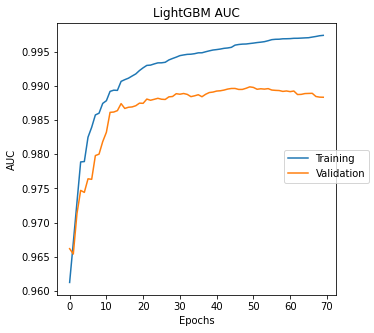

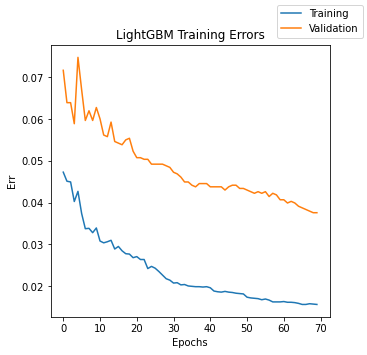

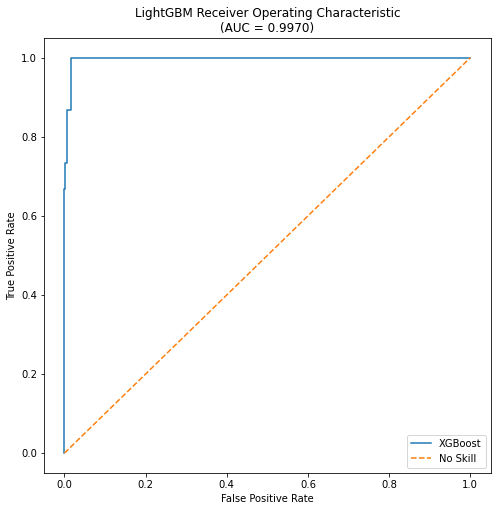

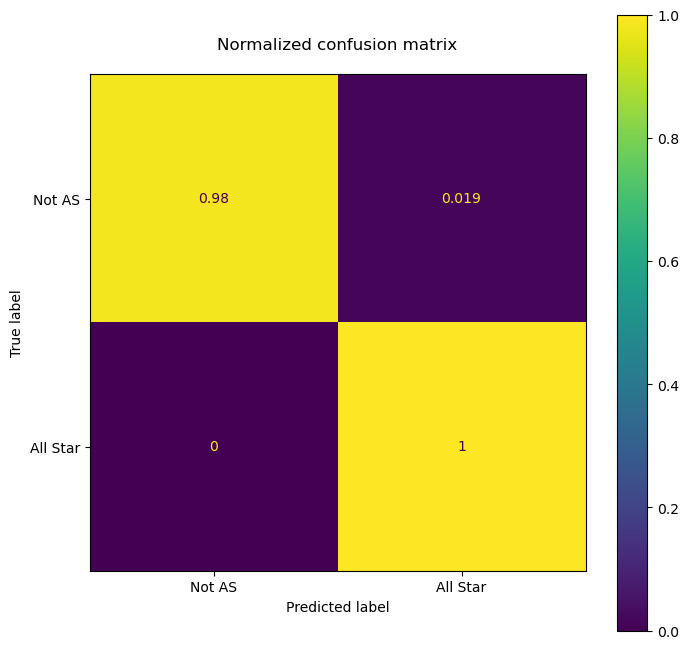

In [39]:
plot_evaluations()

In [79]:
show_classification_metrics()

Optimal threshold: 0.9400000000000007


Score
Metric             
Accuracy   0.992439
Precision  0.866667
Recall     0.866667
F1 Score   0.866667
Log. Loss  0.065283
ROC AUC    0.997665

Here we can see the evaluation metrics of the model. It has an accuracy of 99% and 86.7% F1 score.

## How well did we actually do?

In [210]:
test_data['proba'] = y_test_proba
top_20_pred = test_data.sort_values(by = 'proba', ascending = False)
top_20_list = ((top_20_pred.iloc[:20, ])[["PLAYER", "TEAM", "proba", "Selected?"]]).set_index('PLAYER')

In [211]:
top_20_list

TEAM     proba  Selected?
PLAYER                                         
Giannis Antetokounmpo  MIL  0.998106          1
James Harden           HOU  0.994202          1
LeBron James           LAL  0.993080          1
Luka Doncic            DAL  0.990370          1
Anthony Davis          LAL  0.989547          1
Russell Westbrook      HOU  0.988831          1
Kawhi Leonard          LAC  0.988685          1
Damian Lillard         POR  0.985200          1
Jayson Tatum           BOS  0.977097          1
Joel Embiid            PHI  0.971394          0
Paul George            LAC  0.971311          0
Rudy Gobert            UTA  0.969867          1
Nikola Jokic           DEN  0.969500          1
Pascal Siakam          TOR  0.952531          1
Jimmy Butler           MIA  0.949901          1
Kyrie Irving           BKN  0.938085          0
Domantas Sabonis       IND  0.905569          0
Devin Booker           PHX  0.903185          0
Chris Paul             OKC  0.900855          1
Ben Simmons            PHI  0.886582          1

If we pick out the top 15 predictions, we can see that our accuracy is $13/15 = 86.7\%$. It is good, considering that the probabilities are actually close to each other. Besides, the only two mistakes (Chris Paul and Ben Simmons) are still having high probability.

# Model Interpretation

We have a model we're satisfied with. But so far, the entire model is still mystery. We can observe the final output probabilities, but why the model is actually working like this? 

Why Giannis, a recently famous player (two-time MVP owner), is not predicted as one of All-NBA Team members? Why Chirs Paul, a 7-time All-NBA Team member, is only predicted to have 62% probability of being selected?

By nature, some models are easy to interpret by coefficients of parameters or visualization. However, with some complex model, like LightGBM, it is not that straightforward. However, we still have some well-developed techniques to estimate the impact of each feature in complex models. 

The one we will use here is **SHAP** (Shapley Additive explanations). Specifically, we'll use *TreeShap*, a variant of tree-based machine learning models.

We will supplement SHAP analysis with PDP (partial dependency plots) to see how exactly different features alter predictions when we hold other input constant. Both SHAP and PDP are tools to interpret machine learning models.

In [3]:
import shap

def plot_model_bar():
    model = pickle.load(open('A_NBA_Team_predictor.model', 'rb'))

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values[0], X_test, plot_type = 'bar', show = False)

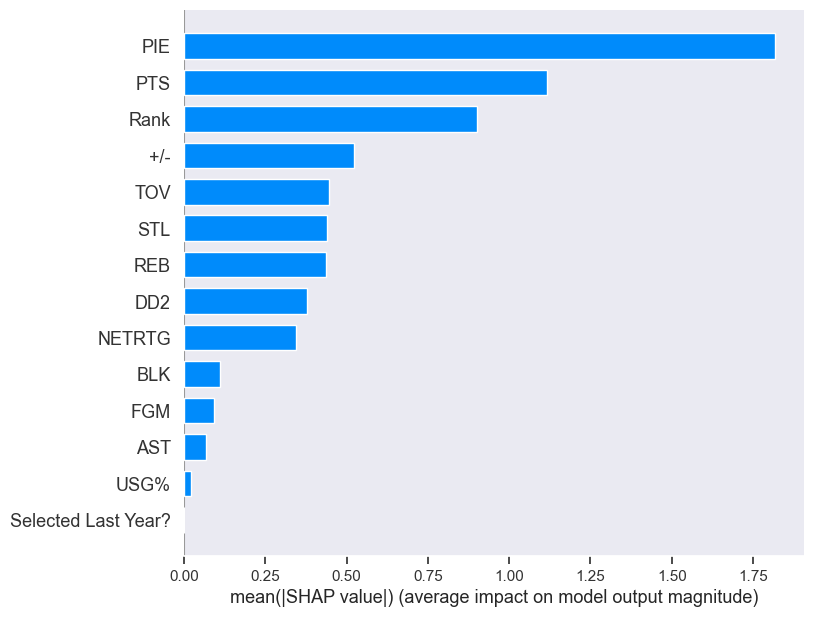

In [87]:
plot_model_bar()

Not surprisingly, **PIE** (Player Impact Estimator) has a high impact on the predictions. The following two are **Points** and **Rank** values.

Points is resonably considered as the most powerful personal statistic, so it is understandable to be at the second place. However, rank is an interesting standard. 

To NBA fans, it is not secret that every year we can list out many players having outstanding statistics, but couldn't help their teams win the ticket of the playoff. Atlanta Hawks player Trae Young is a good recent example. Typically, this type of players won't be recognized by coaches as a star, unless they figure out the way to lead their team. This is why **Rank** could be in such an influential position.

In [156]:
def plot_model_dot():
    model = pickle.load(open('A_NBA_Team_predictor.model', 'rb'))

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    shap.summary_plot(shap_values[0], X_test, plot_type = 'dot')

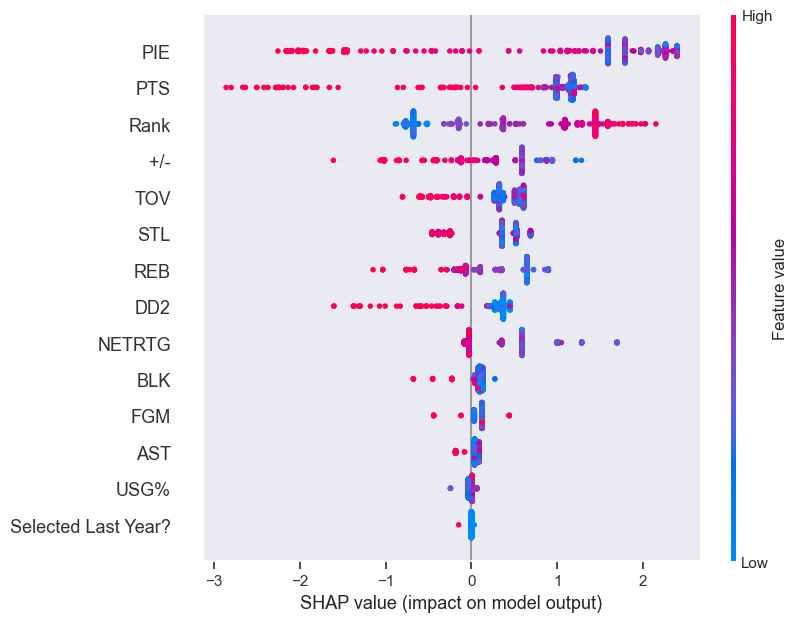

In [157]:
plot_model_dot()

This dot plot has similar effect as the bar plot. Each player in the testing dataset adds one dot to every row in this plot. The color of the dot denotes whether the player's attribute was high or low, and the lateral position is how impactful this attribute value was on the predicted probability.

In [154]:
from pdpbox import pdp

def plot_pdp():
    partial_dependence_features = ['PIE', 'Rank', 'PTS']
    for i, feature in enumerate(partial_dependence_features):
        pdp_feature = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns.tolist(), feature=feature)
        fig, ax = pdp.pdp_plot(pdp_feature, feature, figsize=(10,8))
        plt.show()

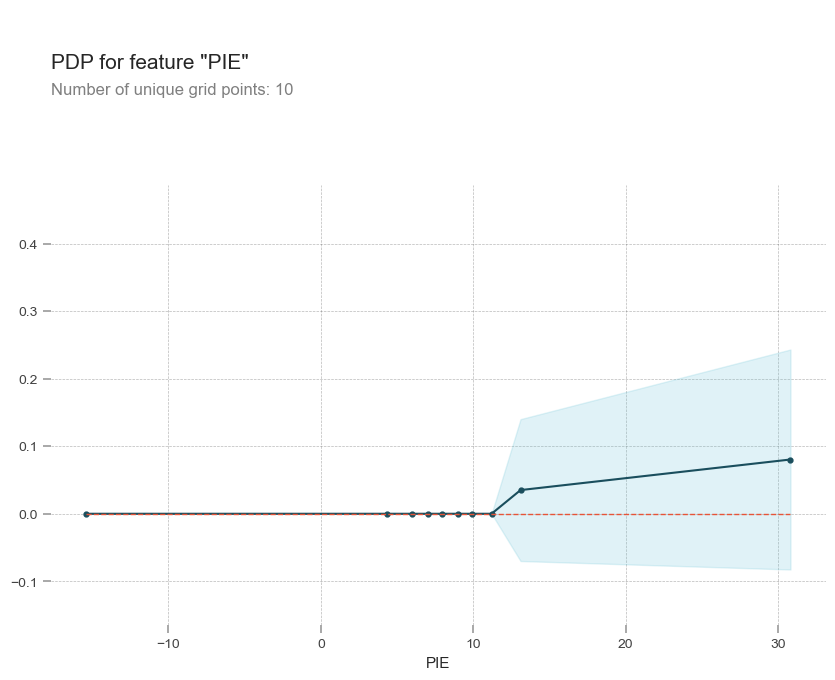

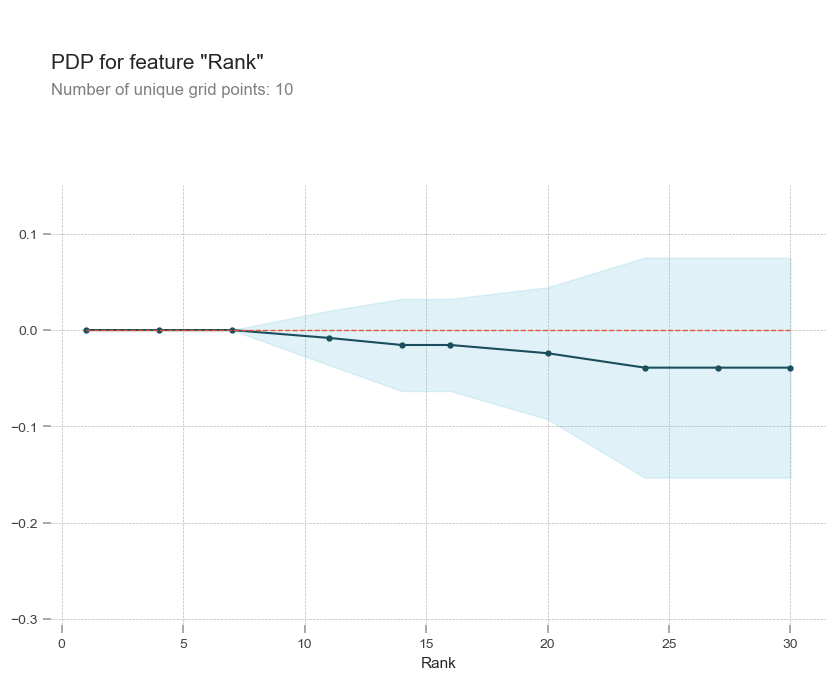

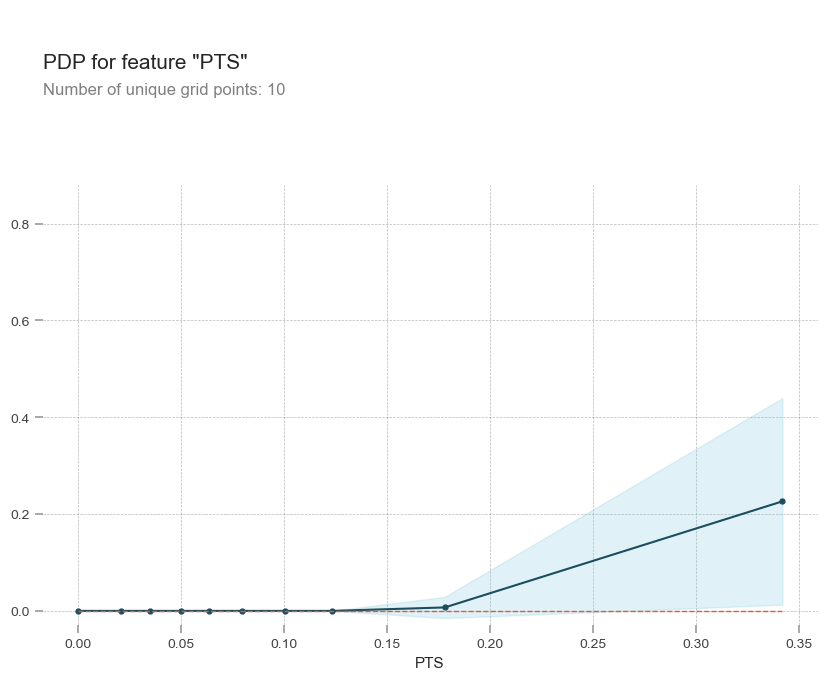

In [155]:
plot_pdp()

From Partial Dependency plots, we can see also observe that the "bump" of probability is more obvious in **PIE**, **Points** and **Rank**.

## Player-specific SHAP force plots

We can extend SHAP analysis even further, and investigate model decisions for specific players. By using force plots, we can generate personalized report for players to outline their performance and help them to improve themselves. 

These are most insightful for edge cases (who didn't been selected as All-NBA Team members), we can compare them with those who are selected as All-NBA Team members. Besides, we can also see why players like Chris Paul are not receiving have probability.

We are going to look at Guards. 

There are 6 All-NBA Team guards selected plus 2 guards who are not selected.

- 1st Team: James Harden, Luka Doncic
- 2nd Team: Chris Paul, Damian Lillard
- 3rd Team: Russell Westbrook, Ben Simmons
- Unselected Candidate: Kyrie Irving, Devin Booker

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


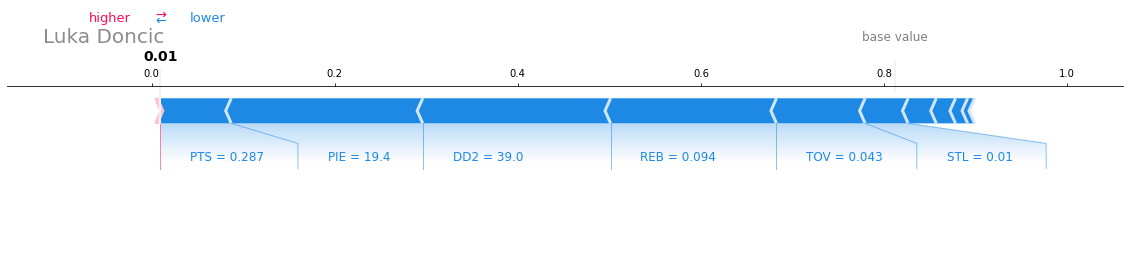

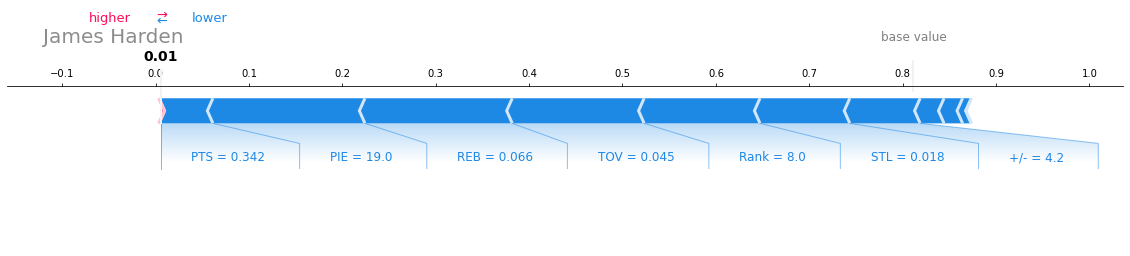

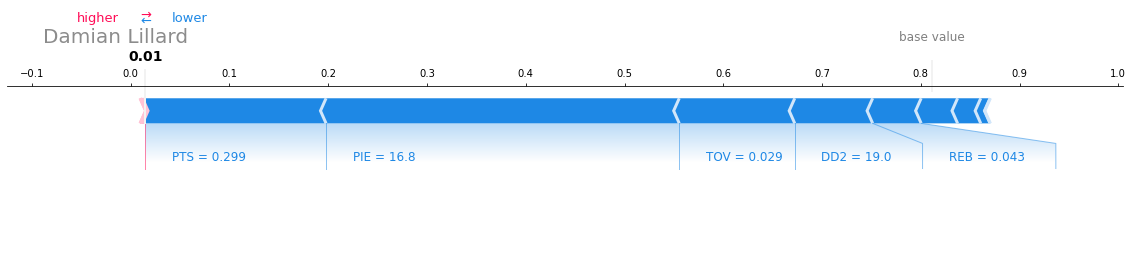

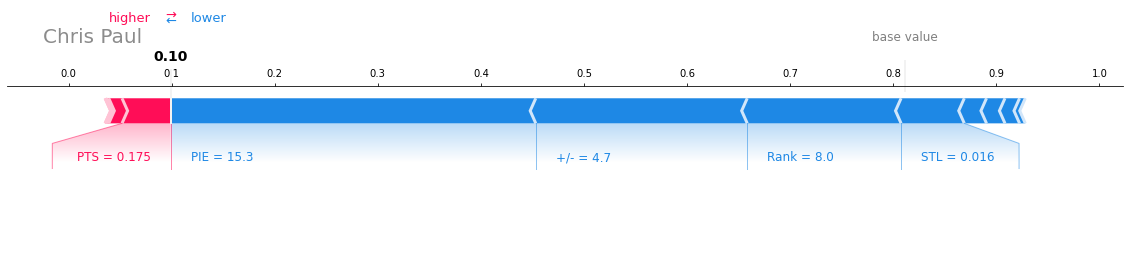

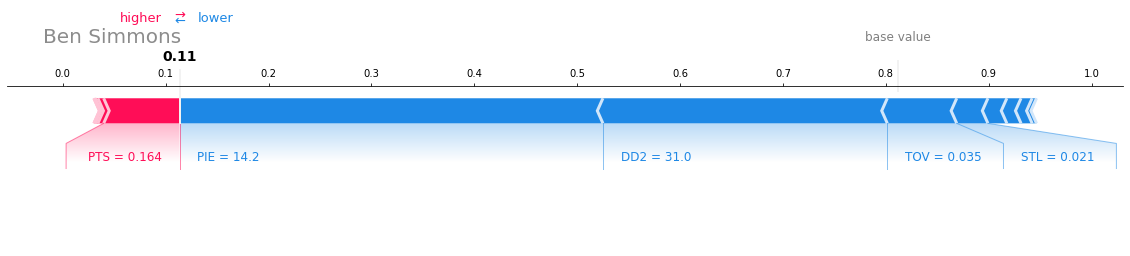

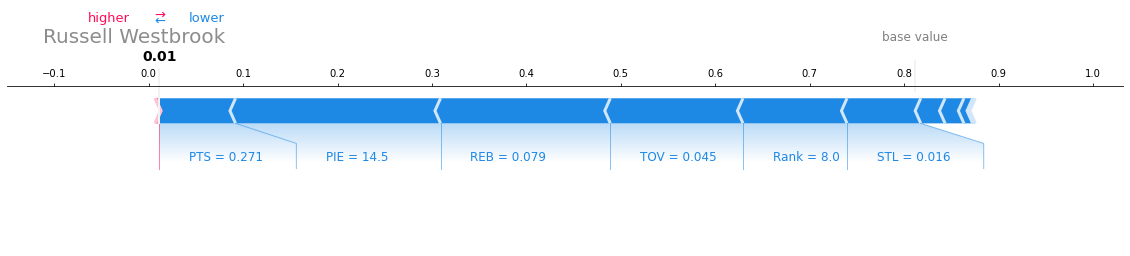

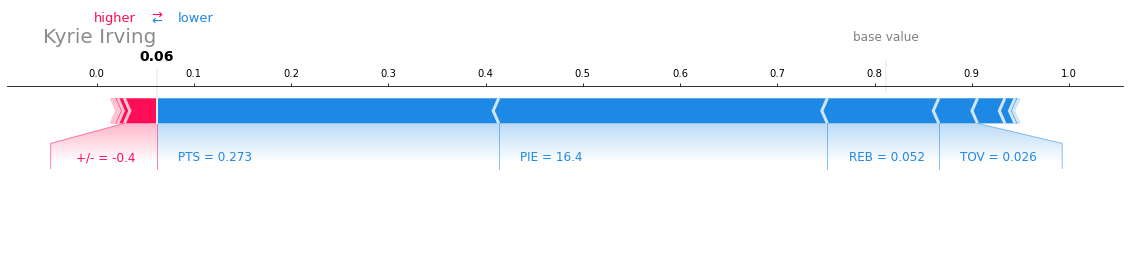

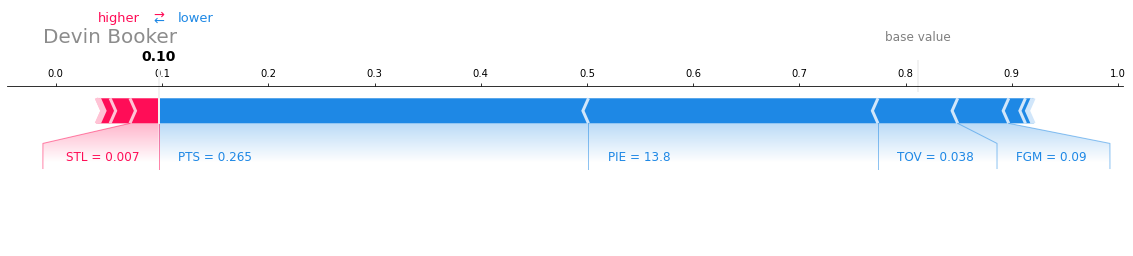

In [55]:
players_to_investigate = ['Luka Doncic', 
                          'James Harden', 
                          'Damian Lillard', 
                          'Chris Paul', 
                          'Ben Simmons', 
                          'Russell Westbrook', 
                          'Kyrie Irving', 
                          'Devin Booker']

model = pickle.load(open('A_NBA_Team_predictor.model', 'rb'))
explainer = shap.TreeExplainer(model)

# if true, will display the html/js rendering of the shap force plot
# otherwise, the matplotlib version will be displayed
disp_html = False

if disp_html:
    shap.initjs()

for i in range(len(players_to_investigate)):
    
    player_name = players_to_investigate[i]
    df_investigation = (test_data[test_data['PLAYER'] == player_name])[selected_features]
    
    # fix issue where way too many digits of each feature was being displayed in the matplotlib plot
    df_investigation = round(df_investigation, 3)
    
    player_shap_values = explainer.shap_values(np.asarray(df_investigation).reshape(1, -1))

    
    fig = shap.force_plot(explainer.expected_value[0], player_shap_values[0], df_investigation,
                    link='logit', out_names = '', feature_names=selected_features,
                    show=False, matplotlib=True)
    fig.suptitle(player_name, x=0.15, y=1.15, color='#8c8c8c', va='top', ha='left', size=20)
    
    if not disp_html:
        plt.show()
        
    plt.close()

In [59]:
df_investigation = (test_data[test_data['PLAYER'] == 'Devin Booker'])[selected_features]
df_investigation

PTS       REB       AST       TOV       STL       BLK  Rank  \
148  0.265204  0.041874  0.064806  0.037886  0.006979  0.002991    16   

          FGM  DD2  NETRTG  USG%   PIE  +/-  Selected Last Year?  
148  0.089731   11     2.7  29.4  13.8  1.9                    0

From these plots, we gain some insights. 
1. Chris Paul and Ben Simmons are dragged down because of their scoring ability.

This is quite understandable. Scoring ability is the most straightforward way to evaluate a player. When all these players receive a high probability of being All NBA Team members, such great disadvantage will definitely influence the model prediction.

Besides, We can see that the number of Double Double is actually beneficial to Ben Simmons. In this year, the number of getting double double and triple double will change people's view to a player. From this perspective, it is supportive that DD should be selected as one of the model features. Maybe next time we should try to put Triple Double inside the model (I didn't select it this time is because it is overlapped with DD).

If we want to discuss the reason of selected doesn't be consider by the model, then there are two.

First, the model do not have a criteria to estimate the defense ability. Although Offense ability are much more important than Defense ability in NBA, we cannot ignore this. Both Ben Simmons and Chris Paul are great defensive player.

Second, the model do not have a criteria to standardize the impact for a player to one team, especially after they encounter some new challenge (e.g. the leave of another star player, or influence to a new team). Chris Paul was traded from Rocket to Thunder. At the beginning of the season, most of people underestimate Chris Paul's ability to lead this team. They all believe Thunder would tank in this year, but Chris Paul broke those prejudice by leading the team back to playoff. This is his leading ability, his way to influence a team. This kind of ability is supposed to be considered in model features.

2. Devin Booker and Kyrie Irving should lead the team further and play more efficiently.

Devin Booker and Kyrie Irving cannot receive a higher probability because they don't have sufficient advantage compared to others. As pure attackers, it is acceptable to have fewer assist or rebound compared to other guards. However, they should know how to play more efficiently and lead the team further. Both of them are having low +/- values and team rank compared to other guards. 

# Conclusion

This entire project stemmed from curiosity. As a NBA fan, it is always excited to know who are the greatest player in each year. But throughout this year, after becoming a data scientist, the curiosity ultimately pushed me to try tearing apart the selection process and gain some insights. 

This project served as a great learning experience for me. Personally, this is the first time I deal with such a challenging web scraping. In addition, this is also the first time try to break down the "black box" of complex but outstanding machine learning model. Self-learning new things and redo a complete data science project really give me a lot of fun. 

**Thank you for taking time to read this long notebook!**